In [1258]:
# dynamic obstacle debugging

import numpy as np
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import comb
from concurrent.futures import ProcessPoolExecutor, as_completed
from scipy.optimize import minimize

# -----------------------------
# Parameters
# -----------------------------

# Ego-agent boundary conditions
x0 = np.array([0.0, 0.0, 0.0])
v0 = np.array([0.0, 1.0, 0.5])
a0 = np.array([0.0, 0.0, 0.0])
xf = np.array([0.0, 7.0, 2.0])
vf = np.array([0.0, 0.0, 0.0])
af = np.array([0.0, 0.0, 0.0])

# Obstacle boundary conditions & time

# Obstacle 0
x0_obs0 = np.array([1.0, 3.0, 1.0])
v0_obs0 = np.array([-0.3, 0.3, 0.0])
a0_obs0 = np.array([0.0, 0.0, 0.0])
xf_obs0 = np.array([-2.0, 4.0, 1.5])
vf_obs0 = np.array([0.0, 0.0, 0.0])
af_obs0 = np.array([0.0, 0.0, 0.0])
T_obs0 = 10.0

# Obstacle 1
x0_obs1 = np.array([-1.0, 5.0, -1.0])
v0_obs1 = np.array([0.5, 0.0, 0.0])
a0_obs1 = np.array([0.0, 0.0, 0.0])
xf_obs1 = np.array([6.0, 5.0, -0.5])
vf_obs1 = np.array([0.0, 0.0, 0.0])
af_obs1 = np.array([0.0, 0.0, 0.0])
T_obs1 = 8.0

# List of obstacles
obstacles = [
    [x0_obs0, v0_obs0, a0_obs0, xf_obs0, vf_obs0, af_obs0, T_obs0],
    [x0_obs1, v0_obs1, a0_obs1, xf_obs1, vf_obs1, af_obs1, T_obs1],
]
# obstacles = []

# Static box for visualization
box_center = np.array([2.5, 2.5, 1.0])
box_size = np.array([2.0, 2.0, 2.0])  # size of the box in x, y, z dimensions

# Global waypoints
global_wps = np.array([x0, 
                       [0.0, 3.0, 1.0], 
                       [0.0, 5.0, 1.5], 
                       xf])

# Number of segments M
M = len(global_wps) - 1

# Static constraints
A_stat = [
    np.array([[-0.5, 0.0, 0.1]]),  # 0th segment: 2 constraints
    np.array([[-0.5, 0.5, 0.1]]),                 # 2nd segment: 1 constraint
    np.array([[0.0, 0.5, 0.1]]),   # 3rd segment: 1 constraint
]

b_stat = [
    np.array([-0.5]),  # 0th segment
    np.array([1.0]),        # 1st segment
    np.array([2.0]),   # 3rd segment
]

assert len(A_stat) == M, "Number of segments M does not match the number of static constraints."
assert len(b_stat) == M, "Number of segments M does not match the number of static constraints."

# The dynamic constraints
V_max = 2.0  # max velocity
A_max = 100.0  # max acceleration
J_max = 100.0  # max jerk

## sampling grids
N_samp = 10

# Generate perturbed waypoints
joint_indices = [i for i in range(1, M)]  # indices of the joints to perturb
print("Joint indices:", joint_indices)
num_samples = 8  # number of perturbed waypoint sets to generate
r_max = 1.0  # radius bounds for perturbation

# Generate perturbed waypoints
constraint_sets = []
for idx in joint_indices:
    sets = [(A_stat[idx - 1], b_stat[idx - 1]), (A_stat[idx], b_stat[idx])]
    constraint_sets.append(sets)

# indices of your 6 free control points:
# (seg,index) pairs for free control points
free_cps = [(i, j) for i in range(1, M) for j in range(3)]

F = len(free_cps)

# Optimization parameters
time_weight = 10.0
dyn_weight = 0.1
stat_weight = 0.1
accel_weight = 0.1
jerk_weight = 0.1
dyn_constr_vel_weight = 10.0
dyn_constr_acc_weight = 1.0
bfgs_max_iter = 20
Co = 0.5  # e.g. 0.1 m
Cw = 1.0  # desired clearance for reciprocal collision avoidance
c = 2.0  # ellipsoid factor for reciprocal collision avoidance (z axis)
initi_sigma_factor = 2.0 # gives more initial time for each segment if you have higher values

Joint indices: [1, 2]


In [1259]:
#------------------------------
# Functions
#------------------------------

def get_segment_and_tau(ti, T):
    """
    Given time ti and segment durations T,
    return (seg, tau, t0) where
      seg = segment index,
      t0  = start time of that segment,
      tau = (ti - t0) / T[seg].
    """
    ends = np.cumsum(T)
    seg  = np.searchsorted(ends, ti, side='right')
    seg  = min(seg, len(T) - 1)
    t0   = ends[seg-1] if seg > 0 else 0.0
    tau  = (ti - t0) / T[seg]
    return seg, tau, t0

def bernstein_basis_and_derivative(n, tau):
    """
    Degree-n Bernstein basis B[j] and derivative dB[j] at tau.
    """
    # B
    B = np.array([comb(n, j) * tau**j * (1-tau)**(n-j)
                  for j in range(n+1)])
    # dB via recurrence
    if n == 0:
        return B, np.array([0.0])
    Bm1 = np.array([comb(n-1, j) * tau**j * (1-tau)**((n-1)-j)
                    for j in range(n)])
    dB = np.zeros(n+1)
    for j in range(n+1):
        if j > 0:   dB[j] += n * Bm1[j-1]
        if j < n:   dB[j] -= n * Bm1[j]
    return B, dB

def bernstein(n, j, tau):
    """
    Bernstein basis polynomial of degree n, index j, at parameter tau.
    """
    return comb(n, j) * (tau**j) * ((1 - tau)**(n - j))

def eval_traj_and_derivs(CP, T, num_samples):
    """
    Evaluate composite quintic Bézier in R³.
    Returns:
      pts:   (num_samples × 3) positions
      vels:  (num_samples × 3) velocities
      accs:  (num_samples × 3) accelerations

    CP shape: (M segments, 6 control points, 3 dims)
    T  shape: (M,)
    """
    M = CP.shape[0]
    total_time = np.sum(T)
    t_abs = np.linspace(0.0, total_time, num_samples)

    ends = np.cumsum(T)
    pts  = np.zeros((num_samples, 3))
    vels = np.zeros((num_samples, 3))
    accs = np.zeros((num_samples, 3))
    jrk  = np.zeros((num_samples, 3))  # jerk is not returned, but computed

    for k, ti in enumerate(t_abs):
        # segment index
        seg = np.searchsorted(ends, ti, side='right')
        if seg >= M:
            seg = M - 1
        t0 = ends[seg - 1] if seg > 0 else 0.0
        Ti = T[seg]
        tau = (ti - t0) / Ti

        P = CP[seg]  # shape (6,3)
        # position
        p = np.zeros(3)
        for j in range(6):
            p += P[j] * bernstein(5, j, tau)
        pts[k] = p

        # velocity
        v = np.zeros(3)
        for j in range(5):
            v += (P[j+1] - P[j]) * bernstein(4, j, tau)
        vels[k] = (5.0 / Ti) * v

        # acceleration
        a = np.zeros(3)
        for j in range(4):
            a += (P[j+2] - 2 * P[j+1] + P[j]) * bernstein(3, j, tau)
        accs[k] = (20.0 / (Ti**2)) * a

        # jerk
        j = np.zeros(3)
        for i in range(3):
            j += (P[i+3] - 3 * P[i+2] + 3 * P[i+1] - P[i]) * bernstein(2, i, tau)
        jrk[k] = (60.0 / (Ti**3)) * j

    return pts, vels, accs, jrk

# def softplus(x):
#     """
#     Numerically stable softplus activation.
#     """
#     return np.where(x > 0,
#                     x + np.log1p(np.exp(-x)),
#                     np.log1p(np.exp(x)))

def reconstruct(z, x0, v0, a0, xf, vf, af, wps):
    """
    Reconstruct Bezier control points and times in R³.

    Inputs:
      z      : vector [free CPs (F×3), slacks (M,)]
      x0,v0,a0: start pos/vel/acc in R³
      xf,vf,af: end   pos/vel/acc in R³
      wps    : global waypoints (M+1, 3)

    Returns:
      CP : (M,6,3)
      T  : (M,)
    """
    # unpack
    ptr     = 0
    cp_free = z[ptr:ptr + 3*F].reshape(F, 3)
    ptr    += 3*F
    sig     = z[ptr:ptr + M]
    ptr    += M

    # segment times with minimums
    # t_mins = np.zeros(M)
    # for i in range(M - 1):
    #     t_mins[i] = np.linalg.norm(wps[i+1] - wps[i]) / V_max

    T = np.exp(sig)
    # T = softplus(sig) + t_mins

    # allocate CP array
    CP = np.zeros((M, 6, 3))
    for (seg, idx), pt in zip(free_cps, cp_free):
        CP[seg, idx] = pt

    # boundary injection
    t0 = T[0]
    CP[0, 0] = x0
    CP[0, 1] = x0 + (t0/5.0) * v0
    CP[0, 2] = x0 + (2*t0/5.0) * v0 + (t0**2/20.0) * a0

    tM = T[-1]
    CP[-1, 5] = xf
    CP[-1, 4] = xf - (tM/5.0) * vf
    CP[-1, 3] = xf - (2*tM/5.0) * vf + (tM**2/20.0) * af

    # enforce C2 continuity
    for i in range(M - 1):
        CP[i, 5] = CP[i+1, 0]
        ratio = T[i] / T[i+1]
        CP[i, 4] = CP[i, 5] - ratio * (CP[i+1, 1] - CP[i+1, 0])
        sec = CP[i+1, 2] - 2*CP[i+1, 1] + CP[i+1, 0]
        CP[i, 3] = 2*CP[i, 4] - CP[i, 5] + ratio**2 * sec

    return CP, T

def eval_traj(CP, T, num_samples):
    """
    Sample positions along a composite quintic Bézier.

    Args:
      CP          : (M,6,3) control points
      T           : (M,)      segment durations
      num_samples : int       number of samples

    Returns:
      pts : (num_samples,3)
    """
    M          = CP.shape[0]
    total_time = np.sum(T)
    t_abs      = np.linspace(0.0, total_time, num_samples)
    pts        = np.zeros((num_samples, 3))

    for i, ti in enumerate(t_abs):
        seg, tau, _ = get_segment_and_tau(ti, T)
        B, _        = bernstein_basis_and_derivative(5, tau)
        pts[i]      = B @ CP[seg]    # (6,) @ (6,3) → (3,)
    return pts

def check_continuity(CP, T, tol=1e-6):
    """
    Check C0, C1, C2 errors at segment joints in R³.
    Prints a table and returns dict of lists for pos/vel/acc errors.
    """
    M = CP.shape[0]
    errors = {'pos': [], 'vel': [], 'acc': []}

    for i in range(M - 1):
        p_end   = CP[i, 5]
        p_start = CP[i+1, 0]
        e_pos   = np.linalg.norm(p_end - p_start)

        v_end   = (5.0 / T[i])   * (p_end - CP[i, 4])
        v_start = (5.0 / T[i+1]) * (CP[i+1, 1] - p_start)
        e_vel   = np.linalg.norm(v_end - v_start)

        a_end   = (20.0 / (T[i]**2))   * (p_end - 2*CP[i, 4] + CP[i, 3])
        a_start = (20.0 / (T[i+1]**2)) * (CP[i+1, 2] - 2*CP[i+1, 1] + p_start)
        e_acc   = np.linalg.norm(a_end - a_start)

        errors['pos'].append(e_pos)
        errors['vel'].append(e_vel)
        errors['acc'].append(e_acc)

    header = f"{'Joint':^5} | {'C0 err':^10} | {'C1 err':^10} | {'C2 err':^10}"
    print(header)
    print('-'*len(header))
    for i in range(M-1):
        status = 'OK'
        if errors['pos'][i] > tol or errors['vel'][i] > tol or errors['acc'][i] > tol:
            status = 'ERROR'
        print(f"{i:^5} | {errors['pos'][i]:10.2e} | {errors['vel'][i]:10.2e} | {errors['acc'][i]:10.2e} | {status}")

    return errors

def fit_quintic(x0, v0, a0, xf, vf, af, T):
    """
    Fit a single-segment quintic in R³; returns (cx, cy, cz) each length-6.
    """
    A = np.zeros((6,6))
    bx = np.zeros(6); by = np.zeros(6); bz = np.zeros(6)
    # p(0)=x0, p'(0)=v0, p''(0)=a0
    A[0,0] = 1; bx[0], by[0], bz[0] = x0
    A[1,1] = 1; bx[1], by[1], bz[1] = v0
    A[2,2] = 2; bx[2], by[2], bz[2] = a0
    # p(T)=xf
    for i in range(6): A[3,i] = T**i
    bx[3], by[3], bz[3] = xf
    # p'(T)=vf
    for i in range(1,6): A[4,i] = i * T**(i-1)
    bx[4], by[4], bz[4] = vf
    # p''(T)=af
    for i in range(2,6): A[5,i] = i*(i-1) * T**(i-2)
    bx[5], by[5], bz[5] = af

    cx = np.linalg.solve(A, bx)
    cy = np.linalg.solve(A, by)
    cz = np.linalg.solve(A, bz)
    return cx, cy, cz

def f_obs_poly(t, c_x, c_y, c_z):
    """
    Dynamic obstacle polynomial in R³.
    """
    t = np.array(t)
    px = sum(c_x[i] * t**i for i in range(6))
    py = sum(c_y[i] * t**i for i in range(6))
    pz = sum(c_z[i] * t**i for i in range(6))
    return np.vstack([px, py, pz]).T

def sample_systematic_perturbed_waypoints(global_wps, joint_indices,
                                          r_max,
                                          constraint_sets):
    """
    Perturb joint waypoints by sampling 8 directions in the bisector-plane,
    always at distance r_max, and respecting *any* number of linear constraints:
      A @ pt > b, where A may be (3,) or (n,3) and b may be scalar or (n,).
    
    Args:
      global_wps     : list or (K×3) array of original waypoints
      joint_indices  : list of indices into global_wps to perturb
      r_max          : scalar radius for perturbation
      constraint_sets: list of length len(joint_indices), each a list of
                       tuples (A, b) where
                         • A is np.ndarray of shape (3,) or (n_planes,3)
                         • b is float or np.ndarray of shape (n_planes,)
    
    Returns:
      samples : np.ndarray of shape (M,K,3), with M≤8 feasible perturbed sets
    """
    # 1) build per-joint bisector bases
    bases = []
    for idx in joint_indices:
        P_prev, P, P_next = global_wps[idx-1], global_wps[idx], global_wps[idx+1]
        d1 = (P - P_prev); d1 /= np.linalg.norm(d1)
        d2 = (P_next - P);  d2 /= np.linalg.norm(d2)
        pn = np.cross(d1, d2)
        if np.linalg.norm(pn) < 1e-8:
            pn = np.cross(d1, [1,0,0])
        pn /= np.linalg.norm(pn)
        bis_n = d1 + d2
        if np.linalg.norm(bis_n) < 1e-8:
            bis_n = d1
        bis_n /= np.linalg.norm(bis_n)
        v_bis = np.cross(bis_n, pn)
        v_bis /= np.linalg.norm(v_bis)
        bases.append((pn, v_bis))

    # 2) sample 8 equally-spaced angles
    angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
    samples = []

    # 3) for each angle, try perturbing *all* joints
    for φ in angles:
        cand = [p.copy() for p in global_wps]
        feasible = True

        for j, idx in enumerate(joint_indices):
            pn, v_bis = bases[j]
            direction = np.cos(φ)*pn + np.sin(φ)*v_bis
            pt = global_wps[idx] + r_max * direction

            # 4) check *all* constraints in constraint_sets[j]
            for A, b in constraint_sets[j]:
                
                # If A and b are empty, skip this constraint
                if A.size == 0 or b.size == 0:
                    continue

                # unify shapes
                arrA = np.atleast_2d(A)
                arrb = np.atleast_1d(b)
                # compute A @ pt - b  → shape (n_planes,)
                h = arrA.dot(pt) - arrb
                if np.any(h <= 0):
                    feasible = False
                    break
            if not feasible:
                break

            cand[idx] = pt

        if feasible:
            samples.append(np.stack(cand))

    return np.array(samples)  # shape (M, K, 3)

def plot_velocity_acceleration(CP, T, num_samples=100):
    """
    Plot the 3D velocity and acceleration profiles over time.
    """
    pts, vels, accs, _ = eval_traj_and_derivs(CP, T, num_samples)
    t = np.linspace(0, T.sum(), num_samples)

    # Velocity
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    for i, lab in enumerate(['Vx','Vy','Vz']):
        axs[i].plot(t, vels[:,i], label=lab)
        axs[i].set_ylabel(lab)
        axs[i].grid(True)
    axs[-1].set_xlabel('Time (s)')
    fig.suptitle('Velocity Profile in 3D')
    plt.show()

    # Acceleration
    fig, axs = plt.subplots(3, 1, figsize=(8, 12))
    for i, lab in enumerate(['Ax','Ay','Az']):
        axs[i].plot(t, accs[:,i], label=lab)
        axs[i].set_ylabel(lab)
        axs[i].grid(True)
    axs[-1].set_xlabel('Time (s)')
    fig.suptitle('Acceleration Profile in 3D')
    plt.show()

def plot_trajectory(original_global_wps, sampled_wps,
                    x0, v0, xf,
                    T_obs, f_obs_poly, c_x, c_y, c_z,
                    list_cp0, list_t0):
    """
    3D view of:
     - the original global trajectory
     - all perturbed waypoint sets
     - the dynamic obstacle
     - each initial guess trajectory
    """
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')

    # Global path
    ax.plot(*original_global_wps.T, 'bo--', label='Global Path')

    # Perturbations
    for w in sampled_wps:
        ax.plot(*w.T, '--', alpha=0.3)

    # Start/goal
    ax.scatter(*x0, c='green', s=60, label='Start')
    ax.scatter(*xf, c='red',   s=60, label='Goal')

    # Dynamic obstacle
    ts = np.linspace(0, T_obs, 50)
    obs = f_obs_poly(ts, c_x, c_y, c_z)
    ax.plot(*obs.T, 'r--', label='Dynamic Obs')

    # Initial guesses
    for cp0, T0 in zip(list_cp0, list_t0):
        traj = eval_traj(cp0, T0, 100)
        ax.plot(*traj.T, 'g-', alpha=0.6)

    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    plt.show()

Number of sampled waypoint sets: 8
[refine] reached max_iters=2 but still violations
Tinit: [2.8577916  1.55739029 2.03661776]
  CP: [[[0.         0.         0.        ]
  [0.         0.57155832 0.28577916]
  [0.         1.14311664 0.57155832]
  [0.         1.84169752 0.74084795]
  [0.         2.40538545 0.86211354]
  [0.         3.         1.        ]]

 [[0.         3.         1.        ]
  [0.         3.32404285 1.075143  ]
  [0.         3.65727043 1.15522214]
  [0.         4.0265199  1.2506999 ]
  [0.         4.49635456 1.37170181]
  [0.         5.         1.5       ]]

 [[0.         5.         1.5       ]
  [0.         5.65862311 1.66777706]
  [0.         6.37506637 1.84803158]
  [0.         7.         2.        ]
  [0.         7.         2.        ]
  [0.         7.         2.        ]]]
Processed waypoint set in 0.0020 seconds
Tinit: [3.91265674 2.15350581 2.0974105 ]
  CP: [[[ 0.          0.          0.        ]
  [ 0.          0.78253135  0.39126567]
  [ 0.          1.5650627 

Eigen::VectorXd py_z0(21);
py_z0 << 0, 3, 1, 0, 3.3240428, 1.075143, 0, 3.6572704, 1.1552221, 0, 5, 1.5, 0, 5.6586231, 1.6677771, 0, 6.3750664, 1.8480316, 1.0500492, 0.44301153, 0.71129047;


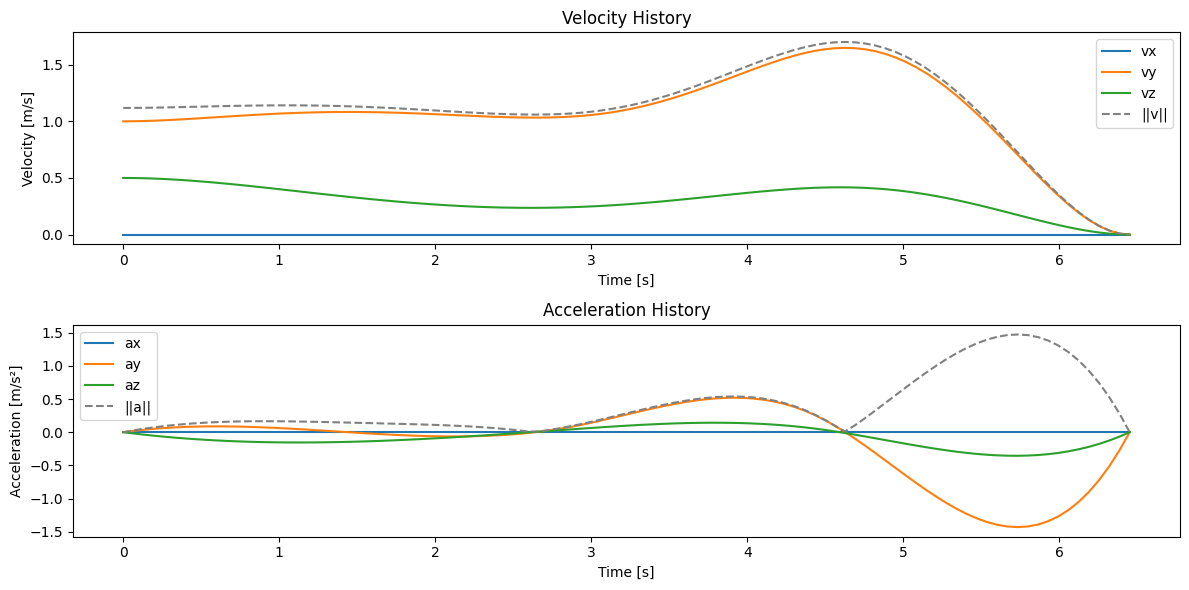

In [1260]:
import plotly.graph_objs as go


def plot_control_points_plotly(cp_list, labels=False):
    """
    Plot one or more sets of Bézier control points in 3D using Plotly.

    Args:
      cp_list : list of numpy arrays, each of shape (M,6,3) for M segments
      labels  : bool, if True annotate each control point with its index
    """
    fig = go.Figure()

    for set_idx, CP in enumerate(cp_list):
        M = CP.shape[0]
        # color cycle
        color = f"hsl({(set_idx*60) % 360}, 70%, 50%)"
        for seg in range(M):
            pts = CP[seg]  # (6,3)
            # connect control polygon
            fig.add_trace(
                go.Scatter3d(
                    x=pts[:, 0],
                    y=pts[:, 1],
                    z=pts[:, 2],
                    mode="markers+lines",
                    marker=dict(size=5),
                    line=dict(width=2, color=color),
                    name=f"Set {set_idx} Seg {seg}",
                    showlegend=(seg == 0),
                )
            )
            # optional labels
            if labels:
                fig.add_trace(
                    go.Scatter3d(
                        x=pts[:, 0],
                        y=pts[:, 1],
                        z=pts[:, 2],
                        mode="text",
                        text=[f"{i}" for i in range(6)],
                        textposition="top center",
                        showlegend=False,
                    )
                )

    # Set limits and labels
    limits = {"x": (-2, 6), "y": (-2, 6), "z": (-2, 6)}
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=limits["x"], title="X"),
            yaxis=dict(range=limits["y"], title="Y"),
            zaxis=dict(range=limits["z"], title="Z"),
            aspectmode="cube",
        ),
        title="3D Bézier Control Points",
        width=800,
        height=700,
    )
    fig.show()


def plot_initial_setting_plotly(
    obstacles, list_cp0, list_t0, grid_n=20, N_time_samples=10
):
    # draw your box and waypoints into lists of x,y,z
    fig = go.Figure()

    box_edges = [
        [
            box_center + [-box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
            box_center + [box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
            box_center + [-box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
            box_center + [box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
        ],
        [
            box_center + [box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
            box_center + [box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
            box_center + [box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
            box_center + [-box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
            box_center + [box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
            box_center + [box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
            box_center + [-box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [box_size[0] / 2, -box_size[1] / 2, -box_size[2] / 2],
            box_center + [box_size[0] / 2, -box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [-box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
            box_center + [-box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
        ],
        [
            box_center + [box_size[0] / 2, box_size[1] / 2, -box_size[2] / 2],
            box_center + [box_size[0] / 2, box_size[1] / 2, box_size[2] / 2],
        ],
    ]

    for edge in box_edges:
        fig.add_trace(
            go.Scatter3d(
                x=[p[0] for p in edge],
                y=[p[1] for p in edge],
                z=[p[2] for p in edge],
                mode="lines",
                line=dict(color="gray"),
                name=None,
            )
        )

    # waypoints
    fig.add_trace(
        go.Scatter3d(
            x=global_wps[:, 0],
            y=global_wps[:, 1],
            z=global_wps[:, 2],
            mode="markers+lines",
            marker=dict(size=5, color="blue"),
            name="Waypoints",
        )
    )

    # -- Planes --
    limits = {"x": (-3, 6), "y": (-3, 6), "z": (-3, 6)}
    xs = np.linspace(limits["x"][0], limits["x"][1], grid_n)
    ys = np.linspace(limits["y"][0], limits["y"][1], grid_n)
    X, Y = np.meshgrid(xs, ys)

    # loop over each segment's static constraints
    for idx, (normals, bis) in enumerate(zip(A_stat, b_stat)):

        # Different color for each segment
        color = f"hsl({(idx*60) % 360}, 70%, 50%)"

        # loop over each normal and bisector in the segment
        for normal, bi in zip(normals, bis):

            a, b, c = normal
            if abs(c) < 1e-6:
                # skip near-vertical for simplicity
                continue
            Z = (bi - a * X - b * Y) / c
            fig.add_trace(
                go.Surface(
                    x=X,
                    y=Y,
                    z=Z,
                    opacity=0.2,
                    showscale=False,
                    name=f"Plane {idx}",
                    colorscale=[[0, color], [1, color]],
                )
            )

    # --- dynamic obstacle curve ---
    # dense curve
    # loop over each dynamic obstacle
    for obs in obstacles:
        c_x_obs, c_y_obs, c_z_obs = fit_quintic(
            obs[0], obs[1], obs[2], obs[3], obs[4], obs[5], obs[6]
        )
        T_obs = obs[6]
        # plot the dense curve
        t_dense = np.linspace(0, T_obs, 200)
        obs_dense = f_obs_poly(t_dense, c_x_obs, c_y_obs, c_z_obs)

        fig.add_trace(
            go.Scatter3d(
                x=obs_dense[:, 0],
                y=obs_dense[:, 1],
                z=obs_dense[:, 2],
                mode="lines",
                line=dict(color="orange", width=4),
                name="Dyn Obs Traj",
            )
        )

        # sparse samples with labels
        # this is just for visualization, so we use N_dyn_obst_samples but for actual cost computation sampling, we use N_sample along the ego agent trajectory
        N_dyn_obst_samples = 20
        t_samples = np.linspace(0, T_obs, N_dyn_obst_samples)
        obs_samp = np.vstack(
            [
                sum(c_x_obs[i] * t_samples**i for i in range(6)),
                sum(c_y_obs[i] * t_samples**i for i in range(6)),
                sum(c_z_obs[i] * t_samples**i for i in range(6)),
            ]
        ).T

        fig.add_trace(
            go.Scatter3d(
                x=obs_samp[:, 0],
                y=obs_samp[:, 1],
                z=obs_samp[:, 2],
                mode="markers+text",
                marker=dict(size=5, color="black"),
                text=[f"{t:.1f}" for t in t_samples],
                textposition="top center",
                name="Obs Samples",
            )
        )

    # (b) plot each initial‐guess trajectory
    for idx, (CP0, T0) in enumerate(zip(list_cp0, list_t0)):
        # sample the curve
        num_pts = 200
        pts = eval_traj(CP0, T0, num_pts)  # (num_pts×3)
        times = np.linspace(0, T0.sum(), num_pts)

        # a) the line itself
        fig.add_trace(
            go.Scatter3d(
                x=pts[:, 0],
                y=pts[:, 1],
                z=pts[:, 2],
                mode="lines",
                line=dict(color="green", width=4),
                name="Init Guess" if idx == 0 else None,
                showlegend=(idx == 0),
            )
        )

        # b) a few markers with text = time
        indices = np.linspace(0, num_pts - 1, N_time_samples, dtype=int)
        fig.add_trace(
            go.Scatter3d(
                x=pts[indices, 0],
                y=pts[indices, 1],
                z=pts[indices, 2],
                mode="markers+text",
                marker=dict(size=5, color="green"),
                text=[f"{t:.1f}" for t in times[indices]],
                textposition="top center",
                name="Time stamps" if idx == 0 else None,
                showlegend=(idx == 0),
            )
        )

    fig.update_layout(
        scene=dict(
            xaxis=dict(range=limits["x"], title="X"),
            yaxis=dict(range=limits["y"], title="Y"),
            zaxis=dict(range=limits["z"], title="Z"),
            aspectmode="cube",
        ),
        width=800,
        height=600,
        title="3D Initial Setting with Box, Waypoints, and Planes",
    )
    fig.show()


def compute_quintic_bezier_control_points(P0, V0, A0, P1, V1, A1, T):
    """
    Convert (P0,V0,A0)->(P1,V1,A1) on [0,T] into the 6 Bernstein control points b0..b5.
    Ensures p(0)=P0, p'(0)=V0, p''(0)=A0,
            p(T)=P1, p'(T)=V1, p''(T)=A1,
    and thus C2 joins.
    """
    b0 = P0
    b1 = P0 + V0 * (T / 5.0)
    # to match p''(0)=A0:  b2 = 2*b1 - b0 + 0.5*A0*T^2
    b2 = 2*b1 - b0 + 0.5 * A0 * T**2

    b5 = P1
    b4 = P1 - V1 * (T / 5.0)
    # to match p''(T)=A1:  b3 = 2*b4 - b5 + 0.5*A1*T^2
    b3 = 2*b4 - b5 + 0.5 * A1 * T**2

    return np.stack([b0, b1, b2, b3, b4, b5], axis=0)


# -------------------------------------------------------------------------
# 1) Symbolically derive K_r and k_r for one 1D segment
# -------------------------------------------------------------------------
# import sympy as sp
# P0, P1, V0, V1, A0, A1, T = sp.symbols('P0 P1 V0 V1 A0 A1 T')
# t = sp.symbols('t')

# # quintic coefficients c3,c4,c5 matching (P0,V0,A0)->(P1,V1,A1)
# c3 = (-20*P0 + 20*P1 - (8*V1 +12*V0)*T - (3*A0 - A1)*T**2) / (2*T**3)
# c4 = ( 30*P0 - 30*P1 + (14*V1+16*V0)*T + (3*A0 -2*A1)*T**2) / (2*T**4)
# c5 = (-12*P0 + 12*P1 - (6*V1 +6*V0)*T - (A0   - A1)*T**2) / (2*T**5)

# # p'''(t) and cost J = ∫ [p'''(t)]^2 dt
# p3 = 6*c3 + 24*c4*t + 60*c5*t**2
# J  = sp.integrate(p3**2, (t, 0, T))

# # collect into quadratic form in [V0,A0,V1,A1]
# bvec = sp.Matrix([V0, A0, V1, A1])
# # Hessian = ½ * H_ij = coefficient of bi bj
# Hsym = sp.hessian(J, bvec) / 2
# # linear part: coefficients of bi
# # dJ/db = 2 H b + 2 k  =>  k = ½( dJ/db - 2 H b )  => but easier: k_i = coeff of bi in J minus ∑_j H_ij b_j
# dJdb = sp.Matrix([sp.diff(J, bi) for bi in bvec])
# ksym = (dJdb - 2*(Hsym * bvec)) / 2

# # Lambdify for numeric speed: K_r(T) and k_r(T,P0,P1)
# K_func = sp.lambdify(T, Hsym, 'numpy')       # returns 4×4
# k_func = sp.lambdify((T, P0, P1), ksym, 'numpy')  # returns 4-vector

# # ksym(T,P0,P1,V0,A0,V1,A1) is the full linear term
# # We only want the piece that remains if V0=V1=A0=A1=0,
# # i.e. the true “constant” linear term in the quadratic in [V0,A0,V1,A1].
# ksym_const = ksym.subs({V0:0, A0:0, V1:0, A1:0})

# # Lambdify only the (T, P0, P1) → k_const
# k_const_func = sp.lambdify((T, P0, P1), ksym_const, "numpy")

# Hessian function for the minimum-jerk problem
def K_func(T):
    return [[192/T**3, 36/T**2, 168/T**3, -24/T**2], [36/T**2, 9/T, 24/T**2, -3/T], [168/T**3, 24/T**2, 192/T**3, -36/T**2], [-24/T**2, -3/T, -36/T**2, 9/T]]

# Linear term function for the minimum-jerk problem
def k_const_func(T, P0, P1):
    
    return [[(-66960*P0*T + 66960*P1*T)/(2*T**5) + (-24480*P0*T + 24480*P1*T)/(2*T**5) + (4320*P0*T - 4320*P1*T)/(2*T**5) + (25920*P0*T - 25920*P1*T)/(2*T**5) + (61920*P0*T - 61920*P1*T)/(2*T**5)], [(-11880*P0*T**2 + 11880*P1*T**2)/(2*T**5) + (-5400*P0*T**2 + 5400*P1*T**2)/(2*T**5) + (1080*P0*T**2 - 1080*P1*T**2)/(2*T**5) + (4320*P0*T**2 - 4320*P1*T**2)/(2*T**5) + (12000*P0*T**2 - 12000*P1*T**2)/(2*T**5)], [(-62640*P0*T + 62640*P1*T)/(2*T**5) + (-18720*P0*T + 18720*P1*T)/(2*T**5) + (2880*P0*T - 2880*P1*T)/(2*T**5) + (25920*P0*T - 25920*P1*T)/(2*T**5) + (53280*P0*T - 53280*P1*T)/(2*T**5)], [(-7680*P0*T**2 + 7680*P1*T**2)/(2*T**5) + (-4320*P0*T**2 + 4320*P1*T**2)/(2*T**5) + (-360*P0*T**2 + 360*P1*T**2)/(2*T**5) + (2520*P0*T**2 - 2520*P1*T**2)/(2*T**5) + (9720*P0*T**2 - 9720*P1*T**2)/(2*T**5)]]

# -------------------------------------------------------------------------
# 2) Closed‐form banded solver for the full M‐segment problem
# -------------------------------------------------------------------------

def assemble_H_b(wps, T, K_func, k_const_func, v0, a0, vf, af):
    """
    Assemble the block‐tridiagonal Hessian H and RHS b for the closed‐form
    min‐jerk problem.  No double‐counting of k_r in the coupling step.
    """
    import numpy as np
    M, d = len(T), wps.shape[1]
    N    = M - 1
    H    = np.zeros((2*N, 2*N))
    b    = np.zeros((2*N,   d))

    for r in range(M):
        # 1) Get the 4×4 Hessian block and 4×d constant term for segment r
        Kr = np.array(K_func(T[r]), dtype=float)
        kr = np.zeros((4, d), dtype=float)
        for dim in range(d):
            kr[:, dim] = np.array(
                k_const_func(T[r],
                             float(wps[r,   dim]),
                             float(wps[r+1, dim])),
                dtype=float
            ).flatten()

        # 2) Add the "left" half (x_r part) if r>=1
        if r >= 1:
            i  = r - 1
            Ii = slice(2*i, 2*i+2)
            H[Ii, Ii] += Kr[0:2, 0:2]
            b[Ii, :]  += kr[0:2,   :]

        # 3) Add the "right" half (x_{r+1} part) if r<=M-2
        if r <= M - 2:
            j  = r
            Jj = slice(2*j, 2*j+2)
            H[Jj, Jj] += Kr[2:4, 2:4]
            b[Jj, :]  += kr[2:4,   :]

        # 4) Coupling in H only—no b update here!
        if 1 <= r <= M - 2:
            Ii = slice(2*(r-1),   2*(r-1)+2)
            Jj = slice(2*r,       2*r+2)
            H[Ii, Jj] += Kr[0:2, 2:4]
            H[Jj, Ii] += Kr[2:4, 0:2]

    # 5) Fixed‐endpoint cross‐terms into b
    # Segment 0 couples x0 (known) & x1 (interior at 0)
    K0   = np.array(K_func(T[0]), dtype=float)
    v0a0 = np.vstack([v0, a0])  # shape (2,d)
    b[0:2, :] += K0[2:4, 0:2] @ v0a0

    # Segment M-1 couples x_{M-1} (interior at N-1) & xM (known)
    KM    = np.array(K_func(T[-1]), dtype=float)
    vfaf  = np.vstack([vf, af])
    idx   = 2*(M-2)
    b[idx:idx+2, :] += KM[0:2, 2:4] @ vfaf

    return H, b

def solve_minjerk_vel_acc_closedform(wps, T, v0, a0, vf, af,
                                     K_func, k_const_func):
    M, d = len(T), wps.shape[1]
    N    = M-1

    # 1) build the block‐tridiagonal system once
    H, b = assemble_H_b(wps, T,
                        K_func, k_const_func,
                        v0, a0, vf, af)

    # 2) solve H x = -b  →  x = [V1,A1,…,V_{M-1},A_{M-1}]
    X = np.linalg.solve(H, -b)  # shape (2N, d)

    # 3) unpack into full V, A arrays (including the given endpoints)
    V = np.zeros((M+1, d));  A = np.zeros((M+1, d))
    V[0],  A[0]  = v0, a0
    V[M],  A[M]  = vf, af
    for i in range(1, M):
        V[i] = X[2*(i-1)    ]
        A[i] = X[2*(i-1) + 1]

    return V, A

def solve_minjerk_vel_acc_numeric(wps, T, v0, a0, vf, af):
    """
    Numerically solve for interior velocities V and accelerations A
    by directly minimizing the jerk cost ∫(p'''(t))^2 dt using SciPy.
    """

    M, d = len(T), wps.shape[1]
    N = M - 1  # number of interior junctions

    # initial guess: linear interpolate velocities, zeros for acceleration
    X0 = np.zeros((2*N, d))
    for i in range(1, M):
        # velocity guess as chord slope
        X0[2*(i-1)]     = (wps[i+1] - wps[i-1]) / (T[i] + T[i-1])
        X0[2*(i-1) + 1] = 0.0

    x0 = X0.ravel()

    # helper: compute cost for one segment in one dimension
    def segment_cost(P0, P1, V0, V1, A0, A1, Tseg):
        # quintic coefficients for the segment
        c3 = (-20*P0 + 20*P1 - (8*V1 + 12*V0)*Tseg - (3*A0 - A1)*Tseg**2) / (2*Tseg**3)
        c4 = ( 30*P0 - 30*P1 + (14*V1 + 16*V0)*Tseg + (3*A0 - 2*A1)*Tseg**2) / (2*Tseg**4)
        c5 = (-12*P0 + 12*P1 - (6*V1 +  6*V0)*Tseg - (A0   -  A1)*Tseg**2) / (2*Tseg**5)
        # integrate jerk^2 = (6c3 + 24c4 t + 60c5 t^2)^2 dt
        ts = np.linspace(0, Tseg, 50)
        jerksq = (6*c3 + 24*c4*ts + 60*c5*ts**2)**2
        return np.trapz(jerksq, ts)

    # full cost function
    def cost_fn(x):
        X = x.reshape((2*N, d))
        V = np.zeros((M+1, d))
        A = np.zeros((M+1, d))
        V[0], A[0] = v0, a0
        V[M], A[M] = vf, af
        # assign interior
        for i in range(1, M):
            V[i] = X[2*(i-1)]
            A[i] = X[2*(i-1) + 1]

        # sum cost over all segments and dimensions
        total_cost = 0.0
        for r in range(M):
            for dim in range(d):
                total_cost += segment_cost(
                    wps[r,dim], wps[r+1,dim],
                    V[r,dim],  V[r+1,dim],
                    A[r,dim],  A[r+1,dim],
                    T[r]
                )
        return total_cost

    # run scipy minimize
    res = minimize(cost_fn, x0, method='L-BFGS-B')
    Xopt = res.x.reshape((2*N, d))

    # unpack solution
    V = np.zeros((M+1, d))
    A = np.zeros((M+1, d))
    V[0], A[0] = v0, a0
    V[M], A[M] = vf, af
    for i in range(1, M):
        V[i] = Xopt[2*(i-1)]
        A[i] = Xopt[2*(i-1) + 1]

    return V, A

# def inv_softplus(Tinit, tnom):
#     y = Tinit - tnom
#     y = np.maximum(y, 1e-6)
#     return np.log(np.exp(y) - 1.0)

# def estimate_curvature(gwp, i):
#     # discrete curvature at waypoint i
#     if i <= 0 or i >= len(gwp)-1:
#         return 0.0
#     A = gwp[i-1]; B = gwp[i]; C = gwp[i+1]
#     v1 = B - A
#     v2 = C - B
#     n1 = np.linalg.norm(v1)
#     n2 = np.linalg.norm(v2)
#     if n1 < 1e-6 or n2 < 1e-6:
#         return 0.0
#     cr = np.cross(v1, v2)
#     denom = n1 * n2 * ((n1 + n2) * 0.5)
#     return np.linalg.norm(cr) / denom if denom > 1e-12 else 0.0

def discrete_curvature(A, B, C):
    v1 = B - A
    v2 = C - B
    n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if n1<1e-6 or n2<1e-6:
        return 0.0
    cr = np.cross(v1, v2)
    denom = n1*n2*(0.5*(n1+n2))
    return np.linalg.norm(cr)/denom if denom>1e-12 else 0.0

def time_allocation_profile(waypoints, V_max, A_max):
    N = len(waypoints)-1
    W = waypoints
    # 1) distances
    d = np.linalg.norm(W[1:]-W[:-1], axis=1)
    # 2) curvature caps
    Vcap = np.zeros(N+1)
    for i in range(1,N):
        κ = discrete_curvature(W[i-1], W[i], W[i+1])
        Vcap[i] = min(V_max, np.sqrt(A_max/max(κ,1e-6)))
    # endpoints zero
    Vcap[0]=0.; Vcap[N]=0.

    # 3) forward‐backward velocity pass
    v = Vcap.copy()
    for i in range(1,N+1):
        v[i] = min(v[i], np.sqrt(v[i-1]**2 + 2*A_max*d[i-1]))
    for i in range(N,0,-1):
        v[i-1] = min(v[i-1], np.sqrt(v[i]**2 + 2*A_max*d[i-1]))

    # 4) segment times
    T = np.zeros(N)
    for i in range(N):
        if v[i]+v[i+1] > 1e-8:
            T[i] = 2*d[i]/(v[i]+v[i+1])
        else:
            # degenerate—just use accel‐limited time
            T[i] = np.sqrt(4*d[i]/A_max)
    return T, v

def compute_tangents(W):
    """
    W: (N+1,3) array of waypoints
    returns u: (N+1,3) unit-tangent at each waypoint
    """
    N = W.shape[0] - 1
    u = np.zeros_like(W)
    # endpoints
    u[0] = W[1] - W[0]
    u[N] = W[N] - W[N-1]
    # interiors: bisector of incoming/outgoing
    for i in range(1, N):
        v1 = (W[i]   - W[i-1])
        v2 = (W[i+1] - W[i])
        n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if n1<1e-6 or n2<1e-6:
            b = v2
        else:
            b = v1/n1 + v2/n2
        u[i] = b
    # normalize
    norms = np.linalg.norm(u, axis=1, keepdims=True)
    u /= np.maximum(norms, 1e-9)
    return u

def time_speed_profile(W, V_max, A_max):
    """
    W: (N+1,3)
    returns: T (N,), v (N+1,) scalar speed profile
    """
    N = W.shape[0] - 1
    d = np.linalg.norm(W[1:] - W[:-1], axis=1)

    # curvature-based caps
    def curvature(A,B,C):
        v1, v2 = B-A, C-B
        n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if n1<1e-6 or n2<1e-6:
            return 0.0
        cr = np.cross(v1,v2)
        denom = n1*n2*0.5*(n1+n2)
        return np.linalg.norm(cr)/denom if denom>1e-12 else 0.0

    Vcap = np.zeros(N+1)
    for i in range(1,N):
        κ = curvature(W[i-1],W[i],W[i+1])
        Vcap[i] = min(V_max, np.sqrt(A_max/max(κ,1e-6)))
    Vcap[0]=Vcap[N]=0.0

    # forward-backward enforce A_max
    v = Vcap.copy()
    for i in range(1,N+1):
        v[i] = min(v[i], np.sqrt(v[i-1]**2 + 2*A_max*d[i-1]))
    for i in range(N,0,-1):
        v[i-1] = min(v[i-1], np.sqrt(v[i]**2 + 2*A_max*d[i-1]))

    # segment times
    T = np.zeros(N)
    for i in range(N):
        s = v[i]+v[i+1]
        if s>1e-8:
            T[i] = 2*d[i]/s
        else:
            T[i] = np.sqrt(4*d[i]/A_max)
    return T, v

def generate_quintic_bezier_cps(W, V_max, A_max):
    """
    W: (N+1,3) waypoints
    V_max,A_max: scalars
    returns CP: (N,6,3) control-points for each of the N segments
    """
    T, v = time_speed_profile(W, V_max, A_max)
    u    = compute_tangents(W)            # (N+1,3)
    Vvec = v[:,None] * u                  # velocity vectors
    N    = len(T)
    # finite-difference accel
    Avec = np.zeros_like(W)
    for i in range(1,N):
        Avec[i] = (Vvec[i] - Vvec[i-1]) / T[i-1]

    # Hermite→quintic Bézier
    CP = np.zeros((N,6,3))
    for s in range(N):
        P0, P5 = W[s], W[s+1]
        Vs, Vp = Vvec[s], Vvec[s+1]
        As, Ap = Avec[s], Avec[s+1]
        Ts     = T[s]

        P1 = P0 + (Ts/5.0)*Vs
        P2 = 2*P1 - P0 + (Ts**2/20.0)*As
        P4 = P5 - (Ts/5.0)*Vp
        P3 = 2*P4 - P5 + (Ts**2/20.0)*Ap

        CP[s] = np.vstack([P0,P1,P2,P3,P4,P5])
    return CP, T

import numpy as np

import numpy as np

def generate_quintic_cps_trap(
    W: np.ndarray,
    V_max: float,
    A_max: float,
    v0: np.ndarray,
    a0: np.ndarray,
    vN: np.ndarray,
    aN: np.ndarray
) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Build composite quintic Bézier CPs through waypoints W,
    given max speed/accel and endpoint conditions up to accel.

    Args:
      W     : (N+1,3) waypoints
      V_max : scalar max speed
      A_max : scalar max accel
      v0    : (3,) initial velocity vector
      a0    : (3,) initial accel vector
      vN    : (3,) terminal velocity vector
      aN    : (3,) terminal accel vector

    Returns:
      CP : (N,6,3) control points
      T  : (N,) segment durations
      V  : (N+1,3) waypoint velocities
    """
    N = W.shape[0] - 1

    # 1) arc-lengths
    d = np.linalg.norm(W[1:] - W[:-1], axis=1)
    L = d.sum()

    # 2) compute accel/decel distances
    # from initial v0_mag to peak Vp, and from Vp to vN_mag
    v0_mag = np.linalg.norm(v0)
    vN_mag = np.linalg.norm(vN)
    # triangular peak if not enough room for full trapezoid
    d_acc0 = (V_max**2 - v0_mag**2) / (2 * A_max)
    d_accN = (V_max**2 - vN_mag**2) / (2 * A_max)
    if L >= d_acc0 + d_accN:
        Vp = V_max
        d_cruise = L - d_acc0 - d_accN
    else:
        # triangular: peak speed solves distance eq
        Vp = np.sqrt((2*A_max*L + v0_mag**2 + vN_mag**2) / 2)
        d_acc0 = (Vp**2 - v0_mag**2) / (2 * A_max)
        d_accN = (Vp**2 - vN_mag**2) / (2 * A_max)
        d_cruise = 0.0

    # 3) sample speed profile at waypoints
    s = np.concatenate([[0.0], np.cumsum(d)])
    v = np.zeros_like(s)
    for i, si in enumerate(s):
        if si <= d_acc0:
            # accelerating from v0
            v[i] = np.sqrt(v0_mag**2 + 2*A_max*si)
        elif si <= d_acc0 + d_cruise:
            # cruise
            v[i] = Vp
        else:
            # decelerating to vN
            dist_to_end = L - si
            v[i] = np.sqrt(max(vN_mag**2 + 2*A_max*dist_to_end, 0))
    # enforce endpoints exactly
    v[0] = v0_mag
    v[-1] = vN_mag

    # 4) segment times
    T = np.zeros(N)
    for i in range(N):
        ssum = v[i] + v[i+1]
        if ssum > 1e-8:
            T[i] = 2 * d[i] / ssum
        else:
            T[i] = np.sqrt(4 * d[i] / A_max)

    # 5) unit tangents
    u = np.zeros_like(W)
    u[0] = (W[1] - W[0])
    u[-1] = (W[-1] - W[-2])
    for i in range(1, N):
        v1 = W[i] - W[i-1]
        v2 = W[i+1] - W[i]
        n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        bis = np.zeros(3)
        if n1 > 1e-6:
            bis += v1 / n1
        if n2 > 1e-6:
            bis += v2 / n2
        if np.linalg.norm(bis) < 1e-6:
            u[i] = v2 / max(n2, 1e-6)
        else:
            u[i] = bis / np.linalg.norm(bis)
    # normalize endpoints
    u[0] /= np.linalg.norm(u[0])
    u[-1] /= np.linalg.norm(u[-1])

    # 6) velocity & acceleration vectors
    V = v[:,None] * u
    A = np.zeros_like(V)
    for i in range(1, N):
        A[i] = (V[i] - V[i-1]) / T[i-1]
    A[0] = a0
    A[-1] = aN

    # 7) Hermite→quintic Bézier CP
    CP = np.zeros((N,6,3))
    for s_idx in range(N):
        P0, P5 = W[s_idx], W[s_idx+1]
        Vs, Vp_vec = V[s_idx], V[s_idx+1]
        As_vec, Ap_vec = A[s_idx], A[s_idx+1]
        Ts = T[s_idx]
        P1 = P0 + (Ts/5.0)*Vs
        P2 = 2*P1 - P0 + (Ts**2/20.0)*As_vec
        P4 = P5 - (Ts/5.0)*Vp_vec
        P3 = 2*P4 - P5 + (Ts**2/20.0)*Ap_vec
        CP[s_idx] = np.vstack([P0,P1,P2,P3,P4,P5])

    return CP, T

import cvxpy as cp
import numpy as np

def min_snap_time_scaling(
    W: np.ndarray,
    V_max: float,
    A_max: float,
    v0_mag: float,
    a0_mag: float,
    vN_mag: float,
    aN_mag: float,
    K: int = 100
):
    """
    Solve for s(t) on t∈[0,T] minimizing discrete snap with
    s(0)=0, s(T)=L, s'(0)=v0_mag, s''(0)=a0_mag,
    s'(T)=vN_mag, s''(T)=aN_mag, and 0<=s'<=V_max, |s''|<=A_max.

    Returns:
      t    : (K,) time grid
      s    : (K,) optimal cumulative path-distance
      sdot : (K,) ≈ s'(t)
      sddot: (K,) ≈ s''(t)
    """
    # 1) total path-length
    d = np.linalg.norm(W[1:] - W[:-1], axis=1)
    L = d.sum()

    # 2) minimal feasible T (tri/ trapezoid analytic)
    T_acc = V_max / A_max
    L_acc = 0.5 * A_max * T_acc**2
    if L > 2*L_acc:
        T = 2*T_acc + (L - 2*L_acc)/V_max
    else:
        T = 2*np.sqrt(L/A_max)

    # 3) discretize time
    t = np.linspace(0.0, T, K)
    dt = t[1] - t[0]

    # 4) cvxpy variable
    s = cp.Variable(K)

    cons = []
    # endpoints
    cons += [s[0] == 0, s[-1] == L]
    # initial velocity & accel
    cons += [
        (s[1] - s[0]) / dt == v0_mag,
        (s[2] - 2*s[1] + s[0]) / (dt**2) == a0_mag
    ]
    # terminal velocity & accel
    cons += [
        (s[-1] - s[-2]) / dt == vN_mag,
        (s[-1] - 2*s[-2] + s[-3]) / (dt**2) == aN_mag
    ]
    # monotonicity & speed limits
    for i in range(K-1):
        ds = (s[i+1] - s[i]) / dt
        cons += [ds >= 0, ds <= V_max]
    # accel limits
    for i in range(1, K-1):
        dd = (s[i+1] - 2*s[i] + s[i-1]) / (dt**2)
        cons += [cp.abs(dd) <= A_max]

    # 5) discrete snap objective (4th finite difference)
    snaps = []
    for i in range(2, K-2):
        snaps.append(
            (s[i-2] - 4*s[i-1] + 6*s[i] - 4*s[i+1] + s[i+2]) / dt**4
        )
    obj = cp.sum_squares(cp.hstack(snaps))

    prob = cp.Problem(cp.Minimize(obj), cons)
    # warm‐start at linear ramp
    s.value = np.linspace(0, L, K)
    # try ECOS then SCS
    try:
        prob.solve(solver=cp.ECOS, feastol=1e-6, verbose=False)
    except cp.error.SolverError:
        prob.solve(solver=cp.SCS, verbose=False)

    # if the solver didn’t find anything, fallback to straight‐line s(t)=L*(t/T)
    if s.value is None or prob.status not in ("optimal", "optimal_inaccurate"):
        print(f"[min_snap] solver status = {prob.status!r}, falling back to linear ramp")
        s_val = np.linspace(0.0, L, K)
    else:
        s_val = s.value

    # now compute finite‐differences no matter what
    sdot = np.zeros_like(s_val)
    sdot[1:-1] = (s_val[2:] - s_val[:-2])/(2*dt)
    sdot[0]    = (s_val[1] - s_val[0])   / dt
    sdot[-1]   = (s_val[-1] - s_val[-2]) / dt

    sddot = np.zeros_like(s_val)
    sddot[1:-1] = (s_val[2:] - 2*s_val[1:-1] + s_val[:-2])/(dt*dt)
    sddot[0]  = sddot[1]
    sddot[-1] = sddot[-2]

    return t, s_val, sdot, sddot


def initial_guess_quintic_bezier(
    W: np.ndarray,
    v0: np.ndarray,
    a0: np.ndarray,
    vN: np.ndarray,
    aN: np.ndarray,
    V_max: float,
    A_max: float,
    K: int = 100
):
    """
    Build composite-quintic Bezier CPs + segment times T
    using the snap-optimal time-scaling.

    Returns:
      CP : (N,6,3) array of control-points
      T  : (N,) segment durations
    """
    # magnitudes for time-scaling
    v0_mag, a0_mag = np.linalg.norm(v0), np.linalg.norm(a0)
    vN_mag, aN_mag = np.linalg.norm(vN), np.linalg.norm(aN)

    # 1) solve global s(t)
    t, s, sdot, sddot = min_snap_time_scaling(
        W, V_max, A_max, v0_mag, a0_mag, vN_mag, aN_mag, K
    )

    # 2) cumulative arc lengths at waypoints
    d   = np.linalg.norm(W[1:] - W[:-1], axis=1)
    arc = np.concatenate([[0], np.cumsum(d)])  # (N+1,)

    # 3) invert to get waypoint times
    t_wp = np.interp(arc, s, t)    # (N+1,)
    T    = np.diff(t_wp)           # (N,)

    # 4) unit-tangents at waypoints
    Nseg = len(T)
    u = np.zeros_like(W)
    u[0]   = (W[1]-W[0]) / np.linalg.norm(W[1]-W[0])
    u[-1]  = (W[-1]-W[-2]) / np.linalg.norm(W[-1]-W[-2])
    for i in range(1, Nseg):
        v1, v2 = W[i]-W[i-1], W[i+1]-W[i]
        n1, n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        bis = np.zeros(3)
        if n1>1e-6: bis += v1/n1
        if n2>1e-6: bis += v2/n2
        u[i] = bis/np.linalg.norm(bis)

    # 5) 3D velocities & accels at waypoints
    # 5) 3D velocities at waypoints (no change):
    v_s = np.interp(arc, s, sdot)    # scalar speeds
    V   = (v_s[:,None] * u)          # (N+1,3)

    # 6) 3D accelerations by _central_ difference, not forward:
    A = np.zeros_like(V)
    A[0]  = a0
    A[-1] = aN
    # t_wp: absolute waypoint times you already built
    for i in range(1, len(W)-1):
        dt = t_wp[i+1] - t_wp[i-1]
        A[i] = (V[i+1] - V[i-1]) / dt
        
    # enforce exact endpoints
    V[0], A[0] = v0, a0
    V[-1], A[-1] = vN, aN

    # 6) Hermite→quintic-Bezier for each of Nseg segments
    CP = np.zeros((Nseg,6,3))
    for k in range(Nseg):
        P0, P5 = W[k], W[k+1]
        Vs, Vp = V[k], V[k+1]
        As, Ap = A[k], A[k+1]
        Ts     = T[k]

        # power‐basis coefficients
        T2, T3, T4, T5 = Ts*Ts, Ts**3, Ts**4, Ts**5
        c0 = P0
        c1 = Vs
        c2 = 0.5*As
        c3 = (-20*P0 + 20*P5 - (8*Vp+12*Vs)*Ts - (3*As - Ap)*T2)/(2*T3)
        c4 = ( 30*P0 - 30*P5 + (14*Vp+16*Vs)*Ts + (3*As -2*Ap)*T2)/(2*T4)
        c5 = (-12*P0 + 12*P5 - (6*Vp+ 6*Vs)*Ts - (As  - Ap)*T2)/(2*T5)

        # sample at 6 Bernstein nodes
        ts = np.linspace(0, Ts, 6)
        pts = np.vstack([
            c0 + c1*t + c2*(t**2) + c3*(t**3) + c4*(t**4) + c5*(t**5)
            for t in ts
        ])
        CP[k] = pts

    return CP, T

import numpy as np
import cvxpy as cp
from scipy.interpolate import make_interp_spline, PPoly
from scipy.special import comb

def min_snap_time_scaling(W, V_max, A_max, v0_mag, a0_mag, vN_mag, aN_mag, K=100):
    # [same as in last answer: builds & solves the snap QP,
    # then falls back to linear ramp if solver fails, 
    # and returns t,s,sdot,sddot]
    d = np.linalg.norm(W[1:]-W[:-1], axis=1)
    L = d.sum()
    T_acc = V_max/A_max
    L_acc = 0.5*A_max*T_acc**2
    T_tot = 2*T_acc + max(0, (L-2*L_acc))/V_max if L>2*L_acc else 2*np.sqrt(L/A_max)
    t = np.linspace(0, T_tot, K)
    dt = t[1]-t[0]
    s = cp.Variable(K)
    cons = [s[0]==0, s[-1]==L,
            (s[1]-s[0])/dt==v0_mag,
            (s[2]-2*s[1]+s[0])/(dt**2)==a0_mag,
            (s[-1]-s[-2])/dt==vN_mag,
            (s[-1]-2*s[-2]+s[-3])/(dt**2)==aN_mag]
    for i in range(K-1):
        ds=(s[i+1]-s[i])/dt
        cons += [ds>=0, ds<=V_max]
    for i in range(1,K-1):
        dd=(s[i+1]-2*s[i]+s[i-1])/(dt**2)
        cons += [cp.abs(dd)<=A_max]
    snaps=[]
    for i in range(2,K-2):
        snaps.append((s[i-2]-4*s[i-1]+6*s[i]-4*s[i+1]+s[i+2])/(dt**4))
    obj = cp.sum_squares(cp.hstack(snaps))
    prob = cp.Problem(cp.Minimize(obj), cons)
    s.value = np.linspace(0, L, K)
    try:
        prob.solve(solver=cp.ECOS, feastol=1e-6, verbose=False)
    except cp.error.SolverError:
        prob.solve(solver=cp.SCS, verbose=False)
    s_val = s.value if s.value is not None else np.linspace(0, L, K)
    # manual FD for sdot, sddot
    sdot = np.zeros_like(s_val)
    sdot[1:-1] = (s_val[2:]-s_val[:-2])/(2*dt)
    sdot[0]    = (s_val[1]-s_val[0]) / dt
    sdot[-1]   = (s_val[-1]-s_val[-2]) / dt
    sddot = np.zeros_like(s_val)
    sddot[1:-1] = (s_val[2:]-2*s_val[1:-1]+s_val[:-2])/(dt*dt)
    sddot[0]=sddot[1]; sddot[-1]=sddot[-2]
    return t, s_val, sdot, sddot

from scipy.interpolate import make_interp_spline, PPoly
from scipy.special import comb
import numpy as np

def bspline_to_composite_bezier(W, v0, a0, V_max, A_max, K=100):
    """
    1) Fit a clamped quintic spline p(u) through W with p'(0)=v0, p''(0)=a0,
       p'(1)=0, p''(1)=0.
    2) Compute a minimum-snap time-scaling s(t) → [0,L].
    3) Invert to get per-waypoint times and thus segment durations T.
    4) For each of the N spans, extract its power-basis and convert to 6 Bézier
       control points via a Bernstein-to-power conversion matrix.
    """
    N = W.shape[0] - 1
    # 1) build clamped quintic BSpline
    u_wp = np.linspace(0, 1, N+1)
    bc = [(1, v0), (2, a0)], [(1, np.zeros(3)), (2, np.zeros(3))]
    spline = make_interp_spline(u_wp, W, k=5, bc_type=bc, axis=0)

    # 2) run your min-snap time-scaling to get t(s), s(t), etc.
    #    Here I’ll assume you already have t, s, sdot, sddot from your QP
    t, s, sdot, sddot = min_snap_time_scaling(W, V_max, A_max,
                                             np.linalg.norm(v0),
                                             np.linalg.norm(a0),
                                             0.0, 0.0, K)

    # 3) invert at arc-lengths to get waypoint times
    dists = np.linalg.norm(np.diff(W, axis=0), axis=1)
    arc   = np.hstack(([0.], np.cumsum(dists)))    # (N+1,)
    t_wp  = np.interp(arc, s, t)                   # (N+1,)
    T     = np.diff(t_wp)                         # (N,)

    # 4) get piecewise power-basis for each dimension
    #    SciPy wants (t, c, k), where c is 1-d for that spline
    pp_x = PPoly.from_spline((spline.t, spline.c[:,0], spline.k))
    pp_y = PPoly.from_spline((spline.t, spline.c[:,1], spline.k))
    pp_z = PPoly.from_spline((spline.t, spline.c[:,2], spline.k))

    # 5) precompute the 6×6 matrix to go from t^0..t^5 → Bernstein basis
    n = 5
    nodes = np.linspace(0,1,n+1)
    V   = np.vander(nodes, N=6, increasing=True)   # [t^0…t^5]
    B   = np.zeros_like(V)
    for i,u in enumerate(nodes):
        for j in range(n+1):
            B[i,j] = comb(n,j)*(u**j)*((1-u)**(n-j))
    M    = np.linalg.solve(B, V)                   # so that a = M b, or b = M^{-1} a

    # 6) extract each span’s power-basis and convert
    CP = np.zeros((N,6,3))
    for j in range(N):
        du = pp_x.x[j+1] - pp_x.x[j]               # should be 1/(N) if u_wp uniform
        # coefficient on t^k is original (u−u_j)^k * du^k
        a_x = pp_x.c[:,j] * du**np.arange(6)
        a_y = pp_y.c[:,j] * du**np.arange(6)
        a_z = pp_z.c[:,j] * du**np.arange(6)
        # now convert to Bézier control points b = M a
        CP[j,:,0] = M.dot(a_x)
        CP[j,:,1] = M.dot(a_y)
        CP[j,:,2] = M.dot(a_z)

    return CP, T

import numpy as np

def get_min_time_double_integrator_1d(p0, v0, pf, vf, v_max, a_max):
    """
    Compute the minimum transit time for a 1D double‐integrator from (p0,v0) to (pf,vf)
    with velocity limit v_max and acceleration limit a_max.
    """
    def sgn(x):
        return np.sign(x) if x != 0 else 1.0

    x1, x2 = v0, p0
    x1r, x2r = vf, pf

    k1 = a_max
    k2 = 1.0       # normalized
    x1_bar = v_max

    B = (k2 / (2 * k1)) * sgn(-x1 + x1r) * (x1**2 - x1r**2) + x2r
    C = (k2 / (2 * k1)) * (x1**2 + x1r**2) - (k2 / k1) * x1_bar**2 + x2r
    D = (-k2 / (2 * k1)) * (x1**2 + x1r**2) + (k2 / k1) * x1_bar**2 + x2r

    if x2 <= B and x2 >= C:
        rad = k2**2 * x1**2 - k1*k2*((k2/(2*k1))*(x1**2 - x1r**2) + x2 - x2r)
        time = (-k2*(x1 + x1r) + 2*np.sqrt(rad)) / (k1 * k2)
    elif x2 <= B and x2 < C:
        time = ((x1_bar - x1 - x1r) / k1
                + (x1**2 + x1r**2) / (2*k1*x1_bar)
                + (x2r - x2) / (k2 * x1_bar))
    elif x2 > B and x2 <= D:
        rad = k2**2 * x1**2 + k1*k2*((k2/(2*k1))*(-x1**2 + x1r**2) + x2 - x2r)
        time = (k2*(x1 + x1r) + 2*np.sqrt(rad)) / (k1 * k2)
    else:
        time = ((x1_bar + x1 + x1r) / k1
                + (x1**2 + x1r**2) / (2*k1*x1_bar)
                + (-x2r + x2) / (k2 * x1_bar))

    return time

def get_min_time_double_integrator_3d(p0, v0, pf, vf, v_max, a_max):
    """
    Compute the minimum transit time for a 3D double‐integrator by
    taking the maximum over independent 1D axes.
    """
    tx = get_min_time_double_integrator_1d(p0[0], v0[0], pf[0], vf[0], v_max[0], a_max[0])
    ty = get_min_time_double_integrator_1d(p0[1], v0[1], pf[1], vf[1], v_max[1], a_max[1])
    tz = get_min_time_double_integrator_1d(p0[2], v0[2], pf[2], vf[2], v_max[2], a_max[2])
    return max(tx, ty, tz)

def compute_segment_times_double_integrator(
    W: np.ndarray,
    v0: np.ndarray,
    vN: np.ndarray,
    V_max: float,
    A_max: float,
    get_min_time_double_integrator_3d
) -> np.ndarray:
    """
    W: (N+1,3) waypoints
    v0,vN: (3,) boundary velocities at start/end
    V_max,A_max: scalars
    get_min_time_double_integrator_3d: your function imported
    Returns T: (N,) per-segment times
    """
    eps = 1e-9
    Np = W.shape[0]
    # 1) compute unit‐directions between waypoints
    deltas = W[1:] - W[:-1]                 # (N,3)

    if np.any(np.linalg.norm(deltas, axis=1) < eps):
        # do something to avoid division by zero
        deltas = np.where(np.linalg.norm(deltas, axis=1, keepdims=True) < eps,
                          np.zeros_like(deltas),
                          deltas)

    norms  = np.linalg.norm(deltas, axis=1, keepdims=True)
    dirs   = deltas / np.maximum(norms, eps)  # avoid division by zero
    # for the “last” waypoint direction, just repeat the previous
    dirs = np.vstack([dirs, dirs[-1]])

    # 2) build waypoint velocities
    Vw = np.zeros_like(W)
    Vw[0]   = v0
    Vw[-1]  = vN
    for i in range(1, Np-1):
        Vw[i] = dirs[i] * V_max

    # 3) call the double‐integrator solver per segment
    T = np.zeros(Np-1)
    for i in range(Np-1):
        T[i] = get_min_time_double_integrator_3d(
            p0    = W[i],
            v0    = Vw[i],
            pf    = W[i+1],
            vf    = Vw[i+1],
            v_max = np.array([V_max, V_max, V_max]),
            a_max = np.array([A_max, A_max, A_max]),
        )
    return T

def hermite_to_quintic_bezier(P0, V0, A0, P1, V1, A1, T):
    """
    Given boundary Hermite data on [0,T]:
      P(0)=P0, P'(0)=V0, P''(0)=A0,
      P(T)=P1, P'(T)=V1, P''(T)=A1,
    return the 6 control points b0..b5 of the degree-5 Bézier.
    """
    # b0, b1, b2 at the start:
    b0 = P0
    b1 = P0 + V0 * (T/5.0)
    b2 = P0 + 2*V0 * (T/5.0) +     A0 * (T**2/20.0)

    # b5, b4, b3 at the end:
    b5 = P1
    b4 = P1 - V1 * (T/5.0)
    b3 = P1 - 2*V1 * (T/5.0) +     A1 * (T**2/20.0)

    return np.stack([b0, b1, b2, b3, b4, b5], axis=0)  # shape (6,3)

# usage for a composite:
def build_composite_cp(W, V, A, T):
    """
    W : (N+1,3) waypoints
    V : (N+1,3) velocities (match at interior)
    A : (N+1,3) accelerations (match at interior)
    T : (N,)   durations per segment
    returns CP : (N,6,3)
    """
    N = len(T)
    CP = np.zeros((N, 6, 3))
    for i in range(N):
        CP[i] = hermite_to_quintic_bezier(
            P0=W[i],   V0=V[i],   A0=A[i],
            P1=W[i+1], V1=V[i+1], A1=A[i+1],
            T=T[i]
        )
    return CP

def compute_segment_max_vel_acc_from_CP(Cp6, T):
    """
    Given 6×3 control‐points Cp6 for one quintic segment and its duration T,
    compute the maximum velocity‐norm and acceleration‐norm implied by its
    Bézier control‐polygons:
      v_ctrl[i] = 5*(P[i+1]-P[i]) / T,   i=0..4
      a_ctrl[i] = 20*(P[i+2]-2P[i+1]+P[i]) / T^2, i=0..3
    """
    # velocity control differences
    v_ctrl = 5.0*(Cp6[1:] - Cp6[:-1]) / T           # shape (5,3)
    a_ctrl = 20.0*(Cp6[2:] - 2*Cp6[1:-1] + Cp6[:-2]) / (T*T)  # shape (4,3)
    max_v = np.max(np.linalg.norm(v_ctrl, axis=1))
    max_a = np.max(np.linalg.norm(a_ctrl, axis=1))
    return max_v, max_a

def refine_time_allocation(
    gwp,          # (M+1,3) waypoint array
    v0, a0, vf, af,# endpoint conditions (3,)
    V_max, A_max, # scalars
    compute_di_times,                   # your DI‐based time function
    solve_minjerk_vel_acc_closedform,  # closed‐form solver
    build_composite_cp,                 # Hermite-->Bezier builder
    K_func, k_const_func,
    max_iters=2,
    stretch_factor=1.1,
):
    """
    Returns refined T, V, A, CP such that no segment’s CP‐derived
    v or a exceed V_max, A_max, by iteratively stretching violating segments.
    """
    # 1) initial times via your double‐integrator guess
    T = compute_di_times(gwp, v0, vf, V_max, A_max, get_min_time_double_integrator_3d)
    M = len(T)

    for it in range(max_iters):
        # 2) closed‐form min‐jerk interior velocities & accels
        V, A = solve_minjerk_vel_acc_closedform(
            wps=gwp, T=T, v0=v0, a0=a0, vf=vf, af=af,
            K_func=K_func, k_const_func=k_const_func
        )
        # 3) build the CPs
        CP = build_composite_cp(gwp, V, A, T)

        violated = False
        # 4) check each segment
        for i in range(M):
            
            max_v, max_a = compute_segment_max_vel_acc_from_CP(CP[i], T[i])

            # if either is too large, stretch that segment’s time a little
            if max_v > V_max or max_a > A_max:
                violated = True

                # determine required stretch factor so that neither is over limit:
                #   f_v = max_v/V_max  => T_new = f_v * T
                #   f_a = sqrt(max_a/A_max)  => T_new = f_a * T
                fv = max_v / V_max
                fa = np.sqrt(max_a / A_max)
                required = max(fv, fa, stretch_factor)

                T[i] *= required

        if not violated:
            break
    else:
        print(f"[refine] reached max_iters={max_iters} but still violations")

    # final solve
    V, A = solve_minjerk_vel_acc_closedform(
        wps=gwp, T=T, v0=v0, a0=a0, vf=vf, af=af,
        K_func=K_func, k_const_func=k_const_func
    )
    CP = build_composite_cp(gwp, V, A, T)
    return T, V, A, CP

def plot_initial_setting_main():

    # --- 2) Sample perturbed global waypoints in R³ ---
    sampled_wps = sample_systematic_perturbed_waypoints(
        global_wps, joint_indices, r_max=r_max, constraint_sets=constraint_sets
    )
    # --- 3) Stack original + perturbed sets ---
    # print(f"original global waypoints: {global_wps}")
    # print(f"sampled waypoints: {sampled_wps}")
    print(f"Number of sampled waypoint sets: {len(sampled_wps)}")

    if len(sampled_wps) == 0:
        print("No feasible perturbed waypoint sets found. Exiting.")
        return

    all_wps = np.vstack([global_wps[None, :, :], sampled_wps])  # (1+M, K, 3)

    # --- Modified step 4) Build initial guesses ---
    list_z0, list_cp0, list_t0 = [], [], []
    for gwp in all_wps:
        t_start = time.perf_counter()
        M = len(gwp) - 1

        Tinit, V, A, CP = refine_time_allocation(
                gwp, v0, a0, vf, af, V_max, A_max,
                compute_segment_times_double_integrator,
                solve_minjerk_vel_acc_closedform,
                build_composite_cp,
                K_func, k_const_func
            )

        sigma = np.log(Tinit)

        print(f"Tinit: {Tinit}")

        # 4.B) dubug with numeric solver
        # V_num, A_num = solve_minjerk_vel_acc_numeric(
        #     gwp, T, v0, a0, vf, af
        # )

        # print("V and A (numeric) computed:")
        # print("  V_num:", V_num)
        # print("  A_num:", A_num)
            
        # print("Control Points (CP) computed:")
        print("  CP:", CP)

        # 6) extract free CPs & assemble z0
        init_cp = np.vstack([CP[seg,j] for seg,j in free_cps])
        z0 = np.hstack([init_cp.ravel(), sigma])

        t_end = time.perf_counter()
        print(f"Processed waypoint set in {t_end - t_start:.4f} seconds")

        list_z0 .append(z0)
        list_cp0.append(CP)
        list_t0 .append(Tinit)

    # 6) extract free CPs & assemble z0 exactly like C++
    init_cp = np.vstack([CP[seg,j] for seg,j in free_cps])
    z0 = np.hstack([init_cp.ravel(), sigma])

    t_end = time.perf_counter()
    print(f"Processed waypoint set in {t_end - t_start:.4f} seconds")

    list_z0 .append(z0)
    list_cp0.append(CP)
    list_t0 .append(Tinit)

    # print(f"list_z0[0]: {list_z0[0]}")

    # Plot initial setting
    plot_initial_setting_plotly(obstacles, list_cp0, list_t0)

    # Plot control points using Plotly
    plot_control_points_plotly(list_cp0, labels=True)

    return list_z0, list_cp0, list_t0

list_z0, list_cp0, list_t0 = plot_initial_setting_main()

# 1) print the declaration
print(f"Eigen::VectorXd py_z0({len(list_z0[0])});")

# 2) print the '<<' initializer with comma-separated floats
vals = ", ".join(f"{float(v):.8g}" for v in list_z0[0])
print(f"py_z0 << {vals};")

def plot_velocity_acceleration_histories(pts, vels, accs, t_abs, title=None):
    """
    Plots the velocity and acceleration histories of a trajectory.
    
    Args:
        pts (np.ndarray): Trajectory positions.
        vels (np.ndarray): Trajectory velocities.
        accs (np.ndarray): Trajectory accelerations.
        t_abs (np.ndarray): Time samples.
        title (str, optional): Title for the plot. Defaults to None.
    """
    plt.figure(figsize=(12, 6))
    
    # get norm velocity and acceleration times
    norm_vels = np.linalg.norm(vels, axis=1)
    norm_accs = np.linalg.norm(accs, axis=1)

    # Plot velocity
    plt.subplot(2, 1, 1)
    plt.plot(t_abs, vels[:, 0], label='vx')
    plt.plot(t_abs, vels[:, 1], label='vy')
    plt.plot(t_abs, vels[:, 2], label='vz')
    plt.plot(t_abs, norm_vels, label='||v||', linestyle='--', color='gray')
    plt.title('Velocity History' if title is None else title)
    plt.xlabel('Time [s]')
    plt.ylabel('Velocity [m/s]')
    plt.legend()
    
    # Plot acceleration
    plt.subplot(2, 1, 2)
    plt.plot(t_abs, accs[:, 0], label='ax')
    plt.plot(t_abs, accs[:, 1], label='ay')
    plt.plot(t_abs, accs[:, 2], label='az')
    plt.plot(t_abs, norm_accs, label='||a||', linestyle='--', color='gray')
    plt.title('Acceleration History' if title is None else title)
    plt.xlabel('Time [s]')
    plt.ylabel('Acceleration [m/s²]')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

pts, vels, accs, _ = eval_traj_and_derivs(list_cp0[0], list_t0[0], 100)
t_plot = np.linspace(0, np.sum(list_t0[0]), 100)
plot_velocity_acceleration_histories(pts, vels, accs, t_plot)

In [1261]:
# -------------------------------------------------------------------------
# 1) Symbolically derive K_r and k_r for one 1D segment
# -------------------------------------------------------------------------
# import sympy as sp
# P0, P1, V0, V1, A0, A1, T = sp.symbols('P0 P1 V0 V1 A0 A1 T')
# t = sp.symbols('t')

# # quintic coefficients c3,c4,c5 matching (P0,V0,A0)->(P1,V1,A1)
# c3 = (-20*P0 + 20*P1 - (8*V1 +12*V0)*T - (3*A0 - A1)*T**2) / (2*T**3)
# c4 = ( 30*P0 - 30*P1 + (14*V1+16*V0)*T + (3*A0 -2*A1)*T**2) / (2*T**4)
# c5 = (-12*P0 + 12*P1 - (6*V1 +6*V0)*T - (A0   - A1)*T**2) / (2*T**5)

# # p'''(t) and cost J = ∫ [p'''(t)]^2 dt
# p3 = 6*c3 + 24*c4*t + 60*c5*t**2
# J  = sp.integrate(p3**2, (t, 0, T))

# # collect into quadratic form in [V0,A0,V1,A1]
# bvec = sp.Matrix([V0, A0, V1, A1])
# # Hessian = ½ * H_ij = coefficient of bi bj
# Hsym = sp.hessian(J, bvec) / 2
# # linear part: coefficients of bi
# # dJ/db = 2 H b + 2 k  =>  k = ½( dJ/db - 2 H b )  => but easier: k_i = coeff of bi in J minus ∑_j H_ij b_j
# dJdb = sp.Matrix([sp.diff(J, bi) for bi in bvec])
# ksym = (dJdb - 2*(Hsym * bvec)) / 2

# # Lambdify for numeric speed: K_r(T) and k_r(T,P0,P1)
# K_func = sp.lambdify(T, Hsym, 'numpy')       # returns 4×4
# k_func = sp.lambdify((T, P0, P1), ksym, 'numpy')  # returns 4-vector

# # ksym(T,P0,P1,V0,A0,V1,A1) is the full linear term
# # We only want the piece that remains if V0=V1=A0=A1=0,
# # i.e. the true “constant” linear term in the quadratic in [V0,A0,V1,A1].
# ksym_const = ksym.subs({V0:0, A0:0, V1:0, A1:0})

# # Lambdify only the (T, P0, P1) → k_const
# k_const_func = sp.lambdify((T, P0, P1), ksym_const, "numpy")

# # -------------------------------------------------------------------------
# # Print out the symbolic results
# # -------------------------------------------------------------------------

# print("Hsym:")
# print(Hsym)

# # print out k_const_func in a readable symbolic form
# print("k_const_func:")
# print(ksym_const)

In [1262]:
import sympy as sp
def compute_gradient(H, b, V, A):
    """
    Compute the gradient 2*(H x + b) for each spatial dimension.
    H: (2N×2N) Hessian
    b: (2N×d)   RHS
    V,A: (M+1×d) full V,A arrays including endpoints
    Returns grad: (2N×d) array of per‐dim gradients at the interior junctions.
    """
    M, d = V.shape[0] - 1, V.shape[1]
    N    = M - 1
    grads = np.zeros((2*N, d))
    for dim in range(d):
        # pack interior V[1..M-1], A[1..M-1] into x_dim
        x_dim = np.zeros(2*N)
        for i in range(1, M):
            x_dim[2*(i-1)    ] = V[i, dim]
            x_dim[2*(i-1) + 1] = A[i, dim]
        # gradient in this dimension
        grads[:, dim] = 2*(H.dot(x_dim) + b[:, dim])
    return grads

# ---- Example usage for debugging ----
gwp = global_wps
T   = np.array([2.65329983, 1.83303028, 2.43310501])  # segment times (M,)
V_cf, A_cf = solve_minjerk_vel_acc_closedform(gwp, T, v0, a0, vf, af, K_func, k_const_func)
V_num, A_num = solve_minjerk_vel_acc_numeric(gwp, T, v0, a0, vf, af)

# Assemble once
H, b = assemble_H_b(gwp, T, K_func, k_const_func, v0, a0, vf, af)

# V_cf= [[ 0.,          1.,          0.,        ],
#  [-0.64477713, -2.10871939, -0.64472255],
#  [-1.78303669, -1.37466284, -0.43019745],
#  [ 0.,          0.,          0.,        ]]
# A_cf= [[ 0.,          0.,          0.,        ],
#  [-0.13042893,  0.09329948,  0.04450366],format
# V_num= [[0.,         1.,         0.,        ],
#  [0.26390485, 1.36352618, 0.45436335],
#  [1.43862961, 0.49535307, 0.25777622],
#  [0.,         0.,         0.,        ]]
# A_num= [[ 0.,          0.,          0.,        ],
#  [-0.38548811,  0.08340673, -0.30234967],
#  [ 1.24130979, -0.84979053,  0.13467273],
#  [ 0.,          0.,          0.,        ]]

# Compute gradients at closed-form
grad_cf = compute_gradient(H, b, V_cf, A_cf)
print("Gradient norm at closed-form solution:", np.linalg.norm(grad_cf))

# Compute gradients at numeric solution
grad_num = compute_gradient(H, b, V_num, A_num)
print("Gradient norm at numeric solution:", np.linalg.norm(grad_num))

# 1) Define symbols
# 1) SYMBOLIC SETUP WITH A *NEW* T_sym
P0, P1, V0, V1, A0, A1, T_sym = sp.symbols('P0 P1 V0 V1 A0 A1 T_sym')
t = sp.symbols('t')

# Quintic coefficients, now in terms of T_sym
c3 = (-20*P0 + 20*P1 
      - (8*V1 + 12*V0)*T_sym 
      - (3*A0 - A1)*T_sym**2) / (2*T_sym**3)
c4 = ( 30*P0 - 30*P1 
      + (14*V1 + 16*V0)*T_sym 
      + (3*A0 - 2*A1)*T_sym**2) / (2*T_sym**4)
c5 = (-12*P0 + 12*P1 
      - (6*V1 +  6*V0)*T_sym 
      - (A0   -  A1)*T_sym**2) / (2*T_sym**5)

# jerk and its squared integral
p3    = 6*c3 + 24*c4*t + 60*c5*t**2
J_expr = sp.integrate(p3**2, (t, 0, T_sym))

# 2) LAMBDIFY into a pure NumPy function
J_func = sp.lambdify(
    (P0, P1, V0, V1, A0, A1, T_sym),
    J_expr,
    'numpy'
)

# 3) THE COST‐EVALUATION FUNCTION (NUMERIC ONLY)
def total_true_cost(wps, Ts, V, A):
    """
    wps: (M+1, d) waypoint array
    Ts : (M,)       segment times
    V, A: (M+1, d)  velocities, accelerations
    """
    M, d = len(Ts), wps.shape[1]
    cost = 0.0
    for r in range(M):
        for dim in range(d):
            cost += J_func(
                float(wps[r,   dim]),
                float(wps[r+1, dim]),
                float(V[r,   dim]),
                float(V[r+1, dim]),
                float(A[r,   dim]),
                float(A[r+1, dim]),
                float(Ts[r])
            )
    return float(cost)

# 4) MAKE SURE ALL ARRAYS ARE PLAIN FLOAT64
gwp    = np.array(gwp, dtype=float)     # your (M+1,3) global waypoints
Ts     = np.array(T,   dtype=float)     # your segment times
V_cf   = np.array(V_cf, dtype=float)
A_cf   = np.array(A_cf, dtype=float)
V_num  = np.array(V_num, dtype=float)
A_num  = np.array(A_num, dtype=float)

# 5) COMPUTE AND PRINT
cost_cf  = total_true_cost(gwp, Ts, V_cf, A_cf)
cost_num = total_true_cost(gwp, Ts, V_num, A_num)

print(f"Exact jerk cost (closed-form)   = {cost_cf:.6f}")
print(f"Exact jerk cost (numeric solver)= {cost_num:.6f}")

Gradient norm at closed-form solution: 1.1269720748118957e-14
Gradient norm at numeric solution: 0.019220949574438474
Exact jerk cost (closed-form)   = 3.557414
Exact jerk cost (numeric solver)= 3.557422


In [1263]:
import numpy as np
import plotly.graph_objs as go

def plot_joint_debug_with_bisector(global_wps, joint_index, r_max):
    """
    Debug a single joint in 3D:
      * Original waypoint (blue)
      * 8 perturbed samples (red) around the bisector plane
      * Bisector plane (light green)
      * Segment1 plane (light blue) and Segment2 plane (light orange)
      * Arrows for u,v (bases), pn (joint normal), d1 & d2 (segment normals)
    """
    P_prev = global_wps[joint_index - 1]
    P      = global_wps[joint_index]
    P_next = global_wps[joint_index + 1]

    # 1) Segment directions
    d1 = (P - P_prev); d1 /= np.linalg.norm(d1)
    d2 = (P_next - P);  d2 /= np.linalg.norm(d2)

    # 2) Joint plane normal
    pn = np.cross(d1, d2)
    if np.linalg.norm(pn) < 1e-8:
        pn = np.cross(d1, [1,0,0])
    pn /= np.linalg.norm(pn)

    # 3) Bisector normal between the two segment-planes
    bis_n = d1 + d2
    if np.linalg.norm(bis_n) < 1e-8:
        bis_n = d1
    bis_n /= np.linalg.norm(bis_n)

    # 4) Basis for bisector plane
    v_bis = np.cross(bis_n, pn)
    v_bis /= np.linalg.norm(v_bis)

    # 5) Compute 8 perturbed points around bisector
    angles = np.linspace(0, 2*np.pi, 8, endpoint=False)
    perturbed = np.array([
        P + r_max*(np.cos(phi)*pn + np.sin(phi)*v_bis)
        for phi in angles
    ])

    for phi in angles:
        direction = np.cos(phi)*pn + np.sin(phi)*v_bis
        pt = P + r_max * direction
        # print(f"Perturbed joint {joint_index} at angle {phi:.2f} rad: {pt} with basis {pn}, {v_bis}, direction {direction}")

    # 6) Build a grid for the bisector plane
    grid = np.linspace(-r_max, r_max, 20)
    S, T = np.meshgrid(grid, grid)
    bisector_plane = P + S[:,:,None]*pn + T[:,:,None]*v_bis

    # 7) Original segment-planes (for reference):
    #    plane1 normal = d1, span by pn & (d1×pn)
    b2 = np.cross(d1, pn); b2/=np.linalg.norm(b2)
    plane1 = P + S[:,:,None]*pn + T[:,:,None]*b2
    #    plane2 normal = d2, span by pn & (d2×pn)
    b4 = np.cross(d2, pn); b4/=np.linalg.norm(b4)
    plane2 = P + S[:,:,None]*pn + T[:,:,None]*b4

    # 8) Plot
    fig = go.Figure()
    # Original
    fig.add_trace(go.Scatter3d(
        x=[P[0]], y=[P[1]], z=[P[2]],
        mode='markers', marker=dict(size=6,color='blue'),
        name='Joint P'
    ))
    # Perturbed
    fig.add_trace(go.Scatter3d(
        x=perturbed[:,0], y=perturbed[:,1], z=perturbed[:,2],
        mode='markers', marker=dict(size=4,color='red'),
        name='Perturbed pts'
    ))
    # Arrows: segment normals d1,d2
    for vec, col, nm in [(d1,'cyan','d1'), (d2,'magenta','d2'),
                         (pn,'black','pn'), (bis_n,'lime','bisector normal')]:
        fig.add_trace(go.Cone(
            x=[P[0]], y=[P[1]], z=[P[2]],
            u=[vec[0]], v=[vec[1]], w=[vec[2]],
            sizemode='absolute', sizeref=r_max*0.5,
            anchor='tail',
            showscale=False,
            colorscale=[[0,col],[1,col]],
            name=nm
        ))
    # Surfaces: bisector, plane1, plane2
    fig.add_trace(go.Surface(
        x=bisector_plane[:,:,0],
        y=bisector_plane[:,:,1],
        z=bisector_plane[:,:,2],
        opacity=0.4,
        colorscale='Greens',
        name='Bisector plane'
    ))
    fig.add_trace(go.Surface(
        x=plane1[:,:,0],
        y=plane1[:,:,1],
        z=plane1[:,:,2],
        opacity=0.2,
        colorscale='Blues',
        name='Segment1 plane'
    ))
    fig.add_trace(go.Surface(
        x=plane2[:,:,0],
        y=plane2[:,:,1],
        z=plane2[:,:,2],
        opacity=0.2,
        colorscale='Oranges',
        name='Segment2 plane'
    ))

    fig.update_layout(
      title=f"Joint {joint_index} Debug (Bisector Plane)",
      scene=dict(
        xaxis_title='X', 
        yaxis_title='Y', 
        zaxis_title='Z',
        aspectmode='cube'
      ),
      width=800, height=600
    )
    fig.show()

# Pick any joint index in [1..K-2] and your chosen r_max
plot_joint_debug_with_bisector(global_wps, joint_indices[0], r_max)


In [1264]:
import numpy as np
from scipy.optimize import approx_fprime

# assume all of these are already defined in your notebook:
# reconstruct, eval_traj_and_derivs, f_obs_poly,
# free_cps, A_stat, b_stat, Cw, c, V_max, A_max,
# time_weight, dyn_weight, stat_weight, jerk_weight,
# dyn_constr_vel_weight, dyn_constr_acc_weight

# Custom made L-BFGS solver

import numpy as np

class LBFGSParameter:
    def __init__(self,
                 mem_size=8,
                 g_epsilon=1e-5,
                 past=3,
                 delta=1e-6,
                 max_iterations=0,
                #  max_linesearch=64,
                 max_linesearch=8,
                 min_step=1e-20,
                 max_step=1e+20,
                 f_dec_coeff=1e-4,
                 s_curv_coeff=0.9,
                 cautious_factor=1e-6,
                 machine_prec=1e-16):
        self.mem_size = mem_size
        self.g_epsilon = g_epsilon
        self.past = past
        self.delta = delta
        self.max_iterations = max_iterations
        self.max_linesearch = max_linesearch
        self.min_step = min_step
        self.max_step = max_step
        self.f_dec_coeff = f_dec_coeff
        self.s_curv_coeff = s_curv_coeff
        self.cautious_factor = cautious_factor
        self.machine_prec = machine_prec

class TRONParameter:
    def __init__(self,
                 # L-BFGS history size
                 mem_size: int = 8,
                 # gradient‐norm convergence tolerance
                 g_epsilon: float = 1e-5,
                 # “past” and delta for small‐change stopping
                 past: int = 3,
                 delta: float = 1e-6,
                 # maximum number of outer iterations
                 max_iterations: int = 0,
                 # cautious update threshold for sᵀy
                 cautious_factor: float = 1e-6,
                 # initial and maximum trust‐region radius
                 initial_trust_radius: float = 1.0,
                 max_trust_radius: float = 10.0,
                 # thresholds for shrinking/growing the trust‐region
                 eta0: float = 0.25,
                 eta1: float = 0.75,
                 # shrink/grow multipliers for the trust‐region
                 shrink_factor: float = 0.25,
                 grow_factor: float = 2.0):
        # L-BFGS history size
        self.mem_size = mem_size
        # gradient convergence
        self.g_epsilon = g_epsilon
        # small-change stopping
        self.past = past
        self.delta = delta
        # iteration limit
        self.max_iterations = max_iterations
        # curvature condition for L-BFGS updates
        self.cautious_factor = cautious_factor
        # trust‐region parameters
        self.initial_trust_radius = initial_trust_radius
        self.max_trust_radius = max_trust_radius
        self.eta0 = eta0
        self.eta1 = eta1
        self.shrink_factor = shrink_factor
        self.grow_factor = grow_factor

class TNCGParameter:
    def __init__(self,
                 # max outer iterations (0 = no limit)
                 max_iterations: int = 100,
                 # gradient-norm convergence tolerance
                 g_epsilon: float = 1e-5,
                 # trust-region parameters
                 initial_trust_radius: float = 1.0,
                 max_trust_radius: float = 10.0,
                 # thresholds for shrink/grow trust-region
                 eta0: float = 0.25,
                 eta1: float = 0.75,
                 shrink_factor: float = 0.25,
                 grow_factor: float = 2.0,
                 # CG (inner) tolerance relative to ||g||
                 cg_tolerance: float = 0.1,
                 # CG max iterations (per inner solve)
                 cg_max_iterations: int = 20,
                 # small-change stopping like TRON
                 past: int = 3,
                 delta: float = 1e-6):
        self.max_iterations       = max_iterations
        self.g_epsilon            = g_epsilon
        self.initial_trust_radius = initial_trust_radius
        self.max_trust_radius     = max_trust_radius
        self.eta0                 = eta0
        self.eta1                 = eta1
        self.shrink_factor        = shrink_factor
        self.grow_factor          = grow_factor
        self.cg_tolerance         = cg_tolerance
        self.cg_max_iterations    = cg_max_iterations
        self.past                 = past
        self.delta                = delta

def lbfgs_optimize(x0, func, grad, params=None, callback=None):
    """
    x0:        initial guess, 1D numpy array
    func(x):  returns scalar f
    grad(x):  returns gradient array same shape as x
    params:   LBFGSParameter instance
    callback: optional fn(x, g, f, step, k, ls) → if returns True, stops early
    """
    if params is None:
        params = LBFGSParameter()
    # memories
    S, Y, YS = [], [], []
    pf = []  # past function values
    x = x0.astype(float).copy()
    n = x.size

    # initial eval
    f = func(x)
    g = grad(x)
    pf.append(f)

    # initial direction
    d = -g
    k = 0
    status = 0

    def inf_norm(v):
        return np.max(np.abs(v))

    # check initial convergence
    if inf_norm(g) / max(1, inf_norm(x)) <= params.g_epsilon:
        return x, f, g, {'status':'converged','iterations':0}

    while True:
        k += 1
        xp, gp = x.copy(), g.copy()
        f0, dg0 = f, gp.dot(d)
        iteration_start_time = time.perf_counter()

        # line search
        step = 1.0 / max(1e-8, np.linalg.norm(d))
        step = min(step, params.max_step)
        ls_count = 0
        while ls_count < params.max_linesearch:
            x_new = xp + step * d
            f_new = func(x_new)
            if np.isnan(f_new) or np.isinf(f_new):
                status = 'func_nan'
                x, g, f = xp, gp, f0
                break
            # Armijo
            if f_new > f0 + params.f_dec_coeff * step * dg0:
                step *= 0.5
            else:
                g_new = grad(x_new)
                # weak Wolfe
                if g_new.dot(d) < params.s_curv_coeff * dg0:
                    step *= 1.1
                else:
                    x, f, g = x_new, f_new, g_new
                    status = 'ls_ok'
                    break
            if step < params.min_step:
                status = 'min_step'
                x, g, f = xp, gp, f0
                break
            ls_count += 1
        else:
            status = 'ls_max'

        if callback is not None:
            elapsed_time = time.perf_counter() - iteration_start_time
            callback(x, g, f, step, k, ls_count, elapsed_time)

        # convergence test
        if inf_norm(g) / max(1, inf_norm(x)) < params.g_epsilon:
            return x, f, g, {'status':'converged','iterations':k}

        # past-delta test
        pf.append(f)
        if len(pf) > params.past:
            rate = abs(pf[-params.past-1] - pf[-1]) / max(1, abs(f))
            if rate < params.delta:
                return x, f, g, {'status':'stopped','iterations':k}

        if params.max_iterations and k >= params.max_iterations:
            return x, f, g, {'status':'max_iterations','iterations':k}

        # update s,y memory
        s = x - xp
        y = g - gp
        ys = y.dot(s)
        yy = y.dot(y)
        if ys > params.cautious_factor * (np.linalg.norm(s)**2) * np.linalg.norm(g):
            if len(S) == params.mem_size:
                S.pop(0); Y.pop(0); YS.pop(0)
            S.append(s); Y.append(y); YS.append((ys, yy))

        # two-loop recursion to get new direction
        q = -g.copy()
        alpha = []
        for (s_i, y_i, (ys_i, _)) in zip(reversed(S), reversed(Y), reversed(YS)):
            rho = 1.0/ys_i
            a = rho * s_i.dot(q)
            alpha.append(a)
            q -= a * y_i
        # scale by gamma = ys_last/yy_last
        if YS:
            gamma = YS[-1][0]/YS[-1][1]
        else:
            gamma = 1.0
        r = gamma * q
        for (s_i, y_i, (ys_i, _)), a in zip(zip(S, Y, YS), reversed(alpha)):
            rho = 1.0/ys_i
            beta = rho * y_i.dot(r)
            r += s_i * (a - beta)
        d = r

    # unreachable
    return x, f, g, {'status':'error','iterations':k}

def tron_lbfgs_optimize(x0, func, grad, params=None, callback=None):
    """
    Trust-Region L-BFGS (TRON) optimizer with a true while-loop.
    """
    # --- Default parameters if none given ---
    if params is None:
        class P: pass
        params = P()
        params.mem_size             = 8
        params.g_epsilon            = 1e-5
        params.past                 = 3
        params.delta                = 1e-6
        params.max_iterations       = 100
        params.cautious_factor      = 1e-6
        params.initial_trust_radius = 1.0
        params.max_trust_radius     = 10.0
        params.eta0                 = 0.25
        params.eta1                 = 0.75
        params.shrink_factor        = 0.25
        params.grow_factor          = 2.0

    # --- Initialize ---
    x = x0.astype(float).copy()
    f = func(x)
    g = grad(x)
    pf = [f]                           # for past-delta stopping
    Δ  = params.initial_trust_radius  # trust-region radius

    # Histories for L-BFGS
    S, Y, YS = [], [], []

    def inf_norm(v): return np.max(np.abs(v))

    # quick exit if already converged
    if inf_norm(g)/max(1, inf_norm(x)) < params.g_epsilon:
        return x, f, g, {'status':'converged','iterations':0}

    k = 0
    while True:
        k += 1
        xp, gp = x.copy(), g.copy()
        f0     = f
        iteration_start_time = time.perf_counter()

        # -- two-loop recursion to form the quasi-Newton direction d --
        q = -gp.copy()
        alpha = []
        for s_i, y_i, (ys_i, _) in zip(reversed(S), reversed(Y), reversed(YS)):
            rho = 1.0/ys_i
            a   = rho * s_i.dot(q)
            alpha.append(a)
            q  -= a * y_i

        # initial Hessian scale
        gamma = (YS[-1][0]/YS[-1][1]) if YS else 1.0
        r     = gamma * q
        for (s_i, y_i, (ys_i, _)), a in zip(zip(S, Y, YS), reversed(alpha)):
            rho  = 1.0/ys_i
            beta = rho * y_i.dot(r)
            r   += s_i * (a - beta)
        d = r

        # -- trust-region truncation --
        nd = np.linalg.norm(d)
        p  = d * (Δ/nd) if (nd>Δ and nd>0) else d

        # evaluate model / actual reduction
        x_trial  = xp + p
        f_trial  = func(x_trial)
        pred_red = - gp.dot(p)                  # linear model
        act_red  = f0 - f_trial
        rho      = act_red/(pred_red + 1e-12)

        # -- accept / reject step and update Δ --
        if rho < params.eta0:
            Δ *= params.shrink_factor
            # reject: keep x, f, g
            g_new = gp
        else:
            # accept
            x, f = x_trial, f_trial
            g_new = grad(x)
            # maybe grow Δ if we hit the boundary
            if rho > params.eta1 and abs(np.linalg.norm(p)-Δ) < 1e-12:
                Δ = min(params.max_trust_radius, Δ * params.grow_factor)

        # -- callback (six args) --
        if callback is not None:
            elapsed_time = time.perf_counter() - iteration_start_time
            callback(x, g_new, f, p, k, Δ, elapsed_time)

        # -- convergence test --
        if inf_norm(g_new)/max(1, inf_norm(x)) < params.g_epsilon:
            return x, f, g_new, {'status':'converged','iterations':k}

        # -- past-delta stopping --
        pf.append(f)
        if len(pf) > params.past:
            rate = abs(pf[-params.past-1] - pf[-1]) / max(1, abs(f))
            if rate < params.delta:
                return x, f, g_new, {'status':'small_change','iterations':k}

        # -- max-iterations check (non-zero means “limit”) --
        if params.max_iterations and k >= params.max_iterations:
            return x, f, g_new, {'status':'max_iters','iterations':k}

        # -- update L-BFGS memory --
        s = x - xp
        y = g_new - gp
        ys = y.dot(s)
        yy = y.dot(y)
        if ys > params.cautious_factor * (np.linalg.norm(s)**2) * np.linalg.norm(gp):
            if len(S) == params.mem_size:
                S.pop(0); Y.pop(0); YS.pop(0)
            S.append(s); Y.append(y); YS.append((ys, yy))

        # prepare for next iter
        g = g_new

    # unreachable
    return x, f, g, {'status':'error','iterations':k}

def truncated_newton_cg_optimize(x0, func, grad, hessp, params=None, callback=None):
    """
    Trust-Region Newton-CG (Truncated Newton) optimizer.

    x0:        initial guess, 1D numpy array
    func(x):   returns scalar f
    grad(x):   returns gradient array same shape as x
    hessp(x, p): returns Hessian-vector product H(x)*p
    params:    TNCGParameter instance
    callback:  optional fn(x, g, f, step, k, ls) → if returns True, stops early
    """
    if params is None:
        params = TNCGParameter()

    x = x0.astype(float).copy()
    f = func(x)
    g = grad(x)
    Δ = params.initial_trust_radius
    pf = [f]

    def inf_norm(v):
        return np.max(np.abs(v))

    # quick exit
    if inf_norm(g) <= params.g_epsilon * max(1, inf_norm(x)):
        return x, f, g, {'status':'converged','iterations':0}

    def solve_tau(p, d, Δ):
        # solve ||p + τ d|| = Δ for positive τ
        a = np.dot(d, d)
        b = 2 * np.dot(p, d)
        c = np.dot(p, p) - Δ*Δ
        disc = b*b - 4*a*c
        if disc <= 0:
            return -b / (2*a)
        sqrt_disc = np.sqrt(disc)
        tau1 = (-b + sqrt_disc) / (2*a)
        tau2 = (-b - sqrt_disc) / (2*a)
        sols = [t for t in (tau1, tau2) if t > 0]
        return min(sols) if sols else max(tau1, tau2)

    k = 0
    while True:
        k += 1
        xp, gp, f0 = x.copy(), g.copy(), f

        # --- Truncated CG to solve H p = -g subject to ||p||<=Δ ---
        p = np.zeros_like(x)
        r = gp.copy()
        d_cg = -gp.copy()
        norm_r0 = np.linalg.norm(r)
        tol_cg = params.cg_tolerance * norm_r0

        for j in range(params.cg_max_iterations):
            Hd = hessp(xp, d_cg)
            dHd = np.dot(d_cg, Hd)
            if dHd <= 0:
                tau = solve_tau(p, d_cg, Δ)
                p = p + tau * d_cg
                break
            alpha = np.dot(r, r) / dHd
            p_new = p + alpha * d_cg
            if np.linalg.norm(p_new) >= Δ:
                tau = solve_tau(p, d_cg, Δ)
                p = p + tau * d_cg
                break
            p = p_new
            r_new = r + alpha * Hd
            if np.linalg.norm(r_new) <= tol_cg:
                break
            beta = np.dot(r_new, r_new) / np.dot(r, r)
            d_cg = -r_new + beta * d_cg
            r = r_new

        # --- Evaluate trial step ---
        x_trial = xp + p
        f_trial = func(x_trial)
        actual_red = f0 - f_trial

        Hp = hessp(xp, p)
        predicted_red = -np.dot(gp, p) - 0.5 * np.dot(p, Hp)
        rho = actual_red / (predicted_red + 1e-12)

        # --- Accept / reject and update Δ ---
        if rho < params.eta0:
            x, f, g = xp, f0, gp.copy()
            Δ *= params.shrink_factor
            status = 'rejected'
        else:
            x, f, g = x_trial, f_trial, grad(x_trial)
            status = 'accepted'
            if rho > params.eta1 and abs(np.linalg.norm(p)-Δ) < 1e-12:
                Δ = min(params.max_trust_radius, Δ * params.grow_factor)

        # callback
        if callback is not None:
            callback(x, g, f, p, k, 0)

        # convergence
        if inf_norm(g) <= params.g_epsilon * max(1, inf_norm(x)):
            return x, f, g, {'status':'converged','iterations':k}

        # small-change stopping
        pf.append(f)
        if len(pf) > params.past:
            rate = abs(pf[-params.past-1] - pf[-1]) / max(1, abs(f))
            if rate < params.delta:
                return x, f, g, {'status':'small_change','iterations':k}

        # max iterations
        if params.max_iterations and k >= params.max_iterations:
            return x, f, g, {'status':'max_iters','iterations':k}  

    # unreachable
    return x, f, g, {'status':'error','iterations':k}

def nonlinear_conj_grad(x0, func, grad, 
                        max_iters=100, tol=1e-5, 
                        c1=1e-4, tau=0.5, max_line_search=20,
                        callback=None):
    """
    Nonlinear Conjugate Gradient (Polak–Ribière) with Armijo backtracking
    and optional callback.

    Args:
      x0: initial guess (1D numpy array)
      func: function returning f(x)
      grad: function returning ∇f(x)
      max_iters: maximum CG iterations
      tol: gradient-norm tolerance for convergence
      c1: Armijo parameter
      tau: backtracking reduction factor
      max_line_search: maximum backtracking steps per iteration
      callback: optional function fn(k, x, f, g) called each iteration

    Returns:
      x: optimized variable
      f: final objective value
      g: final gradient
      info: dict with 'iterations' and 'g_norm'
    """
    x = x0.astype(float).copy()
    g = grad(x)
    d = -g
    for k in range(max_iters):
        g_norm = np.linalg.norm(g)
        if g_norm < tol:
            break
        # backtracking line search
        alpha = 1.0
        f0 = func(x)
        gTd = np.dot(g, d)
        for _ in range(max_line_search):
            x_new = x + alpha * d
            f_new = func(x_new)
            if f_new <= f0 + c1 * alpha * gTd:
                break
            alpha *= tau
        # update
        x_prev, g_prev = x, g
        x, g = x_new, grad(x_new)
        f = func(x)
        # Polak–Ribière beta
        y = g - g_prev
        beta_pr = np.dot(g, y) / (np.dot(g_prev, g_prev) + 1e-12)
        beta = max(beta_pr, 0.0)
        d = -g + beta * d

        # callback
        if callback is not None:
            callback(k+1, x, f, g)

    info = {'iterations': k+1, 'g_norm': np.linalg.norm(g)}
    return x, func(x), grad(x), info

def evaluate_objective(z):
    # 1) reconstruct full CP and T
    CP, T = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)

    # 2) --- time cost ---
    J_time = np.sum(T)

    print(f"J_time: {J_time:.6f}")

    # 3) --- dynamic-obstacle cost ---
    # sample ego trajectory in 3D
    pts, _, _, _ = eval_traj_and_derivs(CP, T, N_samp)  # (N_samp×3)
    # times
    t_abs = np.linspace(0.0, np.sum(T), N_samp)

    J_dyn = 0.0
    # for each obstacle k
    for obs in obstacles:
        c_x_obs, c_y_obs, c_z_obs = fit_quintic(
            obs[0], obs[1], obs[2], obs[3], obs[4], obs[5], obs[6])
        k_pts = f_obs_poly(t_abs, c_x_obs, c_y_obs, c_z_obs)
        # ellipsoid metric
        E_half = np.diag([1.0,1.0,1.0/np.sqrt(c)])
        diff   = (pts - k_pts) @ E_half.T
        d2     = np.sum(diff**2, axis=1)
        # penalty max(Cw^2−d2,0)^3
        J_dyn += np.sum(np.clip(Cw**2 - d2, 0.0, None)**3)

    print(f"J_dyn: {J_dyn:.6f}")

    # 4) --- static-obstacle cost ---
    J_stat   = 0.0
    if stat_weight > 0.0:

        # loop over all control‐points (or just free ones)
        for seg in range(CP.shape[0]):
            for idx in range(6):
                P = CP[seg, idx]               # current point
                # assign to one or two convex‐poly segments
                planes = [seg] if not (idx==0 and seg>0) else [seg-1, seg]
                for p in planes:
                    for A, b in zip(A_stat[p], b_stat[p]):
                        if A.size == 0:
                            continue
                        # signed distance from obstacle plane:
                        h = A.dot(P) - b         # = (p−s)^T v
                        # cubic penalty if inside clearance zone:
                        violation = Co - h
                        if violation > 0:
                            J_stat += violation**3

    print(f"J_stat: {J_stat:.6f}")

    # --- now do *continuous‐time sampling* for dynamic feasibility ---
    # sample position, velocity, acceleration, jerk at N_samp times
    pts, vels, accs, jerks = eval_traj_and_derivs(CP, T, N_samp)

    # --- acceleration cost ---
    J_acc = 0.0
    for s in range(M):
        Ts = T[s]
        C_a = 400.0 / (Ts**3)
        # second‐differences Δ2P for m=0..3
        for m in range(4):
            d2 = ( CP[s, m+2] - 2.0 * CP[s, m+1] + CP[s, m] )
            J_acc += C_a * np.dot(d2, d2)

    print(f"J_acc: {J_acc:.6f}")

    # 5) --- jerk cost ---
    # J_jerk = np.sum(np.linalg.norm(jerks, axis=1)**2)
    # 5) Control point jerk cost
    # J_jerk = sum_s 3600 / T[s]^5 * sum_{m=0}^2 ||Delta3P[s,m]||^2
    J_jerk = 0.0
    for seg in range(CP.shape[0]):
        for idx in range(3):
            # Delta3P[s,m] = P[s,m+3] - 3*P[s,m+2] + 3*P[s,m+1] - P[s,m]
            Delta3P = CP[seg, idx+3] - 3*CP[seg, idx+2] + 3*CP[seg, idx+1] - CP[seg, idx]
            J_jerk += (3600 / T[seg]**5) * np.linalg.norm(Delta3P)**2
    
    print(f"J_jerk: {J_jerk:.6f}")

    # velocity violation: max(||v||-V_max, 0)^3
    vel_norms = np.linalg.norm(vels, axis=1)
    J_vel_constr = np.sum( np.clip(vel_norms - V_max, 0.0, None)**3 )

    print(f"J_vel_constr: {J_vel_constr:.6f}")

    # acceleration violation
    acc_norms = np.linalg.norm(accs, axis=1)
    J_acc_constr = np.sum( np.clip(acc_norms - A_max, 0.0, None)**3 )

    print(f"J_acc_constr: {J_acc_constr:.6f}")

    # weighted sum
    return (
        time_weight      * J_time
      + dyn_weight       * J_dyn
      + stat_weight      * J_stat
      + accel_weight     * J_acc
      + jerk_weight      * J_jerk
      + dyn_constr_vel_weight * J_vel_constr
      + dyn_constr_acc_weight * J_acc_constr
    )

def compute_auto_grad(z, eps=1e-6):
    """
    Numerically approximate ∇J(z) via central finite differences.
    This is ~3× slower than forward, but more accurate.
    """
    grad = np.zeros_like(z)
    ei   = np.zeros_like(z)
    for i in range(z.size):
        ei[:] = 0.0
        ei[i] = eps
        f_plus  = evaluate_objective(z + ei)
        f_minus = evaluate_objective(z - ei)
        grad[i] = (f_plus - f_minus) / (2*eps)
    return grad

def compute_analytical_grad(z):
    """
    Compute ∇J(z) analytically.
    z packs [free CPs (F×3), slack sigmas (M,)].

    Returns
    -------
    grad : (len(z),) array
    """
    # 1) Reconstruct full controls and times
    CP, T = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)
    Fdim = len(free_cps)*3

    # pre-allocate gradient
    grad = np.zeros_like(z)

    # 2) ∂J_time/∂z : only through T part
    # ∇_σ J_time = w_t * [1 * ∂T/∂σ]

    time_gradient = dJ_time_dsigma(z, T)
    # print(f"time gradient: {time_gradient}")
    grad[Fdim:] += time_weight * time_gradient

    # 3) ∂J_dyn/∂z
    dyn_gradient = dJ_dyn_dz(z, CP, T, N_samp)
    # print(f"dyn gradient: {dyn_gradient}")
    grad += dyn_weight * dyn_gradient

    # 4) ∂J_stat/∂z
    stat_gradient = dJ_stat_dz(z, CP, T)
    # print(f"stat gradient: {stat_gradient}")
    grad += stat_weight * stat_gradient

    # 4.5) ∂J_acc/∂z
    acc_gradient = dJ_acc_dz(z, CP, T)
    # acc_gradient = dJ_acc_dz(z, CP, T)
    # print(f"acc gradient: {acc_gradient}")
    grad += accel_weight * acc_gradient

    # 5) ∂J_jerk/∂z
    jerk_gradient = dJ_jerk_dz(z, CP, T)
    # jerk_gradient = dJ_jerk_dz(z)
    # print(f"jerk gradient: {jerk_gradient}")
    grad += jerk_weight * jerk_gradient

    # 6) dynamic‐constraint violation
    dyn_constr_vel_gradient = dJ_vel_constr_dz(z)
    # dyn_constr_vel_gradient = dJ_vel_constr_dz(z, CP, T)
    # print(f"dyn constr vel gradient: {dyn_constr_vel_gradient}")
    grad += dyn_constr_vel_weight * dyn_constr_vel_gradient

    dyn_constr_acc_gradient = dJ_acc_constr_dz(z)
    # dyn_constr_acc_gradient = dJ_acc_constr_dz(z, CP, T)
    # print(f"dyn constr acc gradient: {dyn_constr_acc_gradient}")
    grad += dyn_constr_acc_weight * dyn_constr_acc_gradient

    return grad

# -------------------------------------------------------------------
# Helpers stubs: fill these with the formulas from our derivations
# -------------------------------------------------------------------

def dJ_time_dsigma(z, T):
    """
    Compute dJ_time / dσ, where
      J_time = sum_r T_r(σ)
      T_r = exp(σ_r)

    Inputs:
      z : (F*3 + M,) array, packed [free_control_points, σ]
      T : (M,)       array of segment durations, as returned by reconstruct()

    Returns:
      dJ_dsigma : (M,) array with entries ∂J_time/∂σ_r = exp(σ_r) = T_r.
    """
    # how many free‐CP entries at front of z?
    F = len(free_cps)           # number of free control points
    offset = 3 * F              # each free CP has 3 dims

    # extract the σ_r entries
    sigma = z[offset : offset + T.shape[0]]   # shape (M,)

    # since T_r = exp(sigma_r), dT_r/dsigma_r = exp(sigma_r)
    # and exp(sigma_r) == T_r
    return np.exp(sigma)
    # or simply: return T

def dJ_dyn_dz(z, CP, T, N_samp):
    """
    Analytic ∇_z J_dyn over exactly N_samp trajectory samples.
    """
    # 1) build time array of length N_samp
    t_abs = np.linspace(0.0, T.sum(), N_samp)

    # 2) metric and threshold
    E    = np.diag([1.0, 1.0, 1.0/c])
    Cw2  = Cw**2

    # 3) forward pass at N_samp
    u_pts = eval_traj(CP, T, N_samp)                           # (N_samp,3)

    # 4) accumulate gradient
    grad = np.zeros_like(z)

    # For each dynamic obstacle:
    for obs in obstacles:
        c_x_obs, c_y_obs, c_z_obs = fit_quintic(
            obs[0], obs[1], obs[2], obs[3], obs[4], obs[5], obs[6])
        k_pts = f_obs_poly(t_abs, c_x_obs, c_y_obs, c_z_obs)       # (N_samp,3)
        du_dz = compute_du_dz(z, CP, T, N_samp, free_cps, global_wps)
        dk_dz = compute_dk_dz(z, T,   N_samp, c_x_obs, c_y_obs, c_z_obs)

        # For each sample point i:
        for i in range(N_samp):
            diff = u_pts[i] - k_pts[i]           # shape (3,)
            d2   = diff @ (E @ diff)             # scalar
            if d2 < Cw2:
                pd     = -3.0 * (Cw2 - d2)**2     # ∂/∂d2 (Cw2-d2)^3
                grad_u = pd * (2.0 * (E @ diff))  # ∂J/∂u_i
                grad_k = -grad_u                  # ∂J/∂k_i
                grad  += grad_u @ du_dz[i] + grad_k @ dk_dz[i]
    return grad

# def dJ_stat_dz(z, CP, T):
#     """
#     Analytical gradient of the static‐barrier cost
#         J_stat = sum_s sum_{j in relevant} -log( A_stat[s]·P[s,j] - b_stat[s] )
#     w.r.t. z = [free control points, slack variables].
#     """
#     M, _, _ = CP.shape
#     grad = np.zeros_like(z)

#     # dPdz[s,j,dim,k] = ∂P_{s,j}[dim] / ∂z[k]
#     dPdz = compute_dP_dz(z, CP, T)  # shape (M,6,3,len(z))

#     BIG = 1e8  # if any h<=0, we return a huge gradient to signal infeasibility

#     for s in range(M):
#         for j in range(6):
#             # decide which half‐spaces apply to P_{s,j}
#             if j == 0 and s > 0:
#                 planes = [s-1, s]
#             else:
#                 planes = [s]

#             P_sj = CP[s, j]            # shape (3,)
#             for p in planes:

#                 for A, b in zip(A_stat[p], b_stat[p]):

#                     # if A and b are empty, skip
#                     if A.size == 0 or b.size == 0:
#                         continue
                    
#                     h = A.dot(P_sj) - b
#                     if h <= 0:
#                         # infeasible → push z strongly uphill
#                         return BIG * np.ones_like(z)
#                     # ∂(−log h)/∂P = −1/h * A
#                     coeff = -1.0 / h
#                     a   = A           # shape (3,)
#                     # accumulate into grad[k] += a · (∂P/∂z[k]) * coeff
#                     # ∂P/∂z has shape (3,len(z))
#                     # so a·dPdz[s,j] is length‐len(z) vector
#                     grad += coeff * (a @ dPdz[s, j])

#     # scale by static‐cost weight
#     return grad

def dJ_stat_dz(z, CP, T):
    """
    Analytical gradient of the static‐obstacle cubic penalty
      J_stat = sum_{s,j,p} max(C_o - (A·P - b), 0)^3
    w.r.t. z = [free CPs, slack vars].

    Globals used:
      A_stat, b_stat    : lists of plane‐normals & offsets per segment
      stat_weight       : scalar weight on this term
      stat_clearance    : desired clearance C_o
    """
    M, _, _ = CP.shape
    K       = z.size
    grad    = np.zeros_like(z)

    # ∂P/∂z tensor: shape (M,6,3,K)
    dPdz = compute_dP_dz(z, CP, T)

    if stat_weight <= 0.0:
        return grad

    # loop over every control‐point P[s,j]
    for s in range(M):
        for j in range(6):
            P_sj = CP[s, j]    # (3,)
            # each CP touches either one or two “active” planes
            planes = [s] if not (j==0 and s>0) else [s-1, s]

            for p in planes:
                for A, b in zip(A_stat[p], b_stat[p]):
                    if A.size == 0:
                        continue

                    h         = A.dot(P_sj) - b
                    violation = Co - h
                    if violation <= 0:
                        continue  # outside the clearance zone ⇒ no penalty

                    # dJ/dP = -3 * violation^2 * A
                    coeff = -3.0 * (violation**2) * stat_weight

                    # ∂P/∂z is shape (3,K), A·(∂P/∂z) -> (K,)
                    dPdz_vec = dPdz[s, j]        # (3,K)
                    grad += coeff * A.dot(dPdz_vec)

    return grad

import numpy as np

def dJ_acc_dz(z, CP, T):
    """
    Analytical gradient of the acceleration‐penalty cost
      J_acc = sum_s (20 / T[s]^2) * sum_{m=0..3} ||Δ2P[s,m]||^2
    w.r.t. decision variables z = [free CPs, slack sigmas].

    Arguments:
      z    : (K,) decision vector
      CP   : (M,6,3) control points
      T    : length‐M array of segment times
      F    : number of free CPs (for compute_dT_dz)

    Globals or external helpers:
      compute_dP_dz(z, CP, T) → shape (M,6,3,K)
      compute_dT_dz(z, F)       → shape (M,K)
    """
    M, _, _ = CP.shape
    K       = z.size
    grad    = np.zeros_like(z)

    # 1) Jacobians
    dPdz = compute_dP_dz(z, CP, T)    # (M,6,3,K)
    dTdz = compute_dT_dz(z, F)        # (M,  K)

    # 2) loop over segments and second‐differences
    for s in range(M):
        Ts      = T[s]
        C_s     = 20.0 / (Ts**2)
        dC_dTs  = -40.0 / (Ts**3)

        for m in range(4):
            # Δ2P = P[s,m+2] - 2 P[s,m+1] + P[s,m]
            D2 = (CP[s, m+2]
                - 2.0 * CP[s, m+1]
                +       CP[s, m])
            norm2 = np.dot(D2, D2)

            # accumulate per‐variable contributions
            for k in range(K):
                # ∂Δ2P/∂z_k = dPdz[s,m+2,:,k] - 2 dPdz[s,m+1,:,k] + dPdz[s,m,:,k]
                dD2 = ( dPdz[s, m+2, :, k]
                     - 2.0 * dPdz[s, m+1, :, k]
                     +       dPdz[s, m,   :, k] )

                # term from explicit CP‐dependence
                grad[k] += 2.0 * C_s * np.dot(D2, dD2)

                # term from T‐dependence
                grad[k] += dC_dTs * dTdz[s, k] * norm2

    return grad


def dJ_jerk_dz(z, CP, T):
    """
    Analytical gradient of the jerk‐penalty cost
      J_jerk = sum_s 3600 / T[s]^5 * sum_{m=0}^2 ||Delta3P[s,m]||^2
    w.r.t. decision variables z = [free CPs, slack sigmas].
    """
    M, _, _   = CP.shape
    K         = len(z)
    grad      = np.zeros_like(z)

    # Jacobians of CP and T w.r.t. z
    dPdz = compute_dP_dz(z, CP, T)   # shape (M,6,3,K)
    dTdz = compute_dT_dz(z, F) 

    for s in range(M):
        Ts      = T[s]
        C_s     = 3600.0 / Ts**5
        dC_dTs  = -5 * 3600.0 / Ts**6

        # --- compute the 3 third‐differences Δ3P[s,m] ---
        Δ3 = [ None ] * 3
        for m in range(3):
            # P_{s,m+3} - 3 P_{s,m+2} + 3 P_{s,m+1} - P_{s,m}
            Δ3[m] = ( CP[s, m+3]
                      - 3.0 * CP[s, m+2]
                      + 3.0 * CP[s, m+1]
                      -        CP[s, m] )

        # 1) gradient through the explicit C_s * ||Δ3P||^2 term
        for m in range(3):
            dΔ3_dP = [
                ( 1.0, m+3),
                (-3.0, m+2),
                ( 3.0, m+1),
                (-1.0, m  )
            ]
            # for each decision variable k
            for k in range(K):
                # build ∂Δ3P/∂z_k = sum coeff * ∂P/∂z_k
                dΔ3_k = np.zeros(3)
                for coeff, j in dΔ3_dP:
                    dΔ3_k += coeff * dPdz[s, j, :, k]
                # accumulate: ∂ [C_s * ||Δ3P_m||^2] / ∂z_k
                grad[k] += 2.0 * C_s * dΔ3_k.dot(Δ3[m])

        # 2) gradient through C_s = 3600/T_s^5
        #    i.e. ∂J_s/∂C_s * ∂C_s/∂T_s * ∂T_s/∂z_k
        #    where J_s = C_s * sum_m ||Δ3[m]||^2
        sum_norm2 = sum( Δ3[m].dot(Δ3[m]) for m in range(3) )
        for k in range(K):
            grad[k] += dC_dTs * dTdz[s, k] * sum_norm2

    return grad

# def dJ_jerk_dz(z):
#     """
#     Analytic gradient of the sampled‐jerk cost
#       J = sum_i ||j(t_i)||^2
#     for
#       j(t_i) = α_s * sum_{m=0}^2 B2[m] * D3[m]
#       α_s      = 60.0 / T_s^3
#       τ        = (t_i - t0_s)/T_s
#     """
#     CP, T       = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)
#     dPdz        = compute_dP_dz(z, CP, T)  # (M,6,3,K)
#     dTdz        = compute_dT_dz(z, F)      # (M,  K)
#     K           = z.size
#     grad        = np.zeros_like(z)

#     total_time  = np.sum(T)
#     t_abs       = np.linspace(0.0, total_time, N_samp)

#     for ti in t_abs:
#         # 1) locate segment and τ
#         seg, tau, _ = get_segment_and_tau(ti, T)
#         Ts          = T[seg]

#         # 2) third‐order diffs D3[0..2]
#         Pseg = CP[seg]  # shape (6,3)
#         D3   = [
#             Pseg[3] - 3*Pseg[2] + 3*Pseg[1] - Pseg[0],
#             Pseg[4] - 3*Pseg[3] + 3*Pseg[2] - Pseg[1],
#             Pseg[5] - 3*Pseg[4] + 3*Pseg[3] - Pseg[2],
#         ]  # each is (3,)

#         # 3) Bernstein basis B2 and its derivative dB2 at τ
#         B2, dB2 = bernstein_basis_and_derivative(2, tau)  # each shape (3,)

#         # 4) jerk sample j_i
#         alpha   = 60.0 / (Ts**3)
#         # S_vec = sum_m B2[m] * D3[m]  — a (3,) vector
#         S_vec   = B2[0]*D3[0] + B2[1]*D3[1] + B2[2]*D3[2]
#         j_i     = alpha * S_vec    # (3,)

#         # 5) ∂α/∂T_s
#         dalpha  = -3.0 * alpha / Ts

#         # 6) ∂τ/∂T_s
#         dtau    = -tau / Ts

#         # 7) now chain‐rule for each variable k
#         for k in range(K):
#             dt_dzk = dTdz[seg, k]  # ∂T_s/∂z_k

#             # —(a) CP‐part: ∑_m α * B2[m] * ∂Δ3/∂z_k—
#             dj_cp = np.zeros(3)
#             for m in range(3):
#                 coeffs = [(+1,m+3), (-3,m+2), (+3,m+1), (-1,m)]
#                 for c, idx in coeffs:
#                     # dPdz[seg,idx,:,k] is (3,)
#                     dj_cp += alpha * B2[m] * c * dPdz[seg, idx, :, k]

#             # —(b) α‐part: (dα/dT_s)* (∂T_s/∂z_k) * S_vec—
#             dj_alpha = dalpha * dt_dzk * S_vec

#             # —(c) τ‐part: α * (∂T_s/∂z_k) * ∑_m dB2[m] * (∂τ/∂T_s) * D3[m]—
#             dj_basis = np.zeros(3)
#             for m in range(3):
#                 dj_basis += alpha * dt_dzk * dB2[m] * dtau * D3[m]

#             # total ∂j_i/∂z_k
#             dji_dz = dj_cp + dj_alpha + dj_basis

#             # accumulate ∂||j_i||^2/∂z_k = 2 j_i · (∂j_i/∂z_k)
#             grad[k] += 2.0 * np.dot(j_i, dji_dz)

#     return grad

# def dJ_vel_constr_dz(z, CP, T):
#     """
#     Analytic ∇_z of the smooth cubic‐hinge on squared‐velocity penalty
#       J_vel = dyn_constr_vel_weight *
#               ∑_{s,j} [ softplus(β * (‖V_sj‖² - V_max²)) / β ]^3
#     with V_sj = (5/T[s]) (P[s,j+1] - P[s,j]).
#     """
#     M, _, _ = CP.shape
#     K       = z.size
#     grad    = np.zeros(K)

#     # smoothing parameter and threshold
#     beta    = beta_vel         # e.g. 10.0
#     Vmax2   = V_max**2

#     # precompute Jacobians of P and T
#     dPdz = compute_dP_dz(z, CP, T)   # (M,6,3,K)
#     dTdz = compute_dT_dz(z, F)       # (M,K)

#     for s in range(M):
#         Ts     = T[s]
#         invTs  = 1.0 / Ts
#         invTs2 = invTs * invTs

#         for j in range(5):
#             # control‐point “velocity”
#             deltaP = CP[s, j+1] - CP[s, j]        # (3,)
#             Vsj    = 5.0 * invTs * deltaP         # (3,)

#             # squared‐norm hinge argument
#             norm2 = Vsj.dot(Vsj)                  # ‖Vsj‖²
#             h     = norm2 - Vmax2

#             # smooth hinge and its derivative
#             #   sh = softplus(beta * h) / beta
#             #  dsh/dh = sigmoid(beta*h)
#             sh = np.log1p(np.exp(beta * h)) / beta
#             if sh <= 0.0:
#                 continue
#             sig = 1.0 / (1.0 + np.exp(-beta * h))

#             # dJ/dh = 3 * sh^2
#             # dJ/dV = dJ/dh * dsh/dh * dh/dV
#             # = 3*sh^2 * sigmoid(beta*h) * (2*Vsj)
#             dJdV = 6.0 * (sh**2) * sig * Vsj    # (3,)

#             # ∂Vsj/∂z = 5/Ts * (dPdz[s,j+1] - dPdz[s,j])
#             #          + (−5*deltaP/Ts^2) ⊗ (dTdz[s])
#             termP = 5.0 * invTs * (dPdz[s, j+1] - dPdz[s, j])  
#             termT = (-5.0 * invTs2 * deltaP)[:,None] * dTdz[s][None,:]
#             dVdz  = termP + termT   # (3,K)

#             # chain‐rule into z
#             grad += dJdV @ dVdz    # (K,)

#     return  grad

def compute_dvel_dz(z, CP, T, N_samp):
    """
    Returns ∂v(t_i)/∂z_k for i=0..N_samp-1, k=0..len(z)-1.

    v(t_i) = (5/T_s) * sum_{j=0..4} (P[s,j+1]-P[s,j]) * B4_j(τ)
    where τ = (t_i - t0_s)/T_s.
    """
    M, _, _ = CP.shape
    K       = z.size
    dveldz  = np.zeros((N_samp, 3, K))

    # precompute the Jacobians of P and T
    dPdz = compute_dP_dz(z, CP, T)   # (M,6,3,K)
    dTdz = compute_dT_dz(z, F)       # (M,  K)

    # sample times
    total_time = np.sum(T)
    t_abs = np.linspace(0.0, total_time, N_samp)

    for i, ti in enumerate(t_abs):
        # 1) find segment and local tau
        seg, tau, _ = get_segment_and_tau(ti, T)
        Ts          = T[seg]

        # 2) collect the 5 first‐differences dP_j = P[j+1]-P[j]
        Pseg = CP[seg]  # (6,3)
        dP  = [Pseg[j+1] - Pseg[j] for j in range(5)]  # 5 × (3,)

        # 3) Bernstein(4) basis and derivative at tau
        B4, dB4 = bernstein_basis_and_derivative(4, tau)  # each length-5

        # 4) the velocity sum and direct v_i
        Vsum = sum(dP[j] * B4[j] for j in range(5))  # (3,)
        v_i  = (5.0 / Ts) * Vsum                     # (3,)

        # 5) CP‐part: ∂v/∂P_control
        #    For each control‐point index jc=0..5:
        #      coeff_cp[jc] = 5/Ts × [ B4[jc-1] - B4[jc] ]
        coeff_cp = np.zeros(6)
        for jc in range(6):
            c = 0.0
            if jc > 0:   c += B4[jc-1]
            if jc < 5:   c -= B4[jc]
            coeff_cp[jc] = 5.0 / Ts * c

        #   accumulate ∂v/∂z from the dPdz lines
        for jc in range(6):
            # dPdz[seg,jc] is (3,K)
            dveldz[i] += coeff_cp[jc] * dPdz[seg, jc, :, :]

        # 6) Ts‐part: ∂v/∂Ts
        #   term1 = ∂(5/Ts)/∂Ts * Vsum = (-5/Ts^2) * Vsum
        term1 = -5.0 / (Ts * Ts) * Vsum  # (3,)

        #   term2 = (5/Ts) * ∂Vsum/∂τ * ∂τ/∂Ts
        #         = (5/Ts) * sum dP[j]*dB4[j] * (-τ/Ts)
        sum_dPdB = sum(dP[j] * dB4[j] for j in range(5))  # (3,)
        term2    = (5.0 / Ts) * sum_dPdB * (-tau / Ts)   # (3,)

        dveldTs = term1 + term2  # (3,)

        #   chain into z via dTdz[seg]
        for k in range(K):
            dveldz[i,:,k] += dveldTs * dTdz[seg,k]

    return dveldz


def dJ_vel_constr_dz(z):
    # 1) reconstruct & sample velocities
    CP, T       = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)
    pts, vels, _, _= eval_traj_and_derivs(CP, T, N_samp)       # positions, vels, accs
    dveldz      = compute_dvel_dz(z, CP, T, N_samp)        # (N_samp,3,K)
    grad        = np.zeros_like(z)

    eps = 1e-6
    for i in range(N_samp):
        v_i   = vels[i]  # (3,)
        normv = np.sqrt(v_i.dot(v_i) + eps)
        diff  = normv - V_max
        if diff <= 0: 
            continue
        # ∂/∂v (diff^2) = 2*diff * (v/normv)
        dJdvel = 2.0 * diff * (v_i / normv)
        # chain into z
        grad   += dJdvel @ dveldz[i]

    return  grad

# def dJ_acc_constr_dz(z, CP, T):
#     M, _, _ = CP.shape
#     K       = z.size
#     grad    = np.zeros(K)
#     beta    = beta_acc
#     Amax2   = A_max**2

#     # Precompute
#     dPdz = compute_dP_dz(z, CP, T)  # (M,6,3,K)
#     dTdz = compute_dT_dz(z, F)      # (M,  K)

#     for s in range(M):
#         Ts     = T[s]
#         invTs2 = 1.0/(Ts*Ts)
#         invTs3 = invTs2/Ts
#         pref   = 20.0*invTs2

#         for j in range(4):
#             Q = CP[s,j+2] - 2*CP[s,j+1] + CP[s,j]  # (3,)
#             A = pref * Q                            # (3,)

#             norm2 = A.dot(A)
#             h     = norm2 - Amax2

#             # clamp only above
#             x   = beta*h
#             x   = min(x, 50.0)

#             # softplus & its local slope
#             sh  = np.log1p(np.exp(x)) / beta
#             sig = 1.0/(1.0+np.exp(-x))

#             # dJ/dA = 6*sh^2 * sig * A
#             dJdA = 6.0*(sh**2)*sig*A

#             for k in range(K):
#                 # ∂A/∂P‐part
#                 dAdP = pref * (
#                        dPdz[s,j,   :,k]
#                      -2.0*dPdz[s,j+1, :,k]
#                      +   dPdz[s,j+2, :,k]
#                 )
#                 # ∂A/∂T‐part
#                 dAdTs = -40.0 * invTs3 * Q

#                 dAdz = dAdP + dAdTs * dTdz[s,k]
#                 grad[k] += dJdA.dot(dAdz)

#     return grad

def compute_dacc_dz(z, CP, T, N_samp):
    """
    ∂a(t_i)/∂z_k for i=0..N_samp-1, k=0..len(z)-1,
    where
      a(t) = (20/T_s^2) ∑_{j=0..3} (P[j+2]-2P[j+1]+P[j]) * B3_j(τ).
    """
    M, _, _ = CP.shape
    K       = z.size
    daccdz  = np.zeros((N_samp, 3, K))

    dPdz = compute_dP_dz(z, CP, T)    # (M,6,3,K)
    dTdz = compute_dT_dz(z, F)        # (M,  K)

    total_time = np.sum(T)
    t_abs = np.linspace(0.0, total_time, N_samp)

    for i, ti in enumerate(t_abs):
        seg, tau, _ = get_segment_and_tau(ti, T)
        Ts          = T[seg]
        Pseg        = CP[seg]          # (6,3)

        # build the 4 second‐differences
        ddP = [Pseg[j+2] - 2*Pseg[j+1] + Pseg[j] for j in range(4)]  # 4×(3,)

        # Bernstein degree‐3 basis and its τ-derivative
        B3, dB3 = bernstein_basis_and_derivative(3, tau)            # each (4,)

        # sum for acceleration
        S_vec = B3[0]*ddP[0] + B3[1]*ddP[1] + B3[2]*ddP[2] + B3[3]*ddP[3]  # (3,)
        a_i   = (20.0/(Ts**2)) * S_vec                                   # (3,)

        # precompute partials of prefactor and τ
        dα_dT = -2.0 * (20.0/(Ts**3))        # ∂(20/T^2)/∂T = -2·20/T^3
        dτ_dT = -tau / Ts

        for k in range(K):
            dt_dzk = dTdz[seg, k]

            # (a) CP‐part: ∑_j (20/T^2) B3[j] ∂ddP[j]/∂z_k
            dj_cp = np.zeros(3)
            for m, Dm in enumerate(ddP):
                # Dm = sum coeff*Pseg[*], coeff ∈ {+1,-2,+1}
                # extract those:
                if m == 0:
                    coeffs = [(+1,2), (-2,1), (+1,0)]
                elif m == 1:
                    coeffs = [(+1,3), (-2,2), (+1,1)]
                elif m == 2:
                    coeffs = [(+1,4), (-2,3), (+1,2)]
                else:  # m==3
                    coeffs = [(+1,5), (-2,4), (+1,3)]
                for c, idx in coeffs:
                    dj_cp += (20.0/(Ts**2)) * B3[m] * c * dPdz[seg, idx, :, k]

            # (b) prefactor‐part: ∂(20/T^2)/∂T * dt_dzk * S_vec
            dj_pref = dα_dT * dt_dzk * S_vec

            # (c) basis‐part: (20/T^2)*∑ dB3[m]*D_m * dτ/dT * dt_dzk
            dj_basis = np.zeros(3)
            for m, Dm in enumerate(ddP):
                dj_basis += (20.0/(Ts**2)) * dB3[m] * dτ_dT * Dm * dt_dzk

            # total ∂a_i/∂z_k
            dAi_dzk = dj_cp + dj_pref + dj_basis

            daccdz[i, :, k] = dAi_dzk

    return daccdz

def dJ_acc_constr_dz(z):
    """
    Analytic ∇_z J_acc where
      J_acc = dyn_constr_acc_weight * ∑_i max(‖a(t_i)‖ - A_max, 0)^2.
    """
    # 1) reconstruct + sample
    CP, T           = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)
    pts, vels, accs, _ = eval_traj_and_derivs(CP, T, N_samp)  # (N_samp,3 each)
    daccdz          = compute_dacc_dz(z, CP, T, N_samp)   # (N_samp,3,K)
    K               = z.size
    grad            = np.zeros(K)

    eps = 1e-6
    for i in range(N_samp):
        a_i   = accs[i]                              # (3,)
        norma = np.sqrt(np.dot(a_i, a_i) + eps)      # safe norm
        diff  = norma - A_max
        if diff <= 0.0:
            continue

        # ∂/∂a_i [ (norma - A_max)^2 ] = 2 * diff * (a_i / norma)
        dJda = 2.0 * diff * (a_i / norma)            # (3,)

        # propagate into z
        # daccdz[i] is (3,K), so dJda @ daccdz[i] → (K,)
        grad += dJda @ daccdz[i]

    return  grad

#########################################################
# Helper functions to compute Jacobians
#########################################################

def compute_dT_dz(z, F):
    """
    Jacobian of segment durations T w.r.t. z,
    when T_r = exp(σ_r).

    Inputs:
      z: (K,) array, first 3*F entries are free CPs, next M entries are σ slack vars
      F: number of free control points

    Returns:
      dTdz: (M, K) array, ∂T/∂z
    """
    # number of segments
    M = z.size - 3*F
    K = z.size

    # extract the σ_r entries
    sigmas = z[3*F:]           # shape (M,)

    # derivative dT_r/dσ_r = exp(σ_r)
    exp_sig = np.exp(sigmas)   # shape (M,)

    # build the Jacobian: zeros except ∂T_r/∂z_[3F + r] = exp_sig[r]
    dTdz = np.zeros((M, K))
    idx = 3*F + np.arange(M)   # column indices for each segment
    dTdz[np.arange(M), idx] = exp_sig

    return dTdz

def compute_dP_dz(z, CP, T):
    F = len(free_cps)
    M, _, _ = CP.shape
    K = z.size

    # exact ∂T/∂z
    dTdz = compute_dT_dz(z, F)      # (M,K)
    dPdz = np.zeros((M,6,3,K))

    # 1) free‐CP injections
    for idx_free, (seg, i_cp) in enumerate(free_cps):
        for d in range(3):
            dPdz[seg,i_cp,d,3*idx_free+d] = 1.0

    # 2) boundary injections
    for k in range(K):
        # seg 0
        dPdz[0,1,:,k] += (dTdz[0,k]/5.0)*v0
        dPdz[0,2,:,k] += (2.0/5.0)*dTdz[0,k]*v0 \
                       + (T[0]/10.0)*dTdz[0,k]*a0
        # seg M-1
        dPdz[M-1,4,:,k] += - (dTdz[M-1,k]/5.0)*vf
        dPdz[M-1,3,:,k] += - (2.0/5.0)*dTdz[M-1,k]*vf \
                         + (T[-1]/10.0)*dTdz[M-1,k]*af

    # 3) interior C²–continuity
    for s in range(M-1):
        sec = CP[s+1,2] - 2*CP[s+1,1] + CP[s+1,0]
        r   = T[s] / T[s+1]
        for k in range(K):
            dr = (dTdz[s,k]*T[s+1] - T[s]*dTdz[s+1,k]) / (T[s+1]**2)

            # continuity P[s,5] = P[s+1,0]
            dP5 = dPdz[s+1,0,:,k]
            dPdz[s,5,:,k] = dP5         # ← this line was missing!

            # build P[s,4]
            dP4 = dP5 \
                - r * (dPdz[s+1,1,:,k] - dPdz[s+1,0,:,k]) \
                - dr * (CP[s+1,1] - CP[s+1,0])
            dPdz[s,4,:,k] = dP4

            # build P[s,3]
            dP3 = 2.0*dP4 \
                - dP5 \
                + (r**2)*(
                      dPdz[s+1,2,:,k]
                    - 2.0*dPdz[s+1,1,:,k]
                    +       dPdz[s+1,0,:,k]
                  ) \
                + 2.0*r*dr*sec
            dPdz[s,3,:,k] = dP3

    return dPdz

def compute_du_dz(z, CP, T, num_samples, free_cps, global_wps):
    """
    Jacobian ∂u_i/∂z, where u_i = eval_traj(CP,T)[i].

    Args:
      z           : decision vector, length K
      CP          : (M,6,3) control points
      T           : (M,)      segment durations
      num_samples : int       number of samples
      free_cps    : list of (seg,idx) of free CPs
      global_wps  : unused here

    Returns:
      du_dz : (num_samples, 3, K)
    """
    M   = CP.shape[0]
    K   = z.size
    du  = np.zeros((num_samples, 3, K))

    # precompute Jacobians of P and T
    dPdz = compute_dP_dz(z, CP, T)           # (M,6,3,K)
    dTdz = compute_dT_dz(z, len(free_cps))   # (M,K)

    total_time = np.sum(T)
    t_abs      = np.linspace(0.0, total_time, num_samples)

    for i, ti in enumerate(t_abs):
        # 1) segment, tau, and t0
        seg, tau, t0 = get_segment_and_tau(ti, T)

        # 2) basis + derivative
        B, dB = bernstein_basis_and_derivative(5, tau)

        # 3) dtau/dz
        alpha   = i / (num_samples - 1)
        dti_dz  = alpha * np.sum(dTdz, axis=0)             # ∂t_i/∂z
        dt0_dz  = np.sum(dTdz[:seg, :], axis=0) if seg>0 else 0.0
        invT    = 1.0 / T[seg]
        invT2   = invT * invT
        dtau_dz = (dti_dz - dt0_dz)*invT \
                  - (ti - t0) * invT2 * dTdz[seg, :]

        # 4) assemble du/i
        for j in range(6):
            du[i] += B[j] * dPdz[seg, j]                  # direct
            du[i] += np.outer(dB[j] * CP[seg, j], dtau_dz)  # tau term

    return du

def compute_dk_dz(z, T, N_samp, c_x, c_y, c_z):
    """
    Jacobian of dynamic obstacle trajectory x_obs(t) w.r.t. z.
    z:        (K,) array, with first 3*F entries free CPs, next M entries slacks
    T:        (M,) array of segment durations
    N_samp: number of samples to compute
    c_x, c_y, c_z: coefficients of the polynomial for the obstacle trajectory
    """
    K = z.size
    total = np.sum(T)
    t_abs = np.linspace(0, total, N_samp)
    dTdz = compute_dT_dz(z, F)
    dk = np.zeros((N_samp,3,K))

    for i, ti in enumerate(t_abs):
        # dt dz
        alpha = i/(N_samp-1)
        dti_dz = alpha * np.sum(dTdz, axis=0)
        # derivatives of poly
        dxdt = sum(j * c_x[j] * ti**(j-1) for j in range(1,6))
        dydt = sum(j * c_y[j] * ti**(j-1) for j in range(1,6))
        dzdt = sum(j * c_z[j] * ti**(j-1) for j in range(1,6))
        for k in range(K):
            dk[i,0,k] = dxdt * dti_dz[k]
            dk[i,1,k] = dydt * dti_dz[k]
            dk[i,2,k] = dzdt * dti_dz[k]

    return dk


In [1265]:
def progress_callback(x, g, f, step, k, ls, elapsed_time):
    """
    Callback function for L-BFGS optimization to track progress.
    
    Args:
        x (np.ndarray): Current point.
        f (float): Current objective value.
        g (np.ndarray): Current gradient.
        step (int): Current iteration number.
        k (int): Number of function evaluations.
        ls (int): Number of line search steps. 
    Returns:
        bool: True to continue optimization, False to stop.
    """
    print(f"Iteration {k}: f = {f:.1f}, g = {np.linalg.norm(g):.2f}, elapsed = {elapsed_time:.2f}s")
    return True  # Continue optimization

def optimize_single(z0, params):
    """
    Runs L-BFGS optimization for one initial guess and records elapsed time.
    
    Args:
        z0 (np.ndarray): Initial guess.
        params (LBFGSParameter): L-BFGS parameters.
    
    Returns:
        tuple: (z_opt, f_val, g_val, info, elapsed_time)
    """
    start = time.perf_counter()
    
    # 1st choice: use auto-differentiation for gradient
    # z_opt, f_val, g_val, info = lbfgs_optimize(z0, evaluate_objective, compute_auto_grad, params=params)
    
    # 2nd choice: use analytic gradient if available
    # z_opt, f_val, g_val, info = lbfgs_optimize(z0, evaluate_objective, compute_analytical_grad, callback=progress_callback, params=params)

    # 3rd choice: use TRON
    z_opt, f_val, g_val, info = tron_lbfgs_optimize(z0, evaluate_objective, compute_analytical_grad, callback=progress_callback, params=params)
    
    elapsed = time.perf_counter() - start
    return z_opt, f_val, g_val, info, elapsed

def parallel_optimize(list_z0, mem_size, max_iterations, num_workers=None):
    """
    Parallelizes L-BFGS optimization over a list of initial guesses and records timing.
    
    Args:
        list_z0 (list of np.ndarray): List of initial guesses.
        mem_size (int): Memory size for L-BFGS.
        max_iterations (int): Maximum iterations for L-BFGS.
        num_workers (int, optional): Number of parallel workers. Defaults to CPU count.
    
    Returns:
        list: A list of optimization results (z_opt, f_val, g_val, info, elapsed_time).
    """
    params = LBFGSParameter(mem_size=mem_size, max_iterations=max_iterations)
    results = []
    
    with ProcessPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(optimize_single, z0, params): idx for idx, z0 in enumerate(list_z0)}
        for future in as_completed(futures):
            idx = futures[future]
            try:
                res = future.result()
                results.append((idx, res))
            except Exception as e:
                results.append((idx, (None, None, None, {'status':'error'}, 0.0)))
    
    # Sort by original index to maintain order
    results.sort(key=lambda x: x[0])
    return [res for idx, res in results]


J_time: 6.451800
J_dyn: 0.805493
J_stat: 0.000000
J_acc: 22.508938
J_jerk: 82.196975
J_vel_constr: 0.000000
J_acc_constr: 0.000000
double py_cost=75.069137090047;
Eigen::VectorXd py_gradient(prototype_solver_ptr->getNumDecisionVariables());
py_gradient << 
-0.009324168138, 34.737033965886, -5.913559443329, -0.029758664605, -50.873465659668, 7.667642171666, -0.051907707583, 32.850401283856, -0.286796538762, -0.179844533286, -55.754079088552, -9.972245681144, 0.137679835482, 64.045137390454, 12.031639741170, -0.026542264181, -53.887379634647, -11.772578122049, 18.764774939093, 35.474449246304, -35.494372712681;
J_time: 6.451800
J_dyn: 0.805493
J_stat: 0.000000
J_acc: 22.508938
J_jerk: 82.196975
J_vel_constr: 0.000000
J_acc_constr: 0.000000
J_time: 6.333408
J_dyn: 0.991900
J_stat: 0.000014
J_acc: 13038.408034
J_jerk: 133054.303920
J_vel_constr: 67.253854
J_acc_constr: 0.000000
J_time: 6.354491
J_dyn: 0.373257
J_stat: 0.000000
J_acc: 2550.210504
J_jerk: 24022.606702
J_vel_constr: 0.572780



Result:
t_opt = [1.84933225 1.06114558 2.45073942]


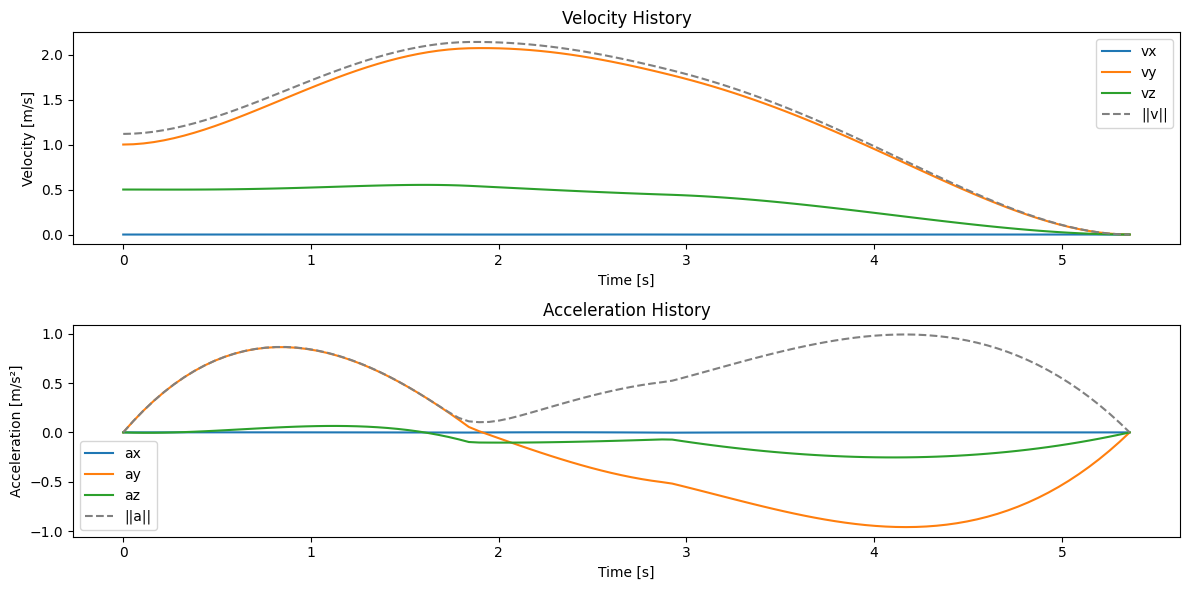

In [1266]:
def optimization_test(list_z0, max_iter):

    # Single optimization example usage:
    mem_size = list_z0[0].size

    # Print initial settings
    py_cost = evaluate_objective(list_z0[0])
    grad = compute_analytical_grad(list_z0[0])
    print(f"double py_cost={py_cost:.12f};")
    print(
        "Eigen::VectorXd py_gradient(prototype_solver_ptr->getNumDecisionVariables());"
    )
    print(
        "py_gradient << ",
    )
    for i, g in enumerate(grad):
        if i > 0:
            print(", ", end="")
        print(f"{g:.12f}", end="")
    print(";")

    # Default L-BFGS
    params = LBFGSParameter(mem_size=mem_size, max_iterations=max_iter)
    t_start = time.perf_counter()
    z_opt, f_val, g_val, info = lbfgs_optimize(
        list_z0[0],
        evaluate_objective,
        compute_analytical_grad,
        callback=progress_callback,
        params=params,
    )
    elapsed_time = time.perf_counter() - t_start
    print(f"L-BFGS Optimization completed in {elapsed_time:.4f} seconds.")

    # Plot the results
    list_cp_opt, list_t_opt = [], []
    cp_opt, t_opt = reconstruct(z_opt, x0, v0, a0, xf, vf, af, global_wps)
    list_cp_opt.append(cp_opt)
    list_t_opt.append(t_opt)
    # 3c) Plot the optimized trajectories
    plot_initial_setting_plotly(obstacles, list_cp_opt, list_t_opt)
    # Plot control points using Plotly
    plot_control_points_plotly(list_cp_opt, labels=True)
    print("\nResult:")
    print("t_opt =", t_opt)

    # Plot the velocity and acceleration histories
    pts, vels, accs, _ = eval_traj_and_derivs(cp_opt, t_opt, 100)
    t_plot = np.linspace(0, np.sum(t_opt), 100)
    plot_velocity_acceleration_histories(pts, vels, accs, t_plot)

    # TRON L-BFGS
    # params = TRONParameter(mem_size=mem_size, max_iterations=max_iter)
    # t_start = time.perf_counter()
    # z_opt, f_val, g_val, info = tron_lbfgs_optimize(
    #     list_z0[0],
    #     evaluate_objective,
    #     compute_analytical_grad,
    #     callback=progress_callback,
    #     params=params,
    # )
    # elapsed_time = time.perf_counter() - t_start
    # print(f"TRON L-BFGS Optimization completed in {elapsed_time:.4f} seconds.")

    # # Trust-Region Newton-CG
    # params = TNCGParameter(max_iterations=5, cg_tolerance=0.05)

    # def make_hessp_callback(grad_func, epsilon: float = 1e-6):
    #     """
    #     Returns a Hessian-vector product function hessp(x, p) ≈ H(x)·p via finite differences
    #     grad_func(x) should return the gradient ∇f(x) as a numpy array.
    #     epsilon is the FD stepsize.
    #     """

    #     def hessp_callback(x: np.ndarray, p: np.ndarray) -> np.ndarray:
    #         # central difference approximation of Hessian-vector product
    #         return (grad_func(x + epsilon * p) - grad_func(x - epsilon * p)) / (
    #             2 * epsilon
    #         )

    #     return hessp_callback

    # hessp = make_hessp_callback(compute_analytical_grad, epsilon=1e-6)
    # t_start = time.perf_counter()
    # z_opt, f_val, g_val, info = truncated_newton_cg_optimize(
    #     list_z0[0],
    #     evaluate_objective,
    #     compute_analytical_grad,
    #     hessp,
    #     callback=progress_callback,
    #     params=params,
    # )
    # elapsed_time = time.perf_counter() - t_start
    # print(
    #     f"Trust-Region Newton-CG Optimization completed in {elapsed_time:.4f} seconds."
    # )

    # # Nonliner CG
    # # Example callback that logs and prints progress:
    # history = []
    # def progress_callback_for_nlcg(iteration, x, f, g):
    #     history.append((iteration, f))
    #     print(f"Iter {iteration:3d}: f = {f:.1f}, ||g|| = {np.linalg.norm(g):.1f}")
    # t_start = time.perf_counter()
    # x_opt, f_opt, g_opt, info = nonlinear_conj_grad(list_z0[0], evaluate_objective, compute_analytical_grad, max_iters=max_iter, tol=1e-8, callback=progress_callback_for_nlcg)
    # elapsed_time = time.perf_counter() - t_start
    # print(f"Nonlinear Conjugate Gradient Optimization completed in {elapsed_time:.4f} seconds.")
                                                                    
    # print("\nResult:")
    # print(" x_opt =", x_opt)
    # print(" f_opt =", f_opt)
    # print(" info  =", info)


# Print optimization results
# print(f"z_opt: {z_opt}")
# print(f"f_val: {f_val:.6f}, g_val: {g_val}, info: {info}")

# # Plot single optimization results:
# list_cp_opt, list_t_opt = [], []
# cp_opt, t_opt = reconstruct(z_opt, x0, v0, a0, xf, vf, af, global_wps)
# list_cp_opt.append(cp_opt)
# list_t_opt.append(t_opt)
# # 3c) Plot the optimized trajectories
# plot_initial_setting_plotly(
#     c_x_obs, c_y_obs, c_z_obs,
#     T_obs, list_cp_opt, list_t_opt)
# # Plot control points using Plotly
# plot_control_points_plotly(list_cp_opt, labels=True)

# Multiple optimization (not paralleled) example usage:
# mem_size = list_z0[0].size
# max_iter = bfgs_max_iter
# params = LBFGSParameter(mem_size=mem_size, max_iterations=max_iter)

# # Run optimization for each initial guess
# list_z_opt = []
# for z0 in list_z0:
#     start_time = time.perf_counter()
#     z_opt, f_val, g_val, info = lbfgs_optimize(z0, evaluate_objective, compute_analytical_grad, params=params)
#     elapsed_time = time.perf_counter() - start_time
#     print(f"Initial guess: f* = {f_val:.6f}, status = {info['status']}, time = {elapsed_time:.4f} sec")
#     list_z_opt.append(z_opt)

# # Plot single optimization results:
# list_cp_opt, list_t_opt = [], []
# for z_opt in list_z_opt:
#     cp_opt, t_opt = reconstruct(z_opt, x0, v0, a0, xf, vf, af, global_wps)
#     list_cp_opt.append(cp_opt)
#     list_t_opt.append(t_opt)
# # 3c) Plot the optimized trajectories
# plot_initial_setting_plotly(obstacles, list_cp_opt, list_t_opt)
# # Plot control points using Plotly
# plot_control_points_plotly(list_cp_opt, labels=True)

# Parallel optimization example usage: (doesn't work in this notebook environment)

# mem_size = list_z0[0].size
# max_iter = bfgs_max_iter
# all_results = parallel_optimize(list_z0, mem_size, max_iter)

# # Unpack results
# z_opts, f_vals, g_vals, infos, times = zip(*all_results)

# print("Optimization results and timings:")
# for i, (f_val, info, elapsed) in enumerate(zip(f_vals, infos, times)):
#     print(f"Initial #{i}: f* = {f_val:.6f}, status = {info['status']}, time = {elapsed:.4f} sec")

# Call the optimization test function with the initial guesses
optimization_test(list_z0, bfgs_max_iter)

In [1008]:
#########################################################
# C++ code debugging
#########################################################

import re
import ast
import numpy as np

# # Test 1 (test cost evaluation and gradient)
# test1_z0 = list_z0[0]  # use the first initial guess for testing

# # get cost and gradient
# test1_cost = evaluate_objective(test1_z0)
# test1_grad = compute_analytical_grad(test1_z0)

# # C++'s results (copyied from the C++ output)
# cpp_Initial_guess_z0 = [
#     0.00000000,
#     3.00000000,
#     1.00000000,
#     0.40000000,
#     3.40000000,
#     1.10000000,
#     0.80000000,
#     3.80000000,
#     1.20000000,
#     2.00000000,
#     5.00000000,
#     1.50000000,
#     2.60000000,
#     5.00000000,
#     1.60000000,
#     3.20000000,
#     5.00000000,
#     1.70000000,
#     1.35079358,
#     1.16453676,
#     1.27407259,
# ]
# cpp_cost = 68967.39023414
# cpp_gradient = [
#     -8337.52527061,
#     2312.70908402,
#     5757.76058467,
#     7569.20345259,
#     -1486.68844513,
#     -7034.21226992,
#     3335.20836570,
#     -2620.85396936,
#     2762.48744513,
#     -59256.04923590,
#     26613.28225278,
#     -7660.40666015,
#     128204.59405441,
#     -38125.61643111,
#     18191.57549205,
#     -154033.12139433,
#     13736.82530015,
#     -24527.88773196,
#     -1537.59472845,
#     -3646.10544750,
#     -168274.50252884,
# ]


# # make them numpy arrays for easier comparison
# cpp_Initial_guess_z0 = np.array(cpp_Initial_guess_z0, dtype=float)
# cpp_cost = float(cpp_cost)
# cpp_gradient = np.array(cpp_gradient, dtype=float)

# print("Test1: Python cost and gradient evaluation")
# print(f"Initial guess z0: {test1_z0}")
# print(f"Computed cost: {test1_cost:.6f}")
# print(f"Computed gradient: {test1_grad}")

# # Compare the computed cost and gradient with the C++ results
# print("Test 1: Comparing with C++ results...")
# print(
#     f"difference in initial guess: {np.linalg.norm(test1_z0 - cpp_Initial_guess_z0):.6f}"
# )
# print(f"difference in cost: {test1_cost - cpp_cost:.6f}")

# diff_in_grad = test1_grad - cpp_gradient
# absolute_diff_in_grad = np.abs(diff_in_grad)
# print(f"difference in gradient for element wise norm: {absolute_diff_in_grad}")

# Test 2 (actual optimiation results)
def load_zopt_list(fname):
    text = open(fname).read()

    # find the start of the zopt_list block
    idx = text.find("zopt_list")
    if idx < 0:
        raise RuntimeError("no zopt_list in " + fname)
    tail = text[idx:]

    # find all np.array([...], dtype=float) in that tail, across newlines
    array_literals = re.findall(
        r"np\.array\(\s*(\[[\s\S]*?\])\s*,\s*dtype\s*=\s*float\s*\)",
        tail,
        flags=re.DOTALL
    )
    if not array_literals:
        raise RuntimeError("no np.array(...) entries after zopt_list")

    result = []
    for lit in array_literals:
        # lit is a string like "[0.11, 3.11, ...]"
        data = ast.literal_eval(lit)      # now a Python list of floats
        result.append(np.array(data, dtype=float))

    return result
# usage
zopt_list = load_zopt_list("/home/kkondo/code/dynus_ws/results.txt")

# Plot single optimization results:
list_cp_opt, list_t_opt = [], []

# if we only have one solution, we can just use that
if len(zopt_list[1]) == 0:
    zopt_list = [zopt_list[0]]

for z_opt in zopt_list:
    cp_opt, t_opt = reconstruct(z_opt, x0, v0, a0, xf, vf, af, global_wps)
    list_cp_opt.append(cp_opt)
    list_t_opt.append(t_opt)
# 3c) Plot the optimized trajectories
plot_initial_setting_plotly(obstacles, list_cp_opt, list_t_opt)
# Plot control points using Plotly
plot_control_points_plotly(list_cp_opt, labels=True)

IndexError: list index out of range

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad
import numpy as np

#######################################################
# Jacobian test
########################################################

# --- 1) JAX versions of all the pieces ---

# def softplus_jax(x):
#     return jnp.log1p(jnp.exp(x))

def bernstein_basis_and_derivative_jax(n, tau):
    # identical logic, but with jnp
    B = jnp.array([comb(n,j) * tau**j * (1-tau)**(n-j) for j in range(n+1)])
    if n == 0:
        dB = jnp.array([0.])
    else:
        Bm1 = jnp.array([comb(n-1,j) * tau**j * (1-tau)**((n-1)-j) for j in range(n)])
        dB = jnp.zeros(n+1)
        dB = dB.at[0].set(-n * Bm1[0])
        dB = dB.at[n].set( n * Bm1[-1])
        for j in range(1,n):
            dB = dB.at[j].add( n * (Bm1[j-1] - Bm1[j]) )
    return B, dB

def get_segment_and_tau_jax(ti, T):
    ends = jnp.cumsum(T)
    seg  = jnp.searchsorted(ends, ti, side='right')
    seg  = jnp.minimum(seg, T.shape[0]-1)
    t0   = jnp.where(seg>0, ends[seg-1], 0.0)
    tau  = (ti - t0) / T[seg]
    return seg, tau, t0

def reconstruct_jax(z, x0, v0, a0, xf, vf, af, wps):
    M = wps.shape[0] - 1
    F = len(free_cps)

    cp_free = z[:3*F].reshape(F,3)
    sig     = z[3*F:3*F+M]

    # t_mins = jnp.zeros((M,))
    # for i in range(M-1):
    #     dist = jnp.linalg.norm(wps[i+1] - wps[i])
        # t_mins = t_mins.at[i].set(dist / V_max)

    T = jnp.exp(sig) # + t_mins

    CP = jnp.zeros((M,6,3))
    for idx_free, (seg,cp_idx) in enumerate(free_cps):
        CP = CP.at[seg,cp_idx].set(cp_free[idx_free])

    # boundary at start
    T0 = T[0]
    CP = CP.at[0,0].set(x0)
    CP = CP.at[0,1].set(x0 + (T0/5.0)*v0)
    CP = CP.at[0,2].set(x0 + (2*T0/5.0)*v0 + (T0**2/20.0)*a0)

    # boundary at end
    TM = T[-1]
    CP = CP.at[-1,5].set(xf)
    CP = CP.at[-1,4].set(xf - (TM/5.0)*vf)
    CP = CP.at[-1,3].set(xf - (2*TM/5.0)*vf + (TM**2/20.0)*af)

    # C2 continuity
    for s in range(M-1):
        Ts, Ts1 = T[s], T[s+1]
        r = Ts / Ts1
        P50 = CP[s+1,0]
        CP = CP.at[s,5].set(P50)
        delta01 = CP[s+1,1] - CP[s+1,0]
        CP = CP.at[s,4].set(P50 - r*delta01)
        sec = CP[s+1,2] - 2*CP[s+1,1] + CP[s+1,0]
        P4  = CP[s,4]
        CP = CP.at[s,3].set(2*P4 - P50 + r**2 * sec)

    return CP, T

def eval_traj_jax(CP, T, N_samp):
    total = jnp.sum(T)
    t_abs = jnp.linspace(0.0, total, N_samp)

    def sample(ti):
        seg, tau, _ = get_segment_and_tau_jax(ti, T)
        B, _        = bernstein_basis_and_derivative_jax(5, tau)
        return B @ CP[seg]

    return jnp.vstack([sample(ti) for ti in t_abs])

def f_obs_poly_jax(t, cx, cy, cz):
    # port your polynomial
    px = sum(cx[i] * t**i for i in range(6))
    py = sum(cy[i] * t**i for i in range(6))
    pz = sum(cz[i] * t**i for i in range(6))
    return jnp.stack([px,py,pz], axis=1)


In [ ]:
#######################################################
# Min-Time Jacobian test
########################################################

# JAX‐ified constants (must match your Python scope)
x0_jax, v0_jax, a0_jax = jnp.array(x0), jnp.array(v0), jnp.array(a0)
xf_jax, vf_jax, af_jax = jnp.array(xf), jnp.array(vf), jnp.array(af)
global_wps_jax          = jnp.array(global_wps)
z0 = list_z0[0]  # use the first initial guess for testing

def J_time_jax(z):
    _, T = reconstruct_jax(z, x0_jax, v0_jax, a0_jax, xf_jax, vf_jax, af_jax, global_wps_jax)
    return jnp.sum(T)

def test_J_time():

    # 2) Build the JAX gradient
    grad_J_time = grad(J_time_jax)

    # 3) Evaluate at the test point
    z0_jax      = jnp.array(z0)                # your nominal test vector
    CP0, T0     = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
    g_analytic_time = dJ_time_dsigma(z0, T0)   # analytic ∂J_time/∂σ
    g_jax_time      = np.array(grad_J_time(z0_jax))  # JAX → NumPy

    # 4) Compare
    abs_err = np.abs(g_analytic_time - g_jax_time[3*F:])  # skip the free CPs
    rel_err = abs_err / (np.abs(g_analytic_time) + np.abs(g_jax_time[3*F:]) + 1e-12)

    print("J_time gradient test results:")
    print(f"‖analytic_time‖∞ = {np.max(np.abs(g_analytic_time))}")
    print(f"‖jax_time‖∞      = {np.max(np.abs(g_jax_time))}")
    print(f"max abs error    = {abs_err.max():.6g}")
    print(f"max rel error    = {rel_err.max():.3e}")

    bad = np.where(rel_err > 1e-6)[0]
    if len(bad):
        print("Indices with rel_err >1e-6:", bad)
        print(" idx | analytic    |    jax      | rel_err")
        for i in bad:
            print(f"{i:4d} | {g_analytic_time[i]:12.6f} | {g_jax_time[i]:12.6f} | {rel_err[i]:8.3e}")
    else:
        # print it in green if all is well
        print("\033[92m [J_time] All time‐cost gradient entries match to within 1e‐6!\033[0m")

# Run the test
test_J_time()

J_time gradient test results:
‖analytic_time‖∞ = 4.145780987944249
‖jax_time‖∞      = 4.145780987944249
max abs error    = 0
max rel error    = 0.000e+00
 [J_time] All time‐cost gradient entries match to within 1e‐6!


In [ ]:
#######################################################
# Dynamic Obstacle Jacobian test
########################################################

import jax.numpy as jnp
import jax
from jax import config
config.update("jax_enable_x64", True)

@jax.jit
def J_dyn_multi_jax(z, Cx_obs, Cy_obs, Cz_obs):
    """
    z:      (nz,)
    Cx_obs: (n_obs,6)
    Cy_obs: (n_obs,6)
    Cz_obs: (n_obs,6)
    """
    # 1) Reconstruct & sample your own trajectory
    CP, T_traj = reconstruct_jax(
        z, x0_jax, v0_jax, a0_jax, xf_jax, vf_jax, af_jax, global_wps_jax
    )

    # 2) Define one‐obstacle cost
    def cost_one(cx, cy, cz):

        CP, T = reconstruct_jax(
            z, x0_jax, v0_jax, a0_jax, xf_jax, vf_jax, af_jax, global_wps_jax
        )

        pts = eval_traj_jax(CP, T, N_samp)
        t_abs = jnp.linspace(0.0, jnp.sum(T), N_samp)
        obs = f_obs_poly_jax(t_abs, cx, cy, cz)

        E_half = jnp.diag(jnp.array([1.0, 1.0, 1.0 / jnp.sqrt(c)]))
        diff = (pts - obs) @ E_half.T
        d2 = jnp.sum(diff**2, axis=1)
        return jnp.sum(jnp.maximum(0.0, Cw**2 - d2) ** 3)

    # 3) Vectorize over obstacles
    per_obs = jax.vmap(cost_one, in_axes=(0, 0, 0))(Cx_obs, Cy_obs, Cz_obs)  # (n_obs,)

    # 4) Total cost
    return jnp.sum(per_obs)

def test_J_dyn():

    # Then your gradient is
    grad_J_dyn_multi = jax.jit(jax.grad(J_dyn_multi_jax))

    # ——— Example usage ———
    # Suppose you have a Python list of obstacles, each with 6×3 coefficients:
    obs_list = []
    print("obstacles:", obstacles)
    for obs in obstacles:
        # obs is a tuple (cx, cy, cz) with 6 coefficients each
        cx, cy, cz = fit_quintic(obs[0], obs[1], obs[2], obs[3], obs[4], obs[5], obs[6])
        obs_list.append((jnp.array(cx), jnp.array(cy), jnp.array(cz)))

    # Stack into JAX arrays of shape (n_obs,6)
    Cx_obs = jnp.stack([o[0] for o in obs_list])
    Cy_obs = jnp.stack([o[1] for o in obs_list])
    Cz_obs = jnp.stack([o[2] for o in obs_list])

    z0_jax = jnp.array(z0)  # your decision vector

    # compute gradient
    g_jax = grad_J_dyn_multi(z0_jax, Cx_obs, Cy_obs, Cz_obs)
    # print("∇J_dyn multi:", g_jax)

    # 4) If you want a NumPy array for comparison, pull it back:
    g_jax_np = np.array(g_jax)  # or jax.device_get(g_jax)

    # 5) Compute your analytic gradient
    CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
    g_analytic = dJ_dyn_dz(z0, CP0, T0, N_samp)

    # 6) Compare
    diff = g_analytic - g_jax_np
    abs_err = np.abs(diff)
    rel_err = abs_err / (np.maximum(1e-8, np.abs(g_jax_np) + np.abs(g_analytic)))

    print("‖g_analytic‖∞     =", np.max(np.abs(g_analytic)))
    print("‖g_jax‖∞          =", np.max(np.abs(g_jax_np)))
    print("max abs error     =", np.max(abs_err))
    print("max rel error     =", np.max(rel_err))

    if np.any(rel_err > 1e-6):
        print(f"\033[91mindices fail >1e-6: {np.where(rel_err > 1e-6)[0]} \033[0m")
        print("\n i |    g_analytic    |      g_jax       |   rel_err")
        print("---+------------------+------------------+-----------")
        for i in np.where(rel_err > 1e-6)[0][:10]:
            print(f"{i:2d} | {g_analytic[i]: .6e} | {g_jax_np[i]: .6e} | {rel_err[i]: .2e}")
    else:
        print("\033[92m [J_dyn] All entries match to within 1e‐6!\033[0m")

# Run the dynamic obstacle Jacobian test
test_J_dyn()

obstacles: [[array([1., 3., 1.]), array([-0.3,  0.3,  0. ]), array([0., 0., 0.]), array([-2. ,  4. ,  1.5]), array([0., 0., 0.]), array([0., 0., 0.]), 10.0], [array([-1.,  5., -1.]), array([0.5, 0. , 0. ]), array([0., 0., 0.]), array([ 6. ,  5. , -0.5]), array([0., 0., 0.]), array([0., 0., 0.]), 8.0]]
‖g_analytic‖∞     = 0.0
‖g_jax‖∞          = 0.0
max abs error     = 0.0
max rel error     = 0.0
 [J_dyn] All entries match to within 1e‐6!


In [ ]:
# Dynamic obstacle Jacobian test (a part of the dynamic obstacle cost gradient)

# def dt_abs_func(z):
#     """
#     Return the absolute times t_abs for a decision vector z,
#     sampled at N_samp points (matching compute_dk_dz).
#     """
#     _, T = reconstruct(z, x0, v0, a0, xf, vf, af, global_wps)
#     total_time = np.sum(T)
#     return np.linspace(0.0, total_time, N_samp)

# # pick parameters
# z0 = list_z0[1]
# F  = len(free_cps)
# r  = 1       # which slack to test
# i  = 5       # which time‐sample to test
# eps= 1e-6

# # small bump in σ_r
# dz = np.zeros_like(z0)
# dz[3*F + r] = eps

# # get original times
# t_abs = dt_abs_func(z0)
# t0    = t_abs[i]

# # get bumped times
# t_plus  = dt_abs_func(z0 + dz)[i]
# t_minus = dt_abs_func(z0 - dz)[i]

# # numeric derivative of x_obs w.r.t. σ_r
# x_plus  = f_obs_poly(np.array([t_plus]),  c_x_obs, c_y_obs, c_z_obs)[0]
# x_minus = f_obs_poly(np.array([t_minus]), c_x_obs, c_y_obs, c_z_obs)[0]
# numeric = (x_plus - x_minus) / (2*eps)

# # analytic from your Jacobian
# CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
# dk       = compute_dk_dz(z0, T0, N_samp, c_x_obs, c_y_obs, c_z_obs)
# analytic = dk[i, :, 3*F + r]

# print("numeric dk_dz:", numeric)
# print("analytic dk_dz:", analytic)


In [ ]:
# the ego‐trajectory Jacobian ∂u_i/∂z (a part of the dynamic obstacle cost gradient)

# Parameters
# i   = 3         # sample index
# r   = 2         # slack index to test
# eps = 1e-6
# F   = len(free_cps)
# K   = z0.size

# # Bump σ_r
# dz = np.zeros_like(z0)
# dz[3*F + r] = eps

# # Baseline trajectory point
# CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
# u0 = eval_traj(CP0, T0, N_samp)[i]

# # Bumped forward/backward
# CP_p, T_p = reconstruct(z0+dz, x0, v0, a0, xf, vf, af, global_wps)
# u_p = eval_traj(CP_p, T_p, N_samp)[i]
# CP_m, T_m = reconstruct(z0-dz, x0, v0, a0, xf, vf, af, global_wps)
# u_m = eval_traj(CP_m, T_m, N_samp)[i]

# # Numeric derivative
# numeric_du = (u_p - u_m) / (2*eps)

# # Analytic from compute_du_dz
# du_dz = compute_du_dz(z0, CP0, T0, N_samp, free_cps, global_wps)
# analytic_du = du_dz[i, :, 3*F + r]

# print("numeric ∂u/∂σ[{}]:".format(r), numeric_du)
# print("analytic ∂u/∂σ[{}]:".format(r), analytic_du)


In [ ]:
import numpy as np

# pick the same i, k that you tested
# i      = 5                      # sample index
# idx_cp = 0                      # which free‐CP in free_cps
# dim    = 0                      # x‐component
# F      = len(free_cps)
# k      = 3*idx_cp + dim         # global index in z0

# # reconstruct once
# CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
# t_abs   = np.linspace(0, T0.sum(), N_samp)
# # find segment and local tau for sample i
# ends    = np.cumsum(T0)
# ti      = t_abs[i]
# seg     = np.searchsorted(ends, ti, side='right')
# t0      = ends[seg-1] if seg>0 else 0.0
# tau     = (ti - t0) / T0[seg]

# # precompute basis
# B  = np.array([bernstein(5,j,tau) for j in range(6)])
# dPdz = compute_dP_dz(z0, CP0, T0)    # shape (M,6,3,K)

# # 1) direct‐only contribution
# direct = np.zeros(3)
# for j in range(6):
#     direct += B[j] * dPdz[seg, j, :, k]

# # 2) your full analytic
# du_dz = compute_du_dz(z0, CP0, T0, N_samp, free_cps, global_wps)
# analytic_full = du_dz[i, :, k]

# # 3) numeric (for reference)
# dz      = np.zeros_like(z0); dz[k] = eps
# u_p     = eval_traj(*reconstruct(z0+dz, x0, v0, a0, xf, vf, af, global_wps), N_samp)[i]
# u_m     = eval_traj(*reconstruct(z0-dz, x0, v0, a0, xf, vf, af, global_wps), N_samp)[i]
# numeric = (u_p - u_m)/(2*eps)

# print("direct term     :", direct)
# print("analytic (full) :", analytic_full)
# print("numeric         :", numeric)


In [ ]:
# eps = 1e-4
# dz = np.zeros_like(z0); dz[k] = eps
# u_p = eval_traj(*reconstruct(z0+dz, x0, v0, a0, xf, vf, af, global_wps), N_samp)[i]
# u_m = eval_traj(*reconstruct(z0-dz, x0, v0, a0, xf, vf, af, global_wps), N_samp)[i]
# numeric = (u_p - u_m)/(2*eps)

# print("numeric (eps=1e-4):", numeric)
# print("analytic         :", direct)


In [ ]:
import numpy as np

# Parameters for the check
# i = 5       # sample index to test
# r = 2       # slack index to test
# eps = 1e-6  # finite-difference step
# N_samp = 10

# # Baseline decision vector
# z0 = list_z0[1]

# # Compute t_abs and choose t_i
# t_abs = dt_abs_func(z0)   # length N_samp
# t_i = t_abs[i]

# # 1) Analytic ∂k_i/∂t
# # f_obs_poly coefficients c_x_obs, c_y_obs, c_z_obs
# dxdt = sum(j * c_x_obs[j] * t_i**(j-1) for j in range(1,6))
# dydt = sum(j * c_y_obs[j] * t_i**(j-1) for j in range(1,6))
# dzdt = sum(j * c_z_obs[j] * t_i**(j-1) for j in range(1,6))
# analytic_dk_dt = np.array([dxdt, dydt, dzdt])

# # Numeric ∂k_i/∂t
# k_plus_t  = f_obs_poly(np.array([t_i + eps]), c_x_obs, c_y_obs, c_z_obs)[0]
# k_minus_t = f_obs_poly(np.array([t_i - eps]), c_x_obs, c_y_obs, c_z_obs)[0]
# numeric_dk_dt = (k_plus_t - k_minus_t) / (2 * eps)

# # 2) Analytic ∂t_i/∂σ_r
# # compute_dT_dz returns (M, K) Jacobian of segment times
# F = len(free_cps)
# dTdz = compute_dT_dz(z0, F)     # shape (M, K)
# alpha = i / (N_samp - 1)
# analytic_dt_dz = alpha * np.sum(dTdz[:, 3*F + r])

# # Numeric ∂t_i/∂σ_r
# dz = np.zeros_like(z0)
# dz[3*F + r] = eps
# t_plus_z  = dt_abs_func(z0 + dz)[i]
# t_minus_z = dt_abs_func(z0 - dz)[i]
# numeric_dt_dz = (t_plus_z - t_minus_z) / (2 * eps)

# # 3) Analytic ∂k_i/∂σ_r via compute_dk_dz
# CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
# dk_dz_full = compute_dk_dz(z0, T0, N_samp, c_x_obs, c_y_obs, c_z_obs)
# analytic_dk_dz = dk_dz_full[i, :, 3*F + r]

# # 4) Numeric ∂k_i/∂σ_r via chain: numeric_dk_dt*analytic_dt_dz + analytic_dk_dt*numeric_dt_dz
# def k_i_comp(z):
#     t_abs = dt_abs_func(z)
#     return f_obs_poly([t_abs[i]], c_x_obs, c_y_obs, c_z_obs)[0]

# dz = np.zeros_like(z0); dz[3*F + r] = eps
# k_plus  = k_i_comp(z0 + dz)
# k_minus = k_i_comp(z0 - dz)
# numeric_dk_dz = (k_plus - k_minus)/(2*eps)
# # numeric_dk_dz = analytic_dk_dt * numeric_dt_dz

# # Display results
# print("∂k_i/∂t analytic :", analytic_dk_dt)
# print("∂k_i/∂t numeric  :", numeric_dk_dt)
# print()
# print("∂t_i/∂σ_r analytic:", analytic_dt_dz)
# print("∂t_i/∂σ_r numeric :", numeric_dt_dz)
# print()
# print("∂k_i/∂σ_r analytic:", analytic_dk_dz)
# print("∂k_i/∂σ_r numeric :", numeric_dk_dz)


In [1009]:
import jax
import jax.numpy as jnp
import numpy as np

# 1) Convert each to a JAX array in a Python list:
A_stat_jax = [jnp.array(Ai) for Ai in A_stat]
b_stat_jax = [jnp.array(bi) for bi in b_stat]

# -------------------------------------------------------------------
# 2) JIT‐ted static‐barrier cost
# -------------------------------------------------------------------
# @jax.jit
# def J_stat_jax(z):
#     # reconstruct_jax returns:
#     #   CP: shape (M, 6, 3)   -- M segments, 6 control‐points each, in R^3
#     #   T:  shape (M,)
#     CP, T = reconstruct_jax(z,
#                             x0_jax, v0_jax, a0_jax,
#                             xf_jax, vf_jax, af_jax,
#                             global_wps_jax)

#     J = 0.0
#     M = len(A_stat_jax)   # number of segments

#     # loop over segments and Bézier control‐points
#     for s in range(M):
#         for j in range(6):
#             # Which segment‐index half‐spaces to test at CP[s,j] ?
#             segments = [s-1, s] if (j == 0 and s > 0) else [s]
#             P_sj = CP[s, j]  # shape (3,)

#             # Loop over those segment‐indices
#             for seg in segments:
#                 Ai = A_stat_jax[seg]   # shape (n_planes_seg, 3)
#                 bi = b_stat_jax[seg]   # shape (n_planes_seg,)

#                 # compute all h = Ai @ P_sj - bi  in one vector
#                 h = Ai @ P_sj - bi      # vector of length n_planes_seg
#                 J += -jnp.sum(jnp.log(h))

#     return J

@jax.jit
def J_stat_jax(z):
    # Reconstruct gives CP: (M,6,3), T: (M,)
    CP, T = reconstruct_jax(
        z,
        x0_jax, v0_jax, a0_jax,
        xf_jax, vf_jax, af_jax,
        global_wps_jax
    )

    J = 0.0
    M = CP.shape[0]

    for s in range(M):
        for j in range(6):
            P_sj = CP[s, j]   # (3,)
            # each CP lies in one or two “active” half‐spaces
            segments = [s] if not (j == 0 and s > 0) else [s - 1, s]

            for seg in segments:
                Ai = A_stat_jax[seg]  # (n_planes, 3)
                bi = b_stat_jax[seg]  # (n_planes,)

                # signed distances for all planes at once
                h = Ai @ P_sj - bi         # (n_planes,)
                violation = Co - h  # positive ⇒ inside forbidden band

                # clamp to ≥0 and cube
                vio3 = jnp.maximum(violation, 0.0) ** 3

                # accumulate weighted sum
                J = J + jnp.sum(vio3)

    return J


# -------------------------------------------------------------------
# 3) Gradient & compare
# -------------------------------------------------------------------

def test_J_stat():

    z0_jax = jnp.array(z0)  # your decision vector
    grad_J_stat = jax.jit(jax.grad(J_stat_jax))
    g_jax_stat = grad_J_stat(z0_jax)

    # analytic
    CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
    g_analytic_stat = dJ_stat_dz(z0, CP0, T0)

    # pull back to NumPy
    g_jax_stat_np = np.array(g_jax_stat)

    # 6) Compare
    diff = g_analytic_stat - g_jax_stat_np
    abs_err = np.abs(diff)
    rel_err = abs_err / (np.maximum(1e-8, np.abs(g_jax_stat_np) + np.abs(g_analytic_stat)))

    print("‖g_analytic‖∞     =", np.max(np.abs(g_analytic_stat)))
    print("‖g_jax‖∞          =", np.max(np.abs(g_jax_stat_np)))
    print("max abs error     =", np.max(abs_err))
    print("max rel error     =", np.max(rel_err))

    if np.any(rel_err > 1e-6):
        print(f"\033[91mindices fail >1e-6: {np.where(rel_err > 1e-6)[0]} \033[0m")
        print("\n i |    g_analytic_stat    |      g_jax       |   rel_err")
        print("---+------------------+------------------+-----------")
        for i in np.where(rel_err > 1e-6)[0][:10]:
            print(f"{i:2d} | {g_analytic_stat[i]: .6e} | {g_jax_stat_np[i]: .6e} | {rel_err[i]: .2e}")
    else:
        print("\033[92m [J_stat] All entries match to within 1e‐6!\033[0m")

# Run the static barrier cost test
test_J_stat()

‖g_analytic‖∞     = 2.2207207580317747
‖g_jax‖∞          = 2.220720758031775
max abs error     = 4.440892098500626e-16
max rel error     = 1.702498698348677e-13
 [J_stat] All entries match to within 1e‐6!


In [1010]:
# dPdz test

# import numpy as np

# eps = 1e-6
# # 1) pick a test z
# z0 = list_z0[1]
# CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
# M,_,_,K = 0,0,0,0  # just to unpack shapes below
# M = CP0.shape[0]
# _,_,_,K = compute_dP_dz(z0,CP0,T0).shape

# # 2) analytic dPdz
# dPdz_ana = compute_dP_dz(z0, CP0, T0)    # shape (M,6,3,K)

# # 3) numeric dPdz
# dPdz_num = np.zeros_like(dPdz_ana)
# for k in range(K):
#     dz = np.zeros_like(z0); dz[k] = eps
#     CPp, _ = reconstruct(z0 + dz, x0, v0, a0, xf, vf, af, global_wps)
#     CPm, _ = reconstruct(z0 - dz, x0, v0, a0, xf, vf, af, global_wps)
#     dPdz_num[...,k] = (CPp - CPm) / (2*eps)

# # 4) compare
# abs_err = np.abs(dPdz_ana - dPdz_num)
# print("max |analytic–numeric| over all entries:", abs_err.max())
# print("where it’s largest:", np.unravel_index(np.argmax(abs_err), abs_err.shape))
# print()

In [1011]:
import numpy as np
import jax.numpy as jnp
from jax import grad

#######################################################
# Acceleration‐Penalty Jacobian test
#######################################################

# 1) Define a JAX version of the control‐point acceleration cost:
def J_acc_jax(z):
    # reconstruct in JAX
    CP, T = reconstruct_jax(
        z,
        x0_jax, v0_jax, a0_jax,
        xf_jax, vf_jax, af_jax,
        global_wps_jax,
    )  # CP: (M,6,3), T: (M,)
    M = CP.shape[0]
    J = 0.0
    for s in range(M):
        Ts = T[s]
        C_s = 20.0 / (Ts**2)
        # second‐differences Δ2P[s,m] = P[s,m+2] - 2 P[s,m+1] + P[s,m]
        d0 = CP[s,2] - 2*CP[s,1] + CP[s,0]
        d1 = CP[s,3] - 2*CP[s,2] + CP[s,1]
        d2 = CP[s,4] - 2*CP[s,3] + CP[s,2]
        d3 = CP[s,5] - 2*CP[s,4] + CP[s,3]
        # sum of squared norms
        S = jnp.dot(d0,d0) + jnp.dot(d1,d1) + jnp.dot(d2,d2) + jnp.dot(d3,d3)
        J += C_s * S
    return J

def test_J_acc():
    # 2) JAX gradient
    grad_J_acc = grad(J_acc_jax)

    # 3) Evaluate at your test point z0
    z0_jax     = jnp.array(z0)
    g_jax_acc  = np.array(grad_J_acc(z0_jax))  # JAX → NumPy

    # 4) Compute analytic gradient
    CP0, T0   = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
    g_analytic_acc = dJ_acc_dz(z0, CP0, T0)

    # 5) Compare
    diff    = g_analytic_acc - g_jax_acc
    abs_err = np.abs(diff)
    rel_err = abs_err / np.maximum(1e-8, np.abs(g_jax_acc) + np.abs(g_analytic_acc))

    print("‖g_analytic‖∞  =", np.max(np.abs(g_analytic_acc)))
    print("‖g_jax‖∞       =", np.max(np.abs(g_jax_acc)))
    print("max abs error  =", np.max(abs_err))
    print("max rel error  =", np.max(rel_err))

    if np.any(rel_err > 1e-6):
        idxs = np.where(rel_err > 1e-6)[0]
        print(f"\n\033[91mIndices failing >1e-6: {idxs}\033[0m")
        print(" i |  g_analytic  |    g_jax    | rel_err")
        print("---+--------------+-------------+--------")
        for i in idxs[:10]:
            print(f"{i:2d} | {g_analytic_acc[i]: .6e} | {g_jax_acc[i]: .6e} | {rel_err[i]: .2e}")
    else:
        print("\033[92m[J_acc] All entries match to within 1e-6!\033[0m")

# Run the acceleration‐penalty Jacobian test
test_J_acc()


‖g_analytic‖∞  = 33.94233507821499
‖g_jax‖∞       = 33.94233507821498
max abs error  = 7.105427357601002e-15
max rel error  = 3.009579454611847e-15
[J_acc] All entries match to within 1e-6!


In [924]:
#######################################################
# Jerk Jacobian test
########################################################

import jax.numpy as jnp
from jax import grad

# 1) Define a JAX version of just the jerk cost:
def J_jerk_jax(z):
    # reconstruct in JAX
    CP, T = reconstruct_jax(z, x0, v0, a0, xf, vf, af, global_wps)  
    # evaluate deltas
    M = CP.shape[0]
    J = 0.0
    for s in range(M):
        Ts = T[s]
        # compute the three third‐differences Δ3P
        Δ3_0 = CP[s,3] - 3*CP[s,2] + 3*CP[s,1] - CP[s,0]
        Δ3_1 = CP[s,4] - 3*CP[s,3] + 3*CP[s,2] - CP[s,1]
        Δ3_2 = CP[s,5] - 3*CP[s,4] + 3*CP[s,3] - CP[s,2]
        S = jnp.dot(Δ3_0,Δ3_0) + jnp.dot(Δ3_1,Δ3_1) + jnp.dot(Δ3_2,Δ3_2)
        J += (3600.0 / Ts**5) * S
    return J

# def bernstein2(tau):
#     """
#     Degree-2 Bernstein basis at tau.
#     Returns (B0, B1, B2).
#     """
#     return jnp.array([
#         (1 - tau)**2,
#         2 * tau * (1 - tau),
#         tau**2
#     ])

# @jax.jit
# def J_jerk_jax(z):
#     # 1) reconstruct
#     CP, T = reconstruct_jax(
#         z,
#         x0_jax, v0_jax, a0_jax,
#         xf_jax, vf_jax, af_jax,
#         global_wps_jax,
#     )
#     M = CP.shape[0]

#     # 2) build sample times *without* gradient
#     total_time = jnp.sum(T)
#     t_abs      = jax.lax.stop_gradient(jnp.linspace(0.0, total_time, N_samp))
#     ends       = jax.lax.stop_gradient(jnp.cumsum(T))

#     def one_sample(ti):
#         # find segment—no grad through ends/searchsorted either
#         seg = jnp.searchsorted(ends, ti, side='right')
#         seg = jnp.clip(seg, 0, M - 1)

#         # segment start time
#         t0  = jnp.where(seg > 0, ends[seg - 1], 0.0)

#         # local tau (this *does* depend on T[seg], which we want)
#         tau = (ti - t0) / T[seg]

#         # third‐differences
#         Pseg = CP[seg]  # (6,3)
#         d0 = Pseg[3] - 3*Pseg[2] + 3*Pseg[1] - Pseg[0]
#         d1 = Pseg[4] - 3*Pseg[3] + 3*Pseg[2] - Pseg[1]
#         d2 = Pseg[5] - 3*Pseg[4] + 3*Pseg[3] - Pseg[2]

#         # Bernstein degree‐2
#         B0, B1, B2 = bernstein2(tau)

#         # jerk
#         α     = 60.0 / (T[seg]**3)
#         j_vec = α * (B0*d0 + B1*d1 + B2*d2)

#         return jnp.dot(j_vec, j_vec)

#     # 3) accumulate
#     return jnp.sum(jax.vmap(one_sample)(t_abs))


def test_J_jerk():
    # 2) JAX gradient:
    grad_J_jerk = grad(J_jerk_jax)

    # 3) Evaluate at your test point z0:
    z0_jax = jnp.array(z0)
    g_jax_jerk = grad_J_jerk(z0_jax)

    # 4) Compute your analytic jerk gradient:
    CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
    g_analytic_jerk = dJ_jerk_dz(z0, CP0, T0)

    # 6) Compare
    diff = g_analytic_jerk - g_jax_jerk
    abs_err = np.abs(diff)
    rel_err = abs_err / (np.maximum(1e-8, np.abs(g_jax_jerk) + np.abs(g_analytic_jerk)))

    print("‖g_analytic‖∞     =", np.max(np.abs(g_analytic_jerk)))
    print("‖g_jax‖∞          =", np.max(np.abs(g_jax_jerk)))
    print("max abs error     =", np.max(abs_err))
    print("max rel error     =", np.max(rel_err))

    if np.any(rel_err > 1e-6):
        print(f"\033[91mindices fail >1e-6: {np.where(rel_err > 1e-6)[0]} \033[0m")
        print("\n i |    g_analytic_jerk    |      g_jax       |   rel_err")
        print("---+------------------+------------------+-----------")
        for i in np.where(rel_err > 1e-6)[0][:10]:
            print(f"{i:2d} | {g_analytic_jerk[i]: .6e} | {g_jax_jerk[i]: .6e} | {rel_err[i]: .2e}")
    else:
        print("\033[92m [J_jerk] All entries match to within 1e‐6!\033[0m")

# Run the jerk Jacobian test
test_J_jerk()

‖g_analytic‖∞     = 8787.370096591736
‖g_jax‖∞          = 8787.370096591734
max abs error     = 1.8189894035458565e-12
max rel error     = 2.0778499782488776e-16
 [J_jerk] All entries match to within 1e‐6!


In [812]:
#######################################################
# Vel Violation Jacobian test
########################################################

import jax.numpy as jnp
from jax import grad
import jax
import jax.numpy as jnp
from math import comb

# Make sure N_samp_jax is a plain Python int, not a jnp array:
N_samp_jax = 10  # for example
V_max_jax = V_max

def _bernstein5(tau):
    u = 1 - tau
    return jnp.stack([
        u**5,
        5 * tau * u**4,
        10 * tau**2 * u**3,
        10 * tau**3 * u**2,
        5 * tau**4 * u,
        tau**5,
    ], axis=0)

def _bernstein4(tau):
    u = 1 - tau
    return jnp.stack([
        u**4,
        4 * tau * u**3,
        6 * tau**2 * u**2,
        4 * tau**3 * u,
        tau**4,
    ], axis=0)

def _bernstein3(tau):
    u = 1 - tau
    return jnp.stack([
        u**3,
        3 * tau * u**2,
        3 * tau**2 * u,
        tau**3,
    ], axis=0)

@jax.jit
def eval_traj_and_derivs_jax(CP, T):
    """
    JAX: sample composite quintic Bézier and return (pts, vels, accs),
    all of shape (N_samp_jax, 3).
    """
    M = CP.shape[0]
    total_time = jnp.sum(T)

    # sample times with a *Python* constant N_samp_jax
    t_abs = jax.lax.stop_gradient(jnp.linspace(0.0, total_time, N_samp_jax))
    ends  = jax.lax.stop_gradient(jnp.cumsum(T))

    def one_sample(ti):
        seg = jnp.searchsorted(ends, ti, side='right')
        seg = jnp.clip(seg, 0, M - 1)
        t0  = jnp.where(seg > 0, ends[seg - 1], 0.0)
        Ti  = T[seg]
        tau = (ti - t0) / Ti

        Pseg = CP[seg]  # (6,3)

        # position
        p   = _bernstein5(tau) @ Pseg

        # velocity
        dP = Pseg[1:] - Pseg[:-1]    # (5,3)
        v   = (5.0 / Ti) * (_bernstein4(tau) @ dP)

        # acceleration
        ddP = Pseg[2:] - 2*Pseg[1:-1] + Pseg[:-2]  # (4,3)
        a   = (20.0 / (Ti**2)) * (_bernstein3(tau) @ ddP)

        return p, v, a

    pts, vels, accs = jax.vmap(one_sample)(t_abs)
    return pts, vels, accs

@jax.jit
def J_vel_jax(z):
    CP, T      = reconstruct_jax(z, x0_jax, v0_jax, a0_jax,
                                 xf_jax, vf_jax, af_jax,
                                 global_wps_jax)
    _, vels, _ = eval_traj_and_derivs_jax(CP, T)  # no N_samp arg

    eps   = 1e-6
    norms = jnp.sqrt(jnp.sum(vels**2, axis=-1) + eps)
    diffs = norms - V_max_jax
    penalties = jnp.where(diffs > 0.0, diffs**2, 0.0)
    return jnp.sum(penalties)

def test_J_vel_constr():

    # now actually get the JAX gradient
    grad_J_vel = grad(J_vel_jax)

    # pick your test point
    z0 = list_z0[1]
    CP0, T0 = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)

    # analytic gradient
    g_analytic_vel = dJ_vel_constr_dz(z0)

    # JAX gradient (convert back to numpy)
    z0_jax    = jnp.array(z0)
    g_jax_vel = np.array(grad_J_vel(z0_jax))

    # 6) Compare
    diff = g_analytic_vel - g_jax_vel
    abs_err = np.abs(diff)
    rel_err = abs_err / (np.maximum(1e-8, np.abs(g_jax_vel) + np.abs(g_analytic_vel)))

    print("‖g_analytic‖∞     =", np.max(np.abs(g_analytic_vel)))
    print("‖g_jax‖∞          =", np.max(np.abs(g_jax_vel)))
    print("max abs error     =", np.max(abs_err))
    print("max rel error     =", np.max(rel_err))

    if np.any(rel_err > 1e-6):
        print(f"\033[91mindices fail >1e-6: {np.where(rel_err > 1e-6)[0]} \033[0m")
        print("\n i |    g_analytic_vel    |      g_jax       |   rel_err")
        print("---+------------------+------------------+-----------")
        for i in np.where(rel_err > 1e-6)[0][:10]:
            print(f"{i:2d} | {g_analytic_vel[i]: .6e} | {g_jax_vel[i]: .6e} | {rel_err[i]: .2e}")
    else:
        print("\033[92m [J_vel_constr] All entries match to within 1e‐6!\033[0m")

    # print out g_nalytic_vel and g_jax_vel for all the terms
    # print("\n i |    g_analytic_vel    |      g_jax       |   rel_err")
    # print("---+------------------+------------------+-----------")
    # for i in range(len(g_analytic_vel)):
    #     print(f"{i:2d} | {g_analytic_vel[i]: .6e} | {g_jax_vel[i]: .6e} | {rel_err[i]: .2e}")  


# Run the jerk Jacobian test
test_J_vel_constr()

‖g_analytic‖∞     = 0.0590581320808303
‖g_jax‖∞          = 0.05905813208083029
max abs error     = 1.3877787807814457e-17
max rel error     = 1.6224180286464548e-16
 [J_vel_constr] All entries match to within 1e‐6!


In [814]:
#######################################################
# Accel Violation Jacobian test
########################################################

import jax
import jax.numpy as jnp
import jax.nn as jnn

A_max_jax = A_max
M_jax = int(M)

# @jax.jit
# def J_acc_jax(z):
#     # 1) Reconstruct CP and T
#     CP, T = reconstruct_jax(
#       z,
#       x0_jax, v0_jax, a0_jax,
#       xf_jax, vf_jax, af_jax,
#       global_wps_jax,
#     )  # CP: (M,6,3), T: (M,)

#     # 2) All the second‐differences at once: (M,4,3)
#     Q    = CP[:, 2:6] - 2*CP[:,1:5] + CP[:,0:4]
#     pref = (20.0/(T**2))[:,None,None]     # (M,1,1)
#     A    = pref * Q                       # (M,4,3)

#     # 3) squared norms → (M,4)
#     norm2 = jnp.sum(A*A, axis=-1)

#     # 4) hinge‐argument
#     diff = norm2 - A_max_jax**2           # (M,4)
#     x    = beta_acc * diff                # (M,4)

#     # 5) smooth hinge via stable softplus, then cube
#     sh   = jnn.softplus(x) / beta_acc     # (M,4)
#     cost = jnp.sum(sh**3)

#     # 6) scale by your acceleration‐constraint weight
#     return cost

def J_acc_jax(z):
    """
    Sampling‐based acceleration‐constraint penalty in JAX:
      J_acc = sum_{i=1..N_samp} max(||a(t_i)|| - A_max, 0)^2
    where a(t_i) is the 3D acceleration of the composite quintic Bézier.
    """
    # 1) reconstruct spline
    CP, T      = reconstruct_jax(
        z,
        x0_jax, v0_jax, a0_jax,
        xf_jax, vf_jax, af_jax,
        global_wps_jax,
    )   # CP:(M,6,3), T:(M,)

    # 2) sample positions, velocities, accelerations
    _, _, accs = eval_traj_and_derivs_jax(CP, T)  # accs:(N_samp_jax,3)

    # 3) safe‐norm of acceleration
    eps   = 1e-6
    norms = jnp.sqrt(jnp.sum(accs**2, axis=-1) + eps)  # (N_samp_jax,)

    print("Python A_max =", A_max)
    print("JAX   A_max_jax =", A_max_jax)


    # 4) hinge‐squared penalty
    diffs     = norms - A_max_jax                      # (N_samp_jax,)
    penalties = jnp.where(diffs > 0.0, diffs**2, 0.0)  # (N_samp_jax,)

    # 5) total cost
    return jnp.sum(penalties)

def test_J_acc_constr():

    # JAX gradient
    grad_J_acc = grad(J_acc_jax)

    z0_jax     = jnp.array(z0)
    g_jax_acc  = np.array(grad_J_acc(z0_jax))      # JAX → NumPy

    # analytic
    CP0, T0    = reconstruct(z0, x0, v0, a0, xf, vf, af, global_wps)
    g_analytic_acc = dJ_acc_constr_dz(z0)
    
    # 6) Compare
    diff = g_analytic_acc - g_jax_acc
    abs_err = np.abs(diff)
    rel_err = abs_err / (np.maximum(1e-8, np.abs(g_jax_acc) + np.abs(g_analytic_acc)))

    print("‖g_analytic‖∞     =", np.max(np.abs(g_analytic_acc)))
    print("‖g_jax‖∞          =", np.max(np.abs(g_jax_acc)))
    print("max abs error     =", np.max(abs_err))
    print("max rel error     =", np.max(rel_err))

    if np.any(rel_err > 1e-6):
        print(f"\033[91mindices fail >1e-6: {np.where(rel_err > 1e-6)[0]} \033[0m")
        print("\n i |    g_analytic_acc    |      g_jax       |   rel_err")
        print("---+------------------+------------------+-----------")
        for i in np.where(rel_err > 1e-6)[0][:10]:
            print(f"{i:2d} | {g_analytic_acc[i]: .6e} | {g_jax_acc[i]: .6e} | {rel_err[i]: .2e}")
    else:
        print("\033[92m [J_acc_constr] All entries match to within 1e‐6!\033[0m")

# Run the acceleration violation Jacobian test
test_J_acc_constr()


Python A_max = 10.0
JAX   A_max_jax = 10.0
‖g_analytic‖∞     = 0.0
‖g_jax‖∞          = 0.0
max abs error     = 0.0
max rel error     = 0.0
 [J_acc_constr] All entries match to within 1e‐6!
